In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['OMP_NUM_THREADS'] = "64"

# file ops
from pathlib import Path
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings(action="ignore", category=RuntimeWarning)

# spatial
import xarray as xa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rioxarray
import cartopy.crs as ccrs

# machine learning
from dask.distributed import get_client, Client, LocalCluster, SSHCluster
from concurrent.futures import ThreadPoolExecutor
import xgboost as xgb

# custom
from coralshift.utils import file_ops, config, utils
from coralshift.dataloading import get_data
from coralshift.plotting import spatial_plots, visualise_results
from coralshift.machine_learning import static_models, run_model, ml_results
from coralshift.processing import ml_processing
from coralshift.processing import spatial_data

from tqdm.auto import tqdm
import cmipper
import cmipper.utils as cmipper_utils


# data fps
gt_data_dir = config.gt_data_dir
config_fp = "/maps/rt582/coralshift/runs/config_files/config_test.yaml"
config_info = file_ops.read_yaml(config_fp)

/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dataclasses import dataclass

@dataclass
class ProcessingConfig:
    do_crop: bool

    def __init__(self, conf: dict):
        self.do_crop = conf['do_crop']

@dataclass
class HyperparameterSearchConfig:
    cv_folds: int
    n_samples: int
    n_iter: int
    search_type: str
    do_search: bool
    n_trials: int
    search_types: list[str]
    n_jobs: int

    def __init__(self, conf: dict):
        self.cv_folds = conf['cv_folds']
        self.n_samples = conf['n_samples']
        self.n_iter = conf['n_iter']
        self.search_type = conf['search_type']
        self.do_search = conf['do_search']
        self.n_trials = conf['n_trials']
        self.search_types = conf['search_types']
        self.n_jobs = conf['n_jobs']

@dataclass
class Config:
    # could use a dynamic class here, but these are required parameters so will keep static for now
    # https://alexandra-zaharia.github.io/posts/python-configuration-and-dataclasses/#dynamically-creating-a-configuration-class
    data_source: str
    regressor_classification_threshold: float
    depth_mask: list[int]
    ds_type: str
    predictand: str
    datasets: list[str]
    env_vars: list[str]
    random_state: int
    resolution: float
    resolution_unit: str
    year_range_to_include: list[int]
    upsample_method: str
    downsample_method: str
    spatial_buffer: int
    save_figs: bool
    do_train: bool
    do_save_model: bool
    do_plot: bool
    processing: ProcessingConfig
    lats: list[int]
    lons: list[int]
    levs: list[int]
    split_type: str
    test_geom: list[int]
    train_test_val_frac: list[float]
    X_scaler: str
    y_scaler: str
    hyperparameter_search: HyperparameterSearchConfig
    source_id: str
    member_id: str

    def __init__(self, conf: dict):
        self.data_source = conf['data_source']
        self.regressor_classification_threshold = conf['regressor_classification_threshold']
        self.depth_mask = conf['depth_mask']
        self.ds_type = conf['ds_type']
        self.predictand = conf['predictand']
        self.datasets = conf['datasets']
        self.env_vars = conf['env_vars']
        self.random_state = conf['random_state']
        self.resolution = conf['resolution']
        self.resolution_unit = conf['resolution_unit']
        self.year_range_to_include = conf['year_range_to_include']
        self.upsample_method = conf['upsample_method']
        self.downsample_method = conf['downsample_method']
        self.spatial_buffer = conf['spatial_buffer']
        self.save_figs = conf['save_figs']
        self.do_train = conf['do_train']
        self.do_save_model = conf['do_save_model']
        self.do_plot = conf['do_plot']
        self.processing = ProcessingConfig(conf['processing'])
        self.lats = conf['lats']
        self.lons = conf['lons']
        self.levs = conf['levs']
        self.split_type = conf['split_type']
        self.test_geom = conf['test_geom']
        self.train_test_val_frac = conf['train_test_val_frac']
        self.X_scaler = conf['X_scaler']
        self.y_scaler = conf['y_scaler']
        self.hyperparameter_search = HyperparameterSearchConfig(conf['hyperparameter_search'])
        self.source_id = conf['source_id']
        self.member_id = conf['member_id']

config = Config(config_info)
config.X_scaler

'standard'

In [3]:
config.depth_mask

[-1000, 10]

In [32]:
gt_raw

<xarray.Dataset> Size: 387MB
Dimensions:    (latitude: 7200, longitude: 6720)
Coordinates:
  * latitude   (latitude) float64 58kB -31.0 -30.99 -30.99 ... -1.004 -1.0
  * longitude  (longitude) float64 54kB 139.0 139.0 139.0 ... 167.0 167.0 167.0
Data variables:
    UNEP_GDCR  (latitude, longitude) float64 387MB ...

Loading UNEP_GDCR data from original shapefile: /maps-priv/maps/rt582/coralshift/data/ground_truth/UNEP_GDCR/01_Data/WCMC008_CoralReef2021_Py_v4_1.shp
generating UNEP raster at 0.004 degrees resolution...
casting raster to xarray...
saving UNEP raster to /maps-priv/maps/rt582/coralshift/data/ground_truth/UNEP_GDCR/rasters/unep_0-004_S31-0_S1-0_E139-0_E167-0.nc...


(array([47734342.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,   208086.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

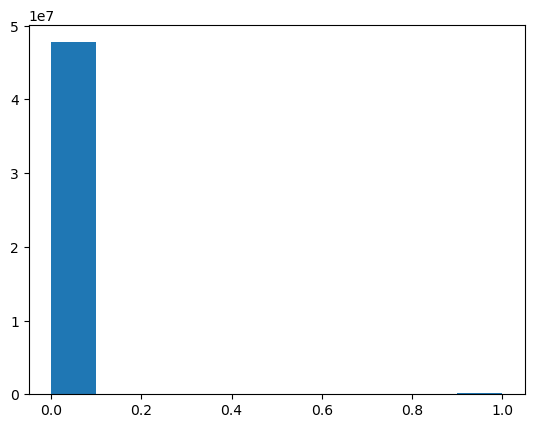

In [4]:
gt_raw = get_data.ReturnRaster(config).get_raw_raster("unep")
plt.hist(gt_raw["UNEP_GDCR"].values.flatten());

(<Figure size 3000x3000 with 2 Axes>,
 <GeoAxes: title={'center': 'UNEP_GDCR at 0.0042° (~452 m) resolution'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7fee908ffb00>)

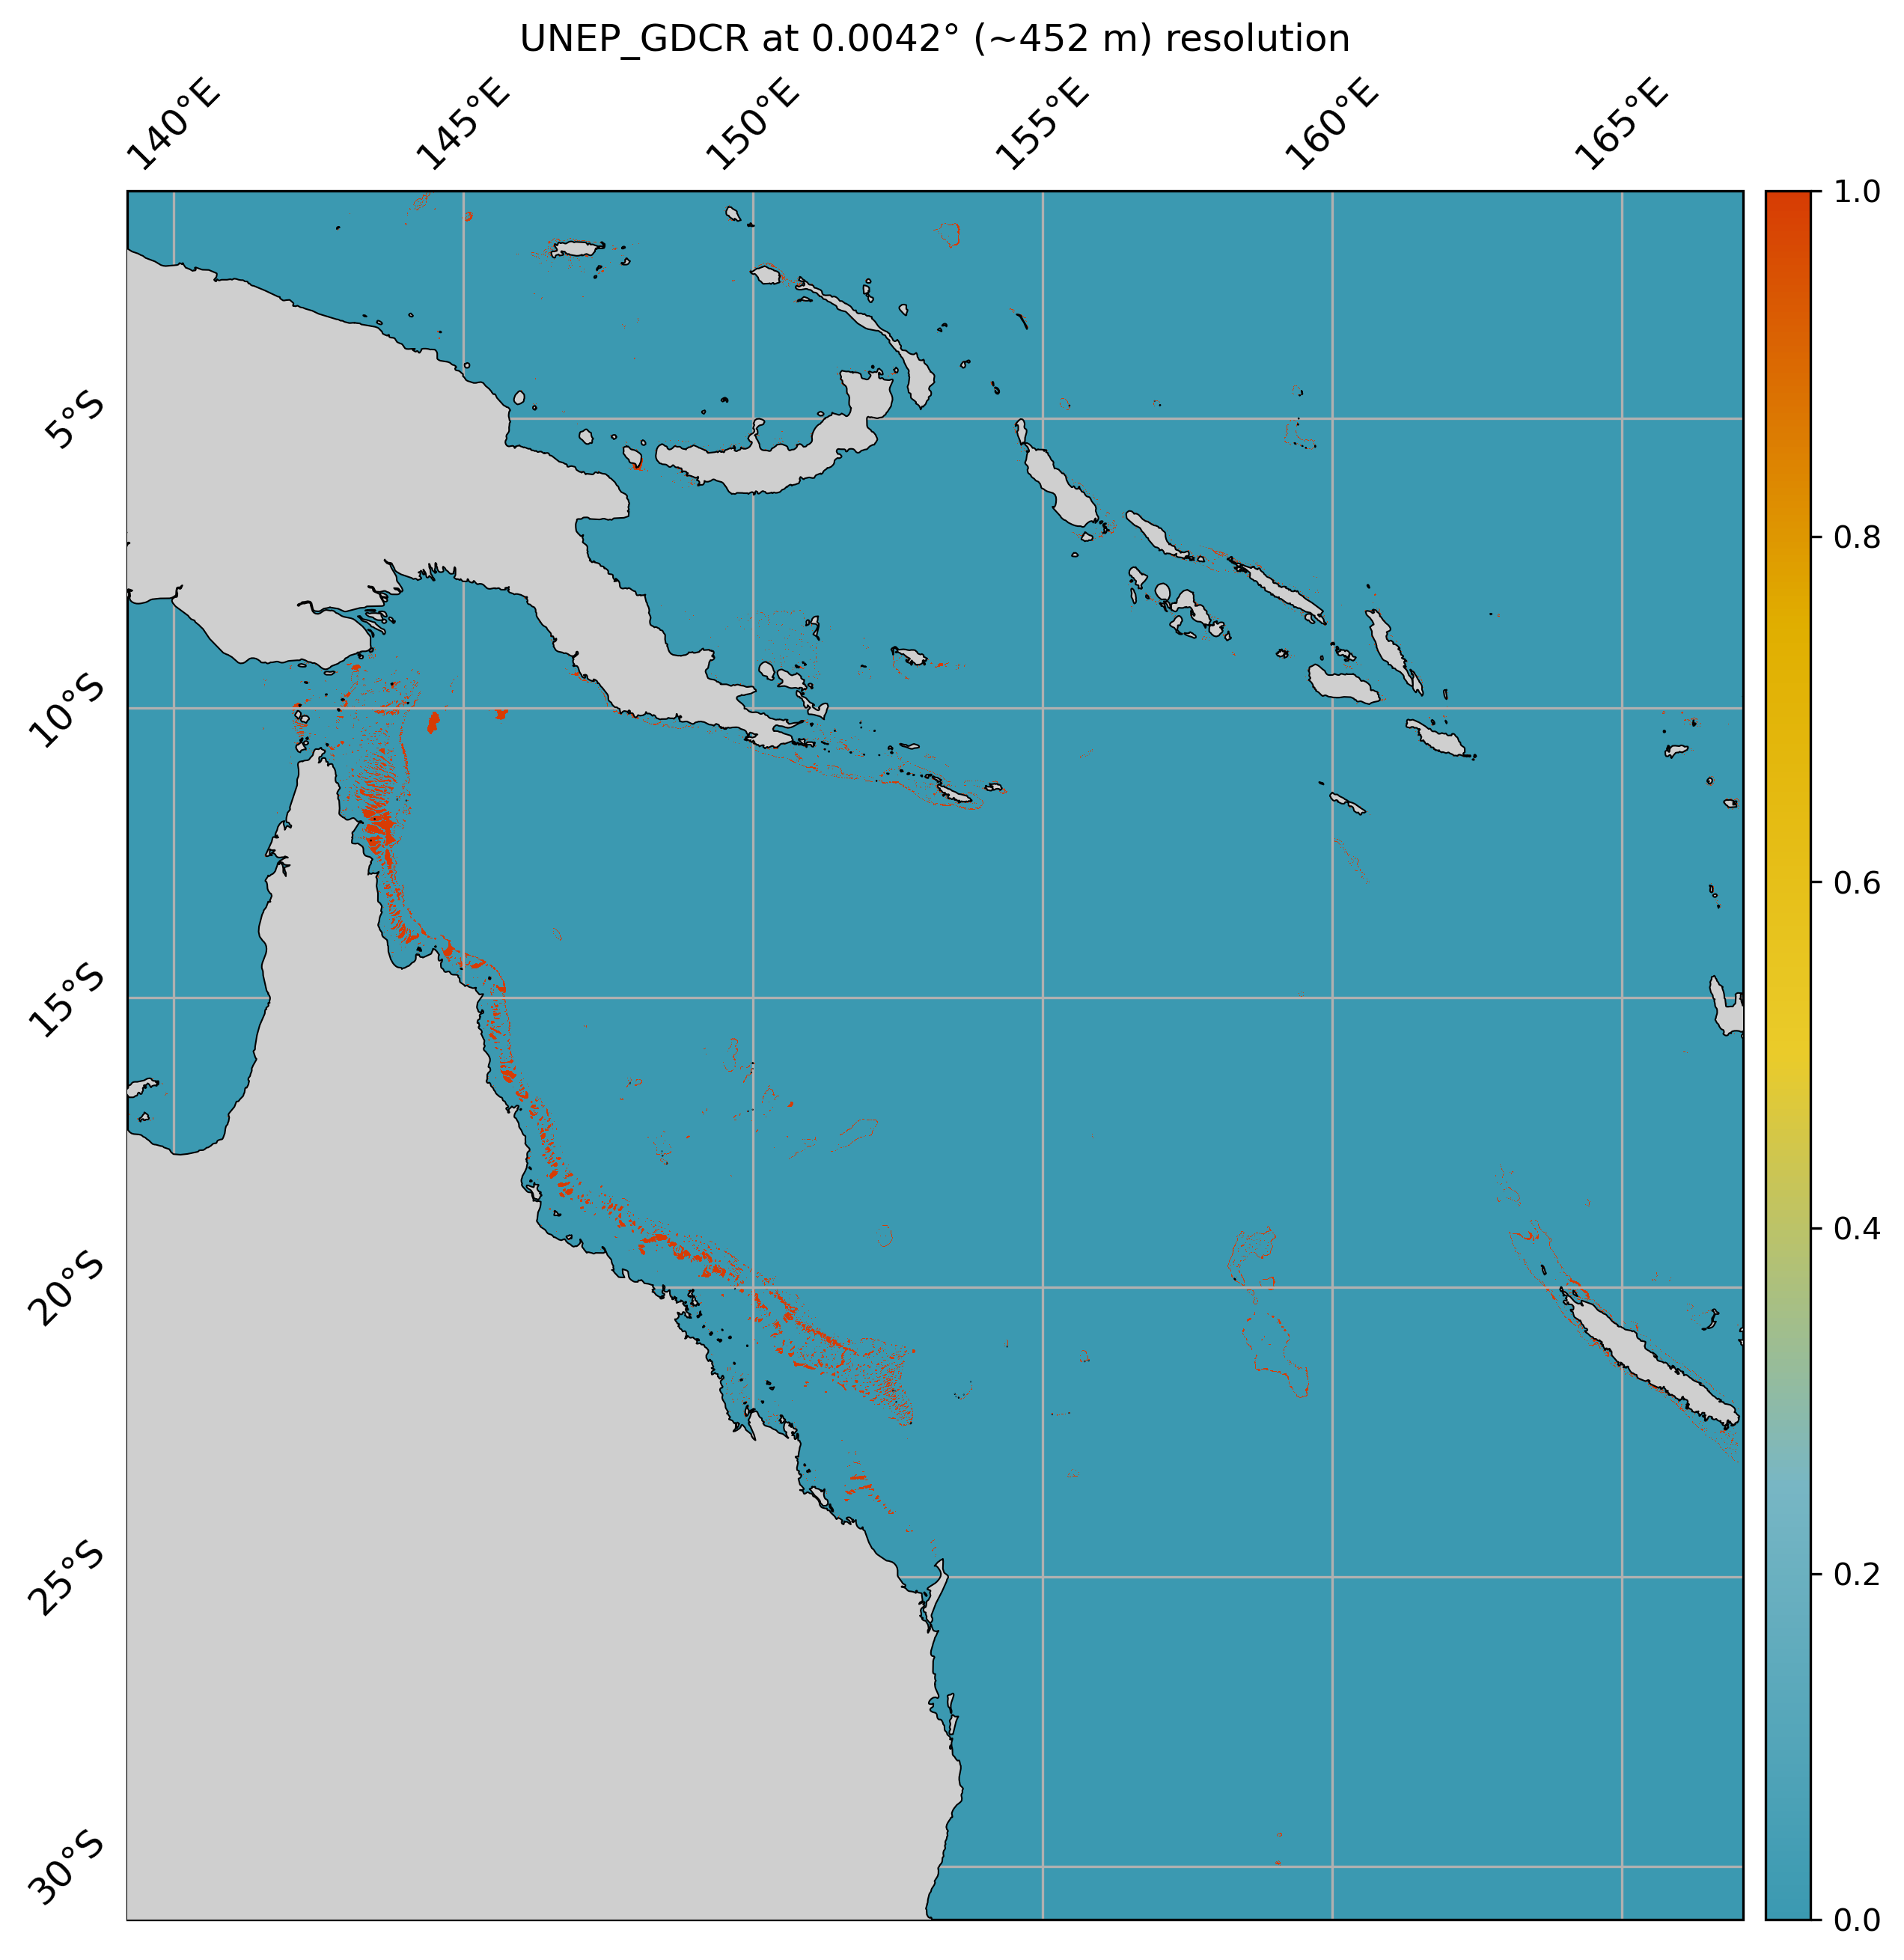

In [36]:
spatial_plots.plot_spatial(gt_raw["UNEP_GDCR"])

In [57]:
# investigate effect of resampling
gt_resampled = get_data.ReturnRaster(config).get_resampled_raster(gt_raw, "unep")

	resampling dataset to 0.01 degree(s) resolution...



(<Figure size 3000x3000 with 2 Axes>,
 <GeoAxes: title={'center': 'UNEP_GDCR at 0.0100° (~1085 m) resolution'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7fee90884ec0>)

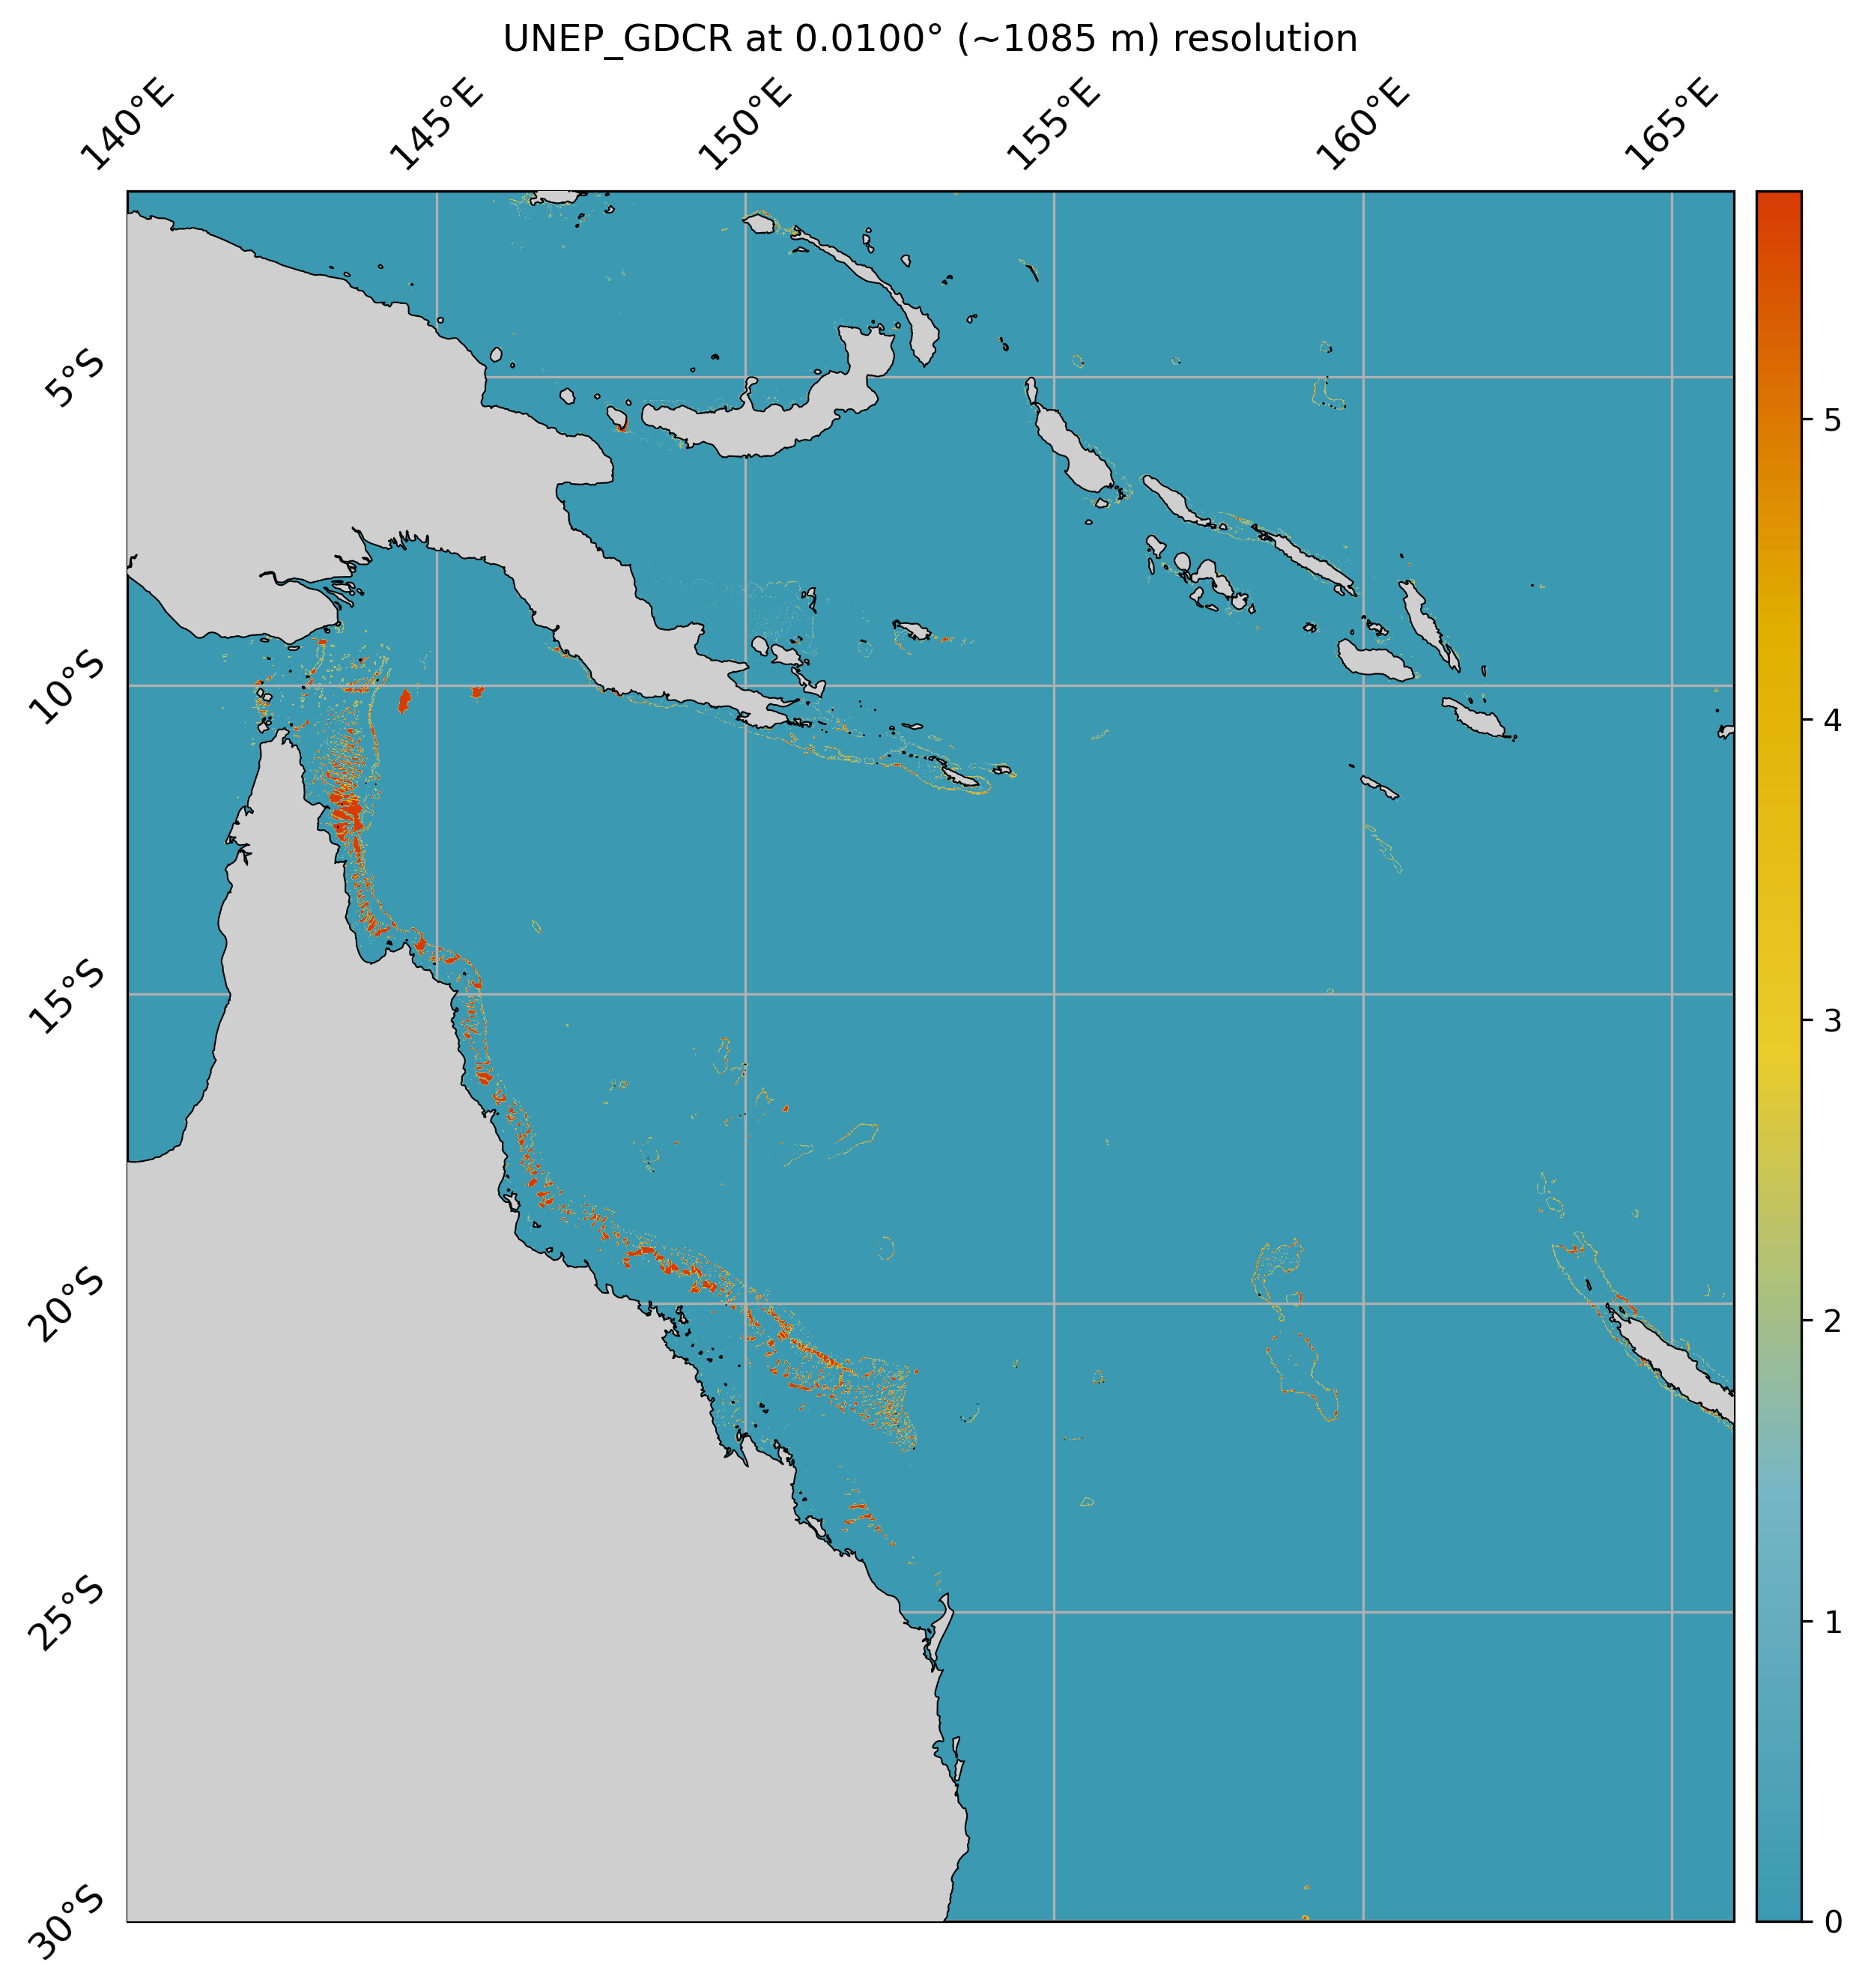

In [38]:
spatial_plots.plot_spatial(gt_resampled["UNEP_GDCR"])

In [42]:
gt_resampled_1 = get_data.ReturnRaster(config, resolution=1).get_resampled_raster(gt_raw, "unep")

	resampling dataset to 1 degree(s) resolution...



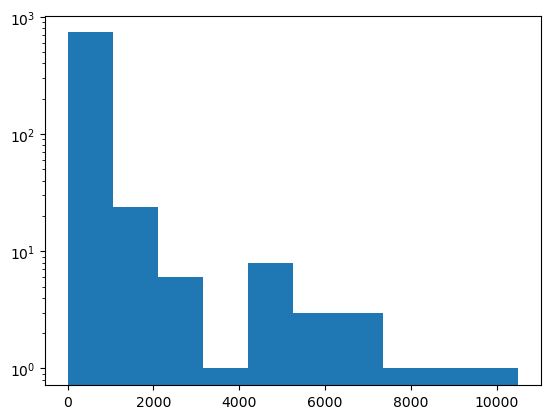

In [43]:
plt.hist(gt_resampled_1["UNEP_GDCR"].values.flatten())
plt.yscale("log")

In [51]:
gt_resampled_1["UNEP_GDCR"].sel(latitude=slice(-4,2), longitude=slice(150,152))

<xarray.DataArray 'UNEP_GDCR' (latitude: 3, longitude: 3)> Size: 72B
array([[   0.        ,   35.92228124,  383.70147132],
       [ 229.57687735, 1060.9371972 ,  176.86632017],
       [ 711.77015063,   14.72754693,    0.        ]])
Coordinates:
  * longitude    (longitude) float64 24B 150.0 151.0 152.0
  * latitude     (latitude) float64 24B -4.0 -3.0 -2.0
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:  1.7976931348623157e+308

0.004123887086222207


(<Figure size 1000x1000 with 4 Axes>,
 <GeoAxes: title={'center': 'UNEP_GDCR at 0.0100° (~1085 m) resolution'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7fee94c294f0>)

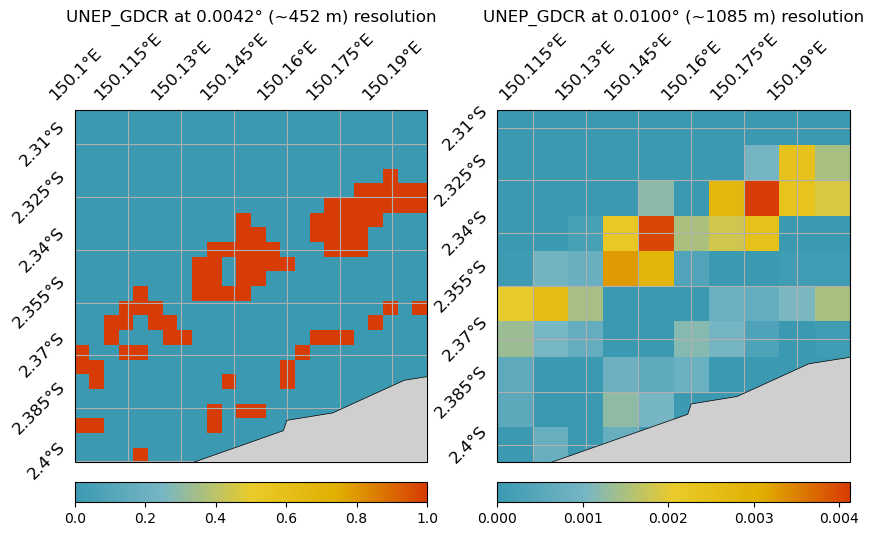

In [76]:
aoi_lats = (-2.4,-2.3)
aoi_lons = (150.1,150.2)

fig, ax = plt.subplots(1,2,figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})

spatial_plots.plot_spatial(gt_raw["UNEP_GDCR"].sel(latitude=slice(min(aoi_lats), max(aoi_lats)), longitude=slice(min(aoi_lons), max(aoi_lons))), cbar_dict={'orientation': 'horizontal'}, fax=(fig, ax[0]))

resampled_raster = gt_resampled.sel(latitude=slice(min(aoi_lats), max(aoi_lats)), longitude=slice(min(aoi_lons), max(aoi_lons)))
lat_res, lon_res = abs(resampled_raster.rio.resolution()[0]), abs(resampled_raster.rio.resolution()[1])
cell_area = lat_res * lon_res   # in degrees
cell_area = cell_area * 110e3**2 * np.cos(np.mean(resampled_raster.latitude) * np.pi / 180)  # in m^2

# number of 30x30m cells in cell
num_30 = cell_area / 30**2
# coverage density
test = resampled_raster / num_30
print(test["UNEP_GDCR"].values.max())

# resampled_raster = 30**2 * resampled_raster / cell_area     # area of single observation of unep
# test = 30**2 * resampled_raster / cell_area
# test = gt_resampled.sel(latitude=slice(min(aoi_lats), max(aoi_lats)), longitude=slice(min(aoi_lons), max(aoi_lons)))

spatial_plots.plot_spatial(test["UNEP_GDCR"], cbar_dict={'orientation': 'horizontal'}, fax=(fig, ax[1]))

(<Figure size 3000x3000 with 2 Axes>,
 <GeoAxes: title={'center': 'UNEP_GDCR at 0.0100° (~1085 m) resolution'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7fee90f46cf0>)

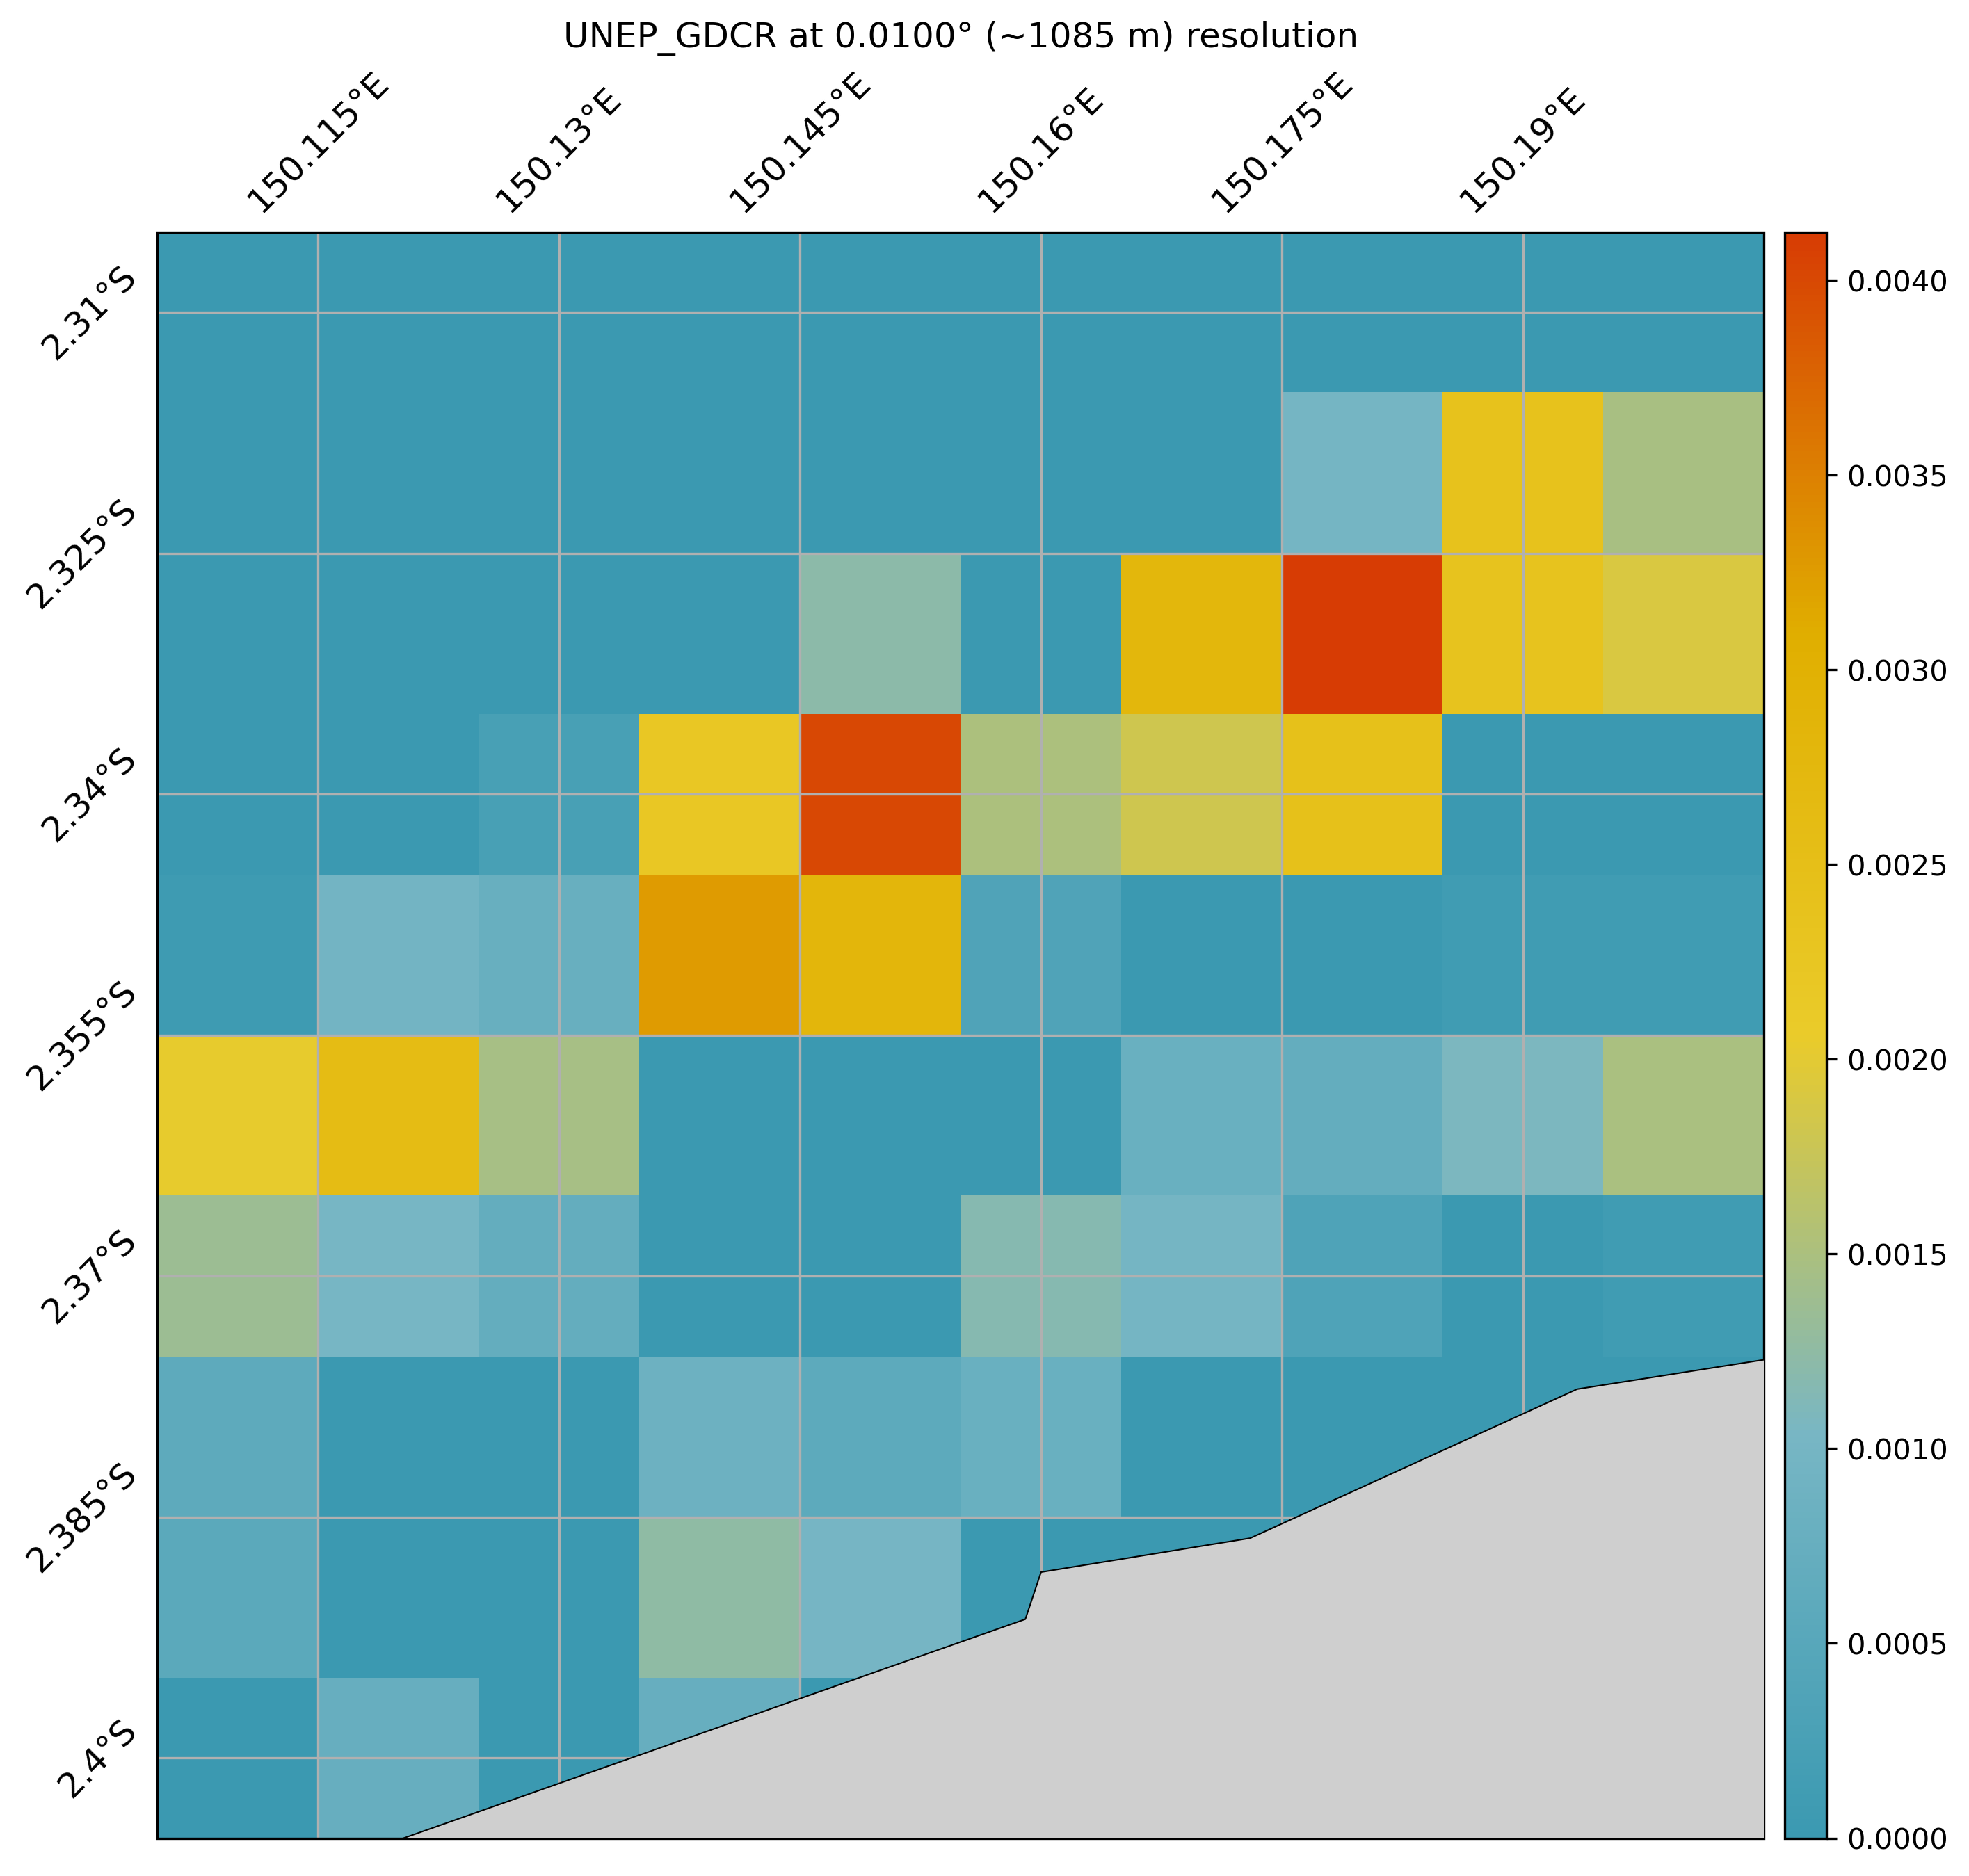

In [63]:
spatial_plots.plot_spatial(test["UNEP_GDCR"])

(<Figure size 3000x3000 with 2 Axes>,
 <GeoAxes: title={'center': 'UNEP_GDCR at 1.0000° (~108474 m) resolution'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7fef126b6cf0>)

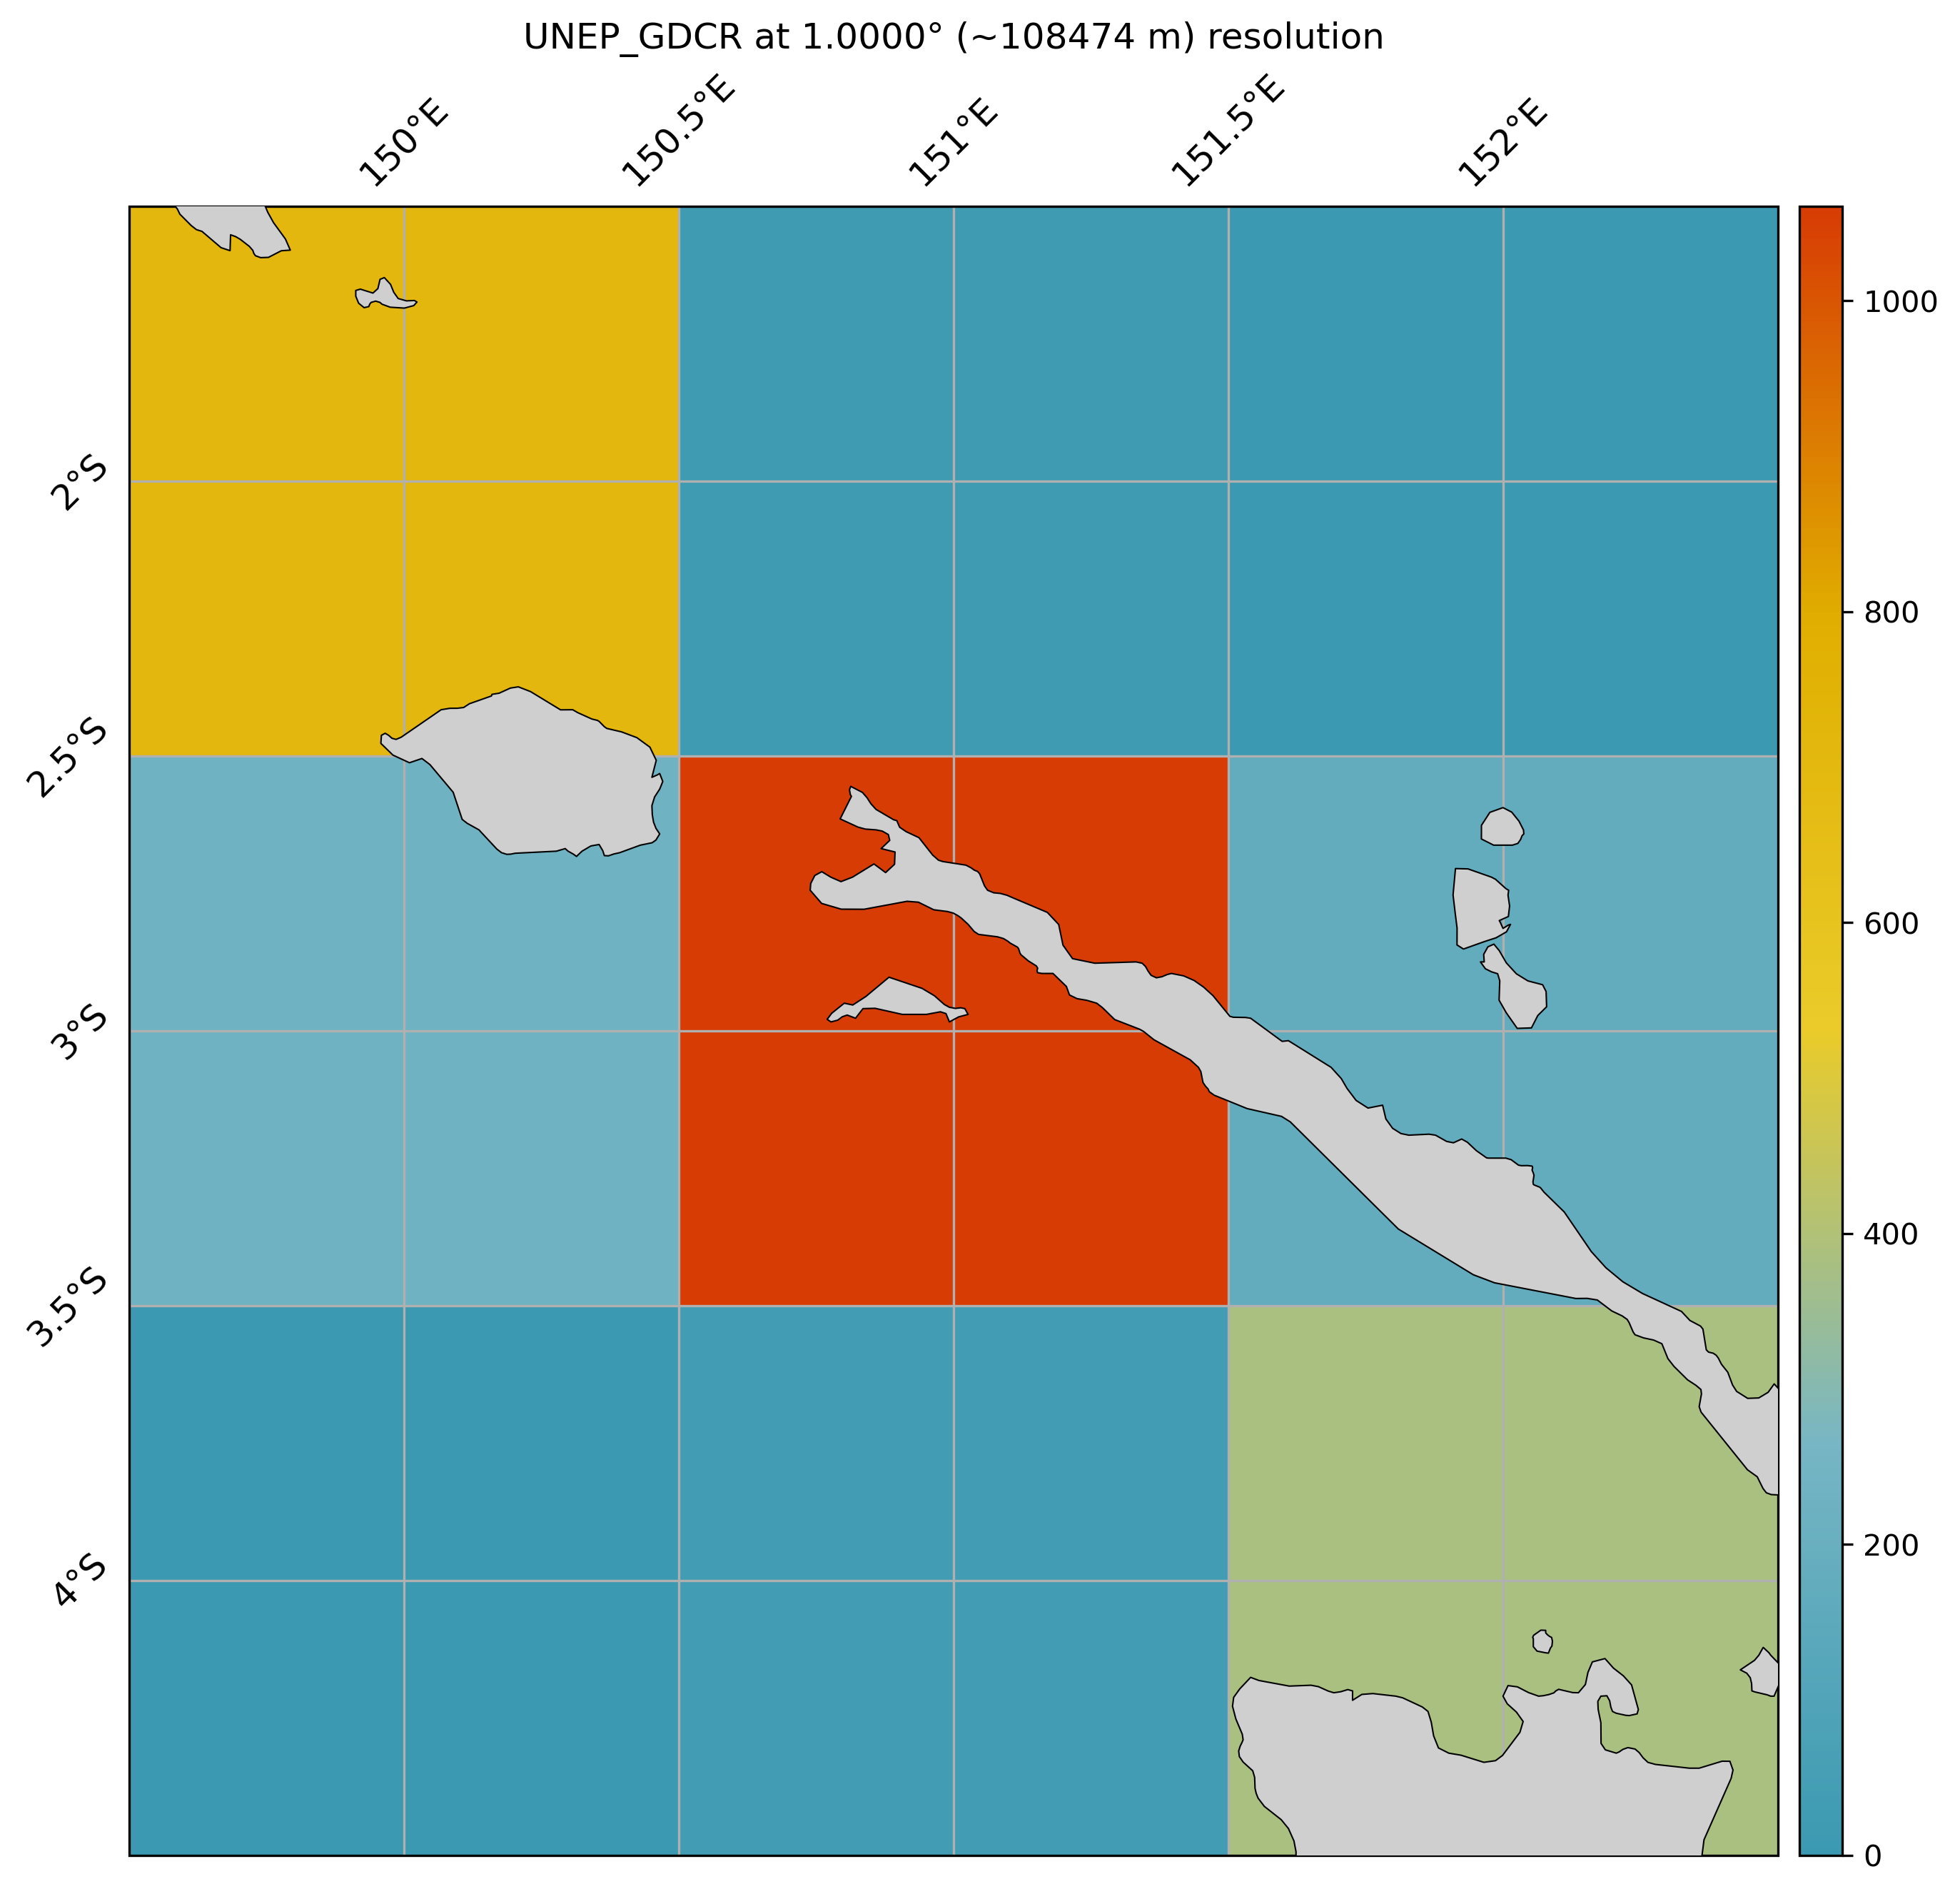

In [52]:
spatial_plots.plot_spatial(gt_resampled_1["UNEP_GDCR"].sel(latitude=slice(-4,2), longitude=slice(150,152)))

In [2]:
config_info["resolution"] = 0.01
gt_0_01 = get_data.ReturnRaster(config_info=config_info).return_raster(dataset="unep")

Loading UNEP_GDCR xarray at 0.004 degrees resolution.
loading from /maps-priv/maps/rt582/coralshift/data/ground_truth/UNEP_GDCR/rasters/unep_0-004_S90-1_N90-1_W180-1_E180-1.nc
	applying spatial buffering...
1 raster(s) to spatially buffer...


Buffering variables: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


	resampling dataset to 0.01 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326


In [11]:
config_info["resolution"] = 0.1
gt_0_1 = get_data.ReturnRaster(config_info=config_info).return_raster(dataset="unep")

Loading UNEP_GDCR xarray at 0.004 degrees resolution.
loading from /maps-priv/maps/rt582/coralshift/data/ground_truth/UNEP_GDCR/rasters/unep_0-004_S90-1_N90-1_W180-1_E180-1.nc
	applying spatial buffering...
1 raster(s) to spatially buffer...


Buffering variables: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


	resampling dataset to 0.1 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326


In [9]:
config_info["resolution"] = 1

gt_1 = get_data.ReturnRaster(config_info=config_info).return_raster(dataset="unep")

Loading UNEP_GDCR xarray at 0.004 degrees resolution.
loading from /maps-priv/maps/rt582/coralshift/data/ground_truth/UNEP_GDCR/rasters/unep_0-004_S90-1_N90-1_W180-1_E180-1.nc
	applying spatial buffering...
1 raster(s) to spatially buffer...


Buffering variables: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


	resampling dataset to 1 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326


(<Figure size 2000x1000 with 4 Axes>,
 <GeoAxes: title={'center': 'UNEP_GDCR at 0.1000° (~10847 m) resolution'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7f946fe03a10>)

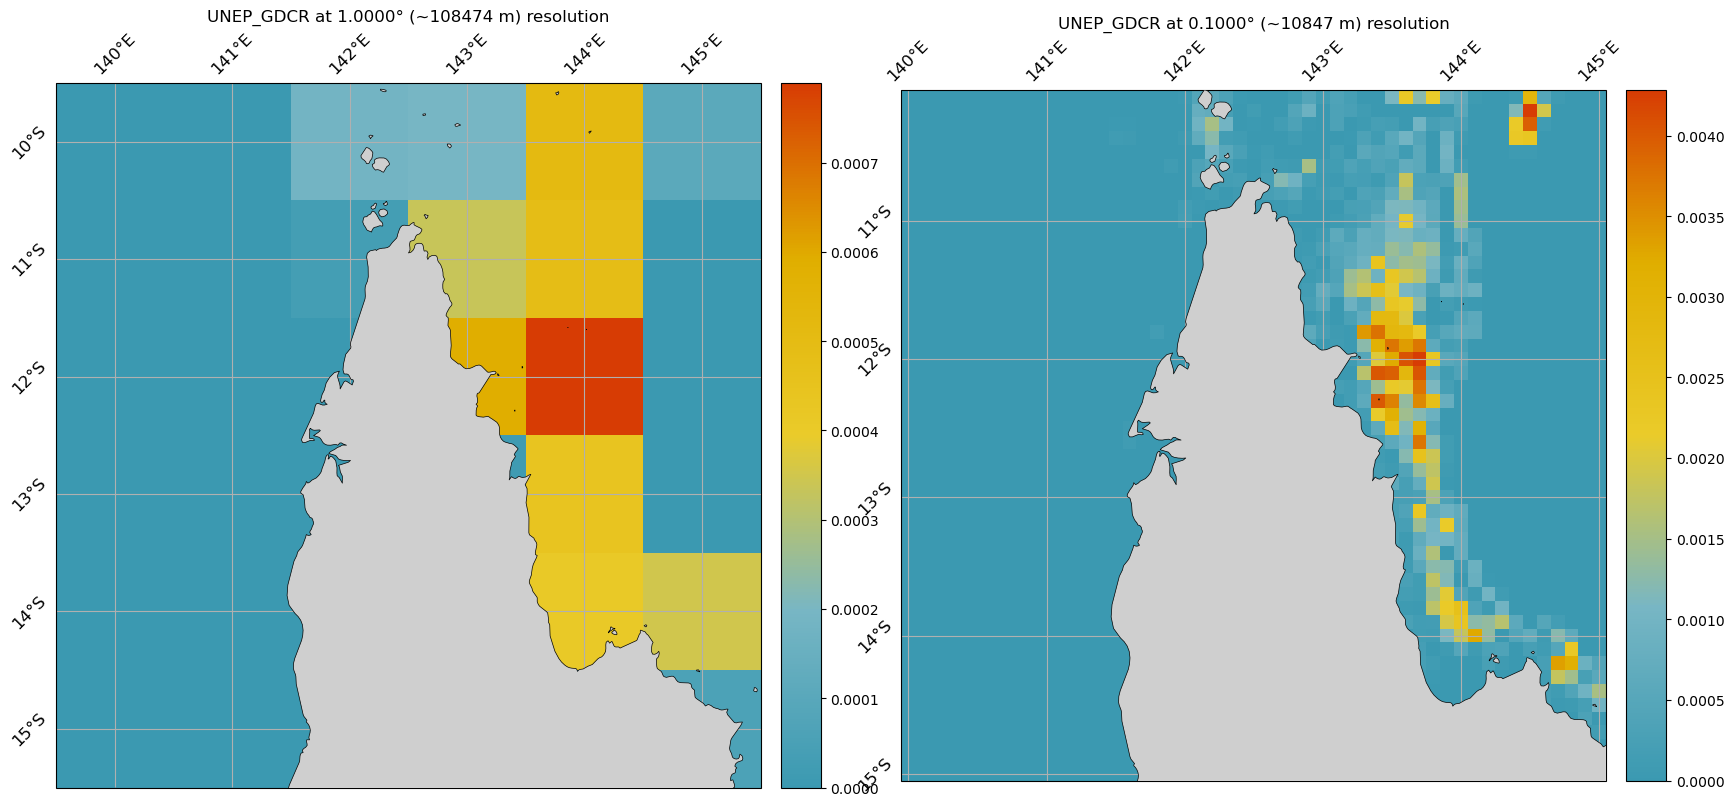

In [12]:
fig, ax = plt.subplots(ncols=2, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=[20,10])

spatial_plots.plot_spatial(gt_1["UNEP_GDCR"].sel(latitude=slice(-15,-10), longitude=slice(140,145)), fax=(fig,ax[0]))
spatial_plots.plot_spatial(gt_0_1["UNEP_GDCR"].sel(latitude=slice(-15,-10), longitude=slice(140,145)), fax=(fig,ax[1]))


In [24]:
lr_cell.values.flatten()

array([0.00048834])

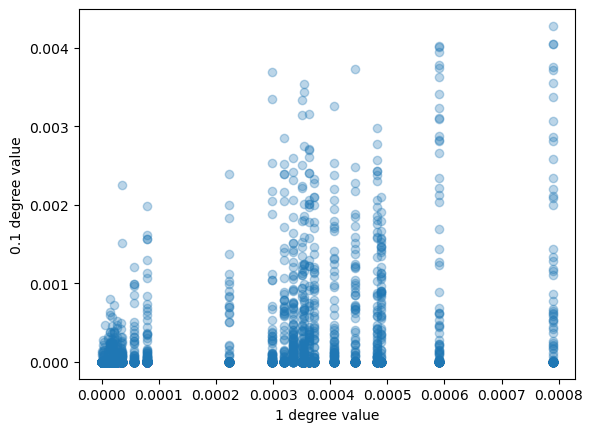

In [31]:
lim_lats = (-20,-10)
lim_lons = (140,150)
lr_res = 1

# Define the range of low-resolution cells
low_res_lats = np.arange(min(lim_lats), max(lim_lats), lr_res)  # Example range, adjust as needed
low_res_lons = np.arange(min(lim_lons), max(lim_lons), lr_res)  # Example range, adjust as needed

# Initialize lists to store values
hr_cell_vals = []
lr_cell_vals = []

# Extract high-resolution and low-resolution cells for each pair of lat/lon
for lat in low_res_lats:
    for lon in low_res_lons:
        # Define the high-resolution cell boundaries
        test_cell_lats = [lat - lr_res/2, lat + lr_res/2]
        test_cell_lons = [lon - lr_res/2, lon + lr_res/2]
        hr_cell = gt_0_1["UNEP_GDCR"].sel(latitude=slice(min(test_cell_lats), max(test_cell_lats)), longitude=slice(min(test_cell_lons), max(test_cell_lons)))
        lr_cell = gt_1["UNEP_GDCR"].sel(latitude=slice(min(test_cell_lats), max(test_cell_lats)), longitude=slice(min(test_cell_lons), max(test_cell_lons)))
        
        hr_cell_vals.extend(hr_cell.values.flatten())
        lr_cell_vals.extend(np.repeat(lr_cell.values.flatten(), len(hr_cell.values.flatten())))
        
# Convert lists to numpy arrays
hr_cell_vals = np.array(hr_cell_vals)
lr_cell_vals = np.array(lr_cell_vals)

# Plot the value of the low-resolution cell against all the high-resolution values
fig, ax = plt.subplots()
ax.scatter(lr_cell_vals, hr_cell_vals, alpha=0.3)
ax.set_xlabel("1 degree value")
ax.set_ylabel("0.1 degree value")
plt.show()

(<Figure size 3000x3000 with 2 Axes>,
 <GeoAxes: title={'center': 'UNEP_GDCR at 0.0100° (~1085 m) resolution'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7f2377620140>)

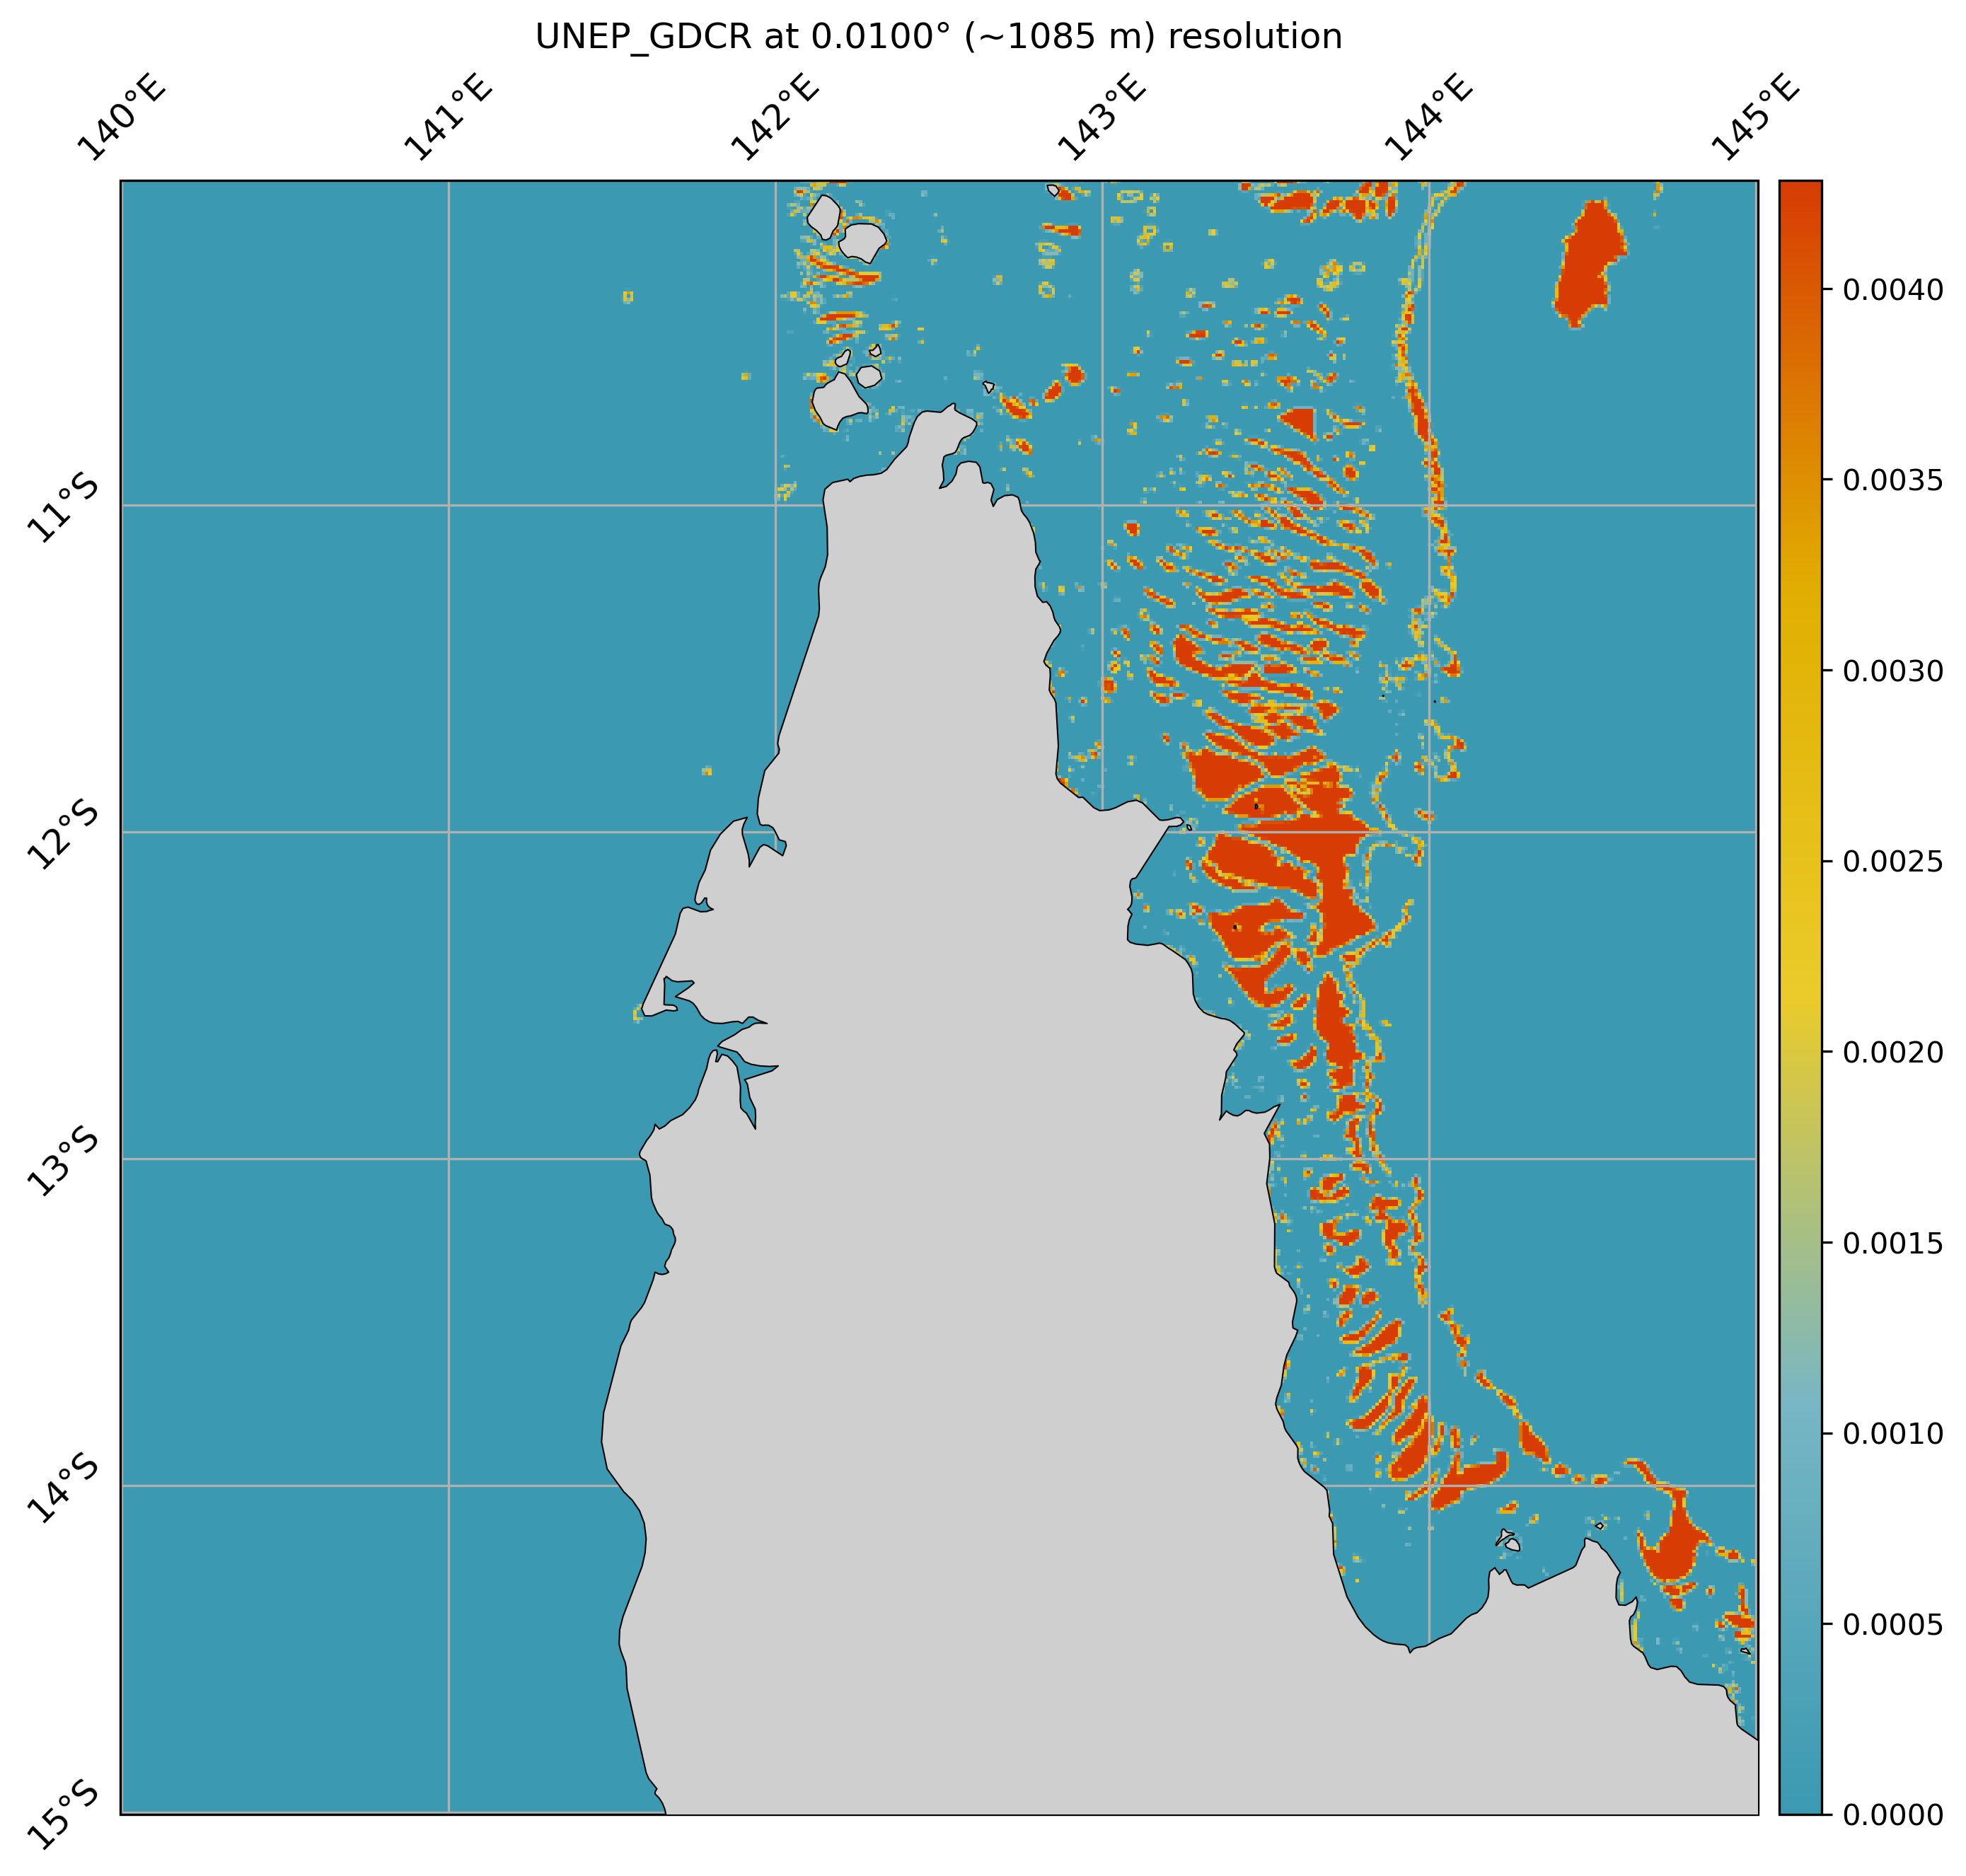

In [53]:
spatial_plots.plot_spatial(new_gt["UNEP_GDCR"].sel(latitude=slice(-15,-10), longitude=slice(140,145)))

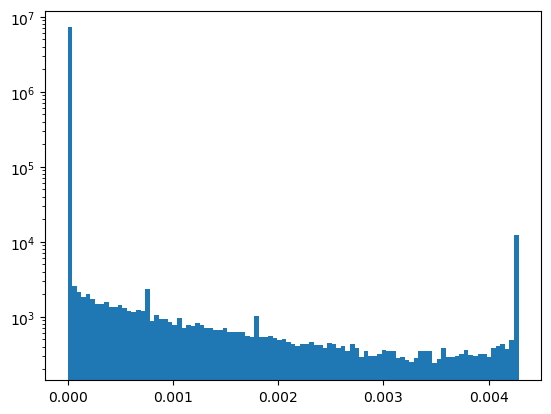

In [54]:
plt.hist(new_gt["UNEP_GDCR"].values.flatten(), bins=np.linspace(0,np.max(new_gt["UNEP_GDCR"].sel(latitude=slice(-15,-10), longitude=slice(140,145)).values),100))
plt.yscale("log")


In [ ]:
config_info["lats"]


[-30, -2]

(<Figure size 3000x3000 with 2 Axes>,
 <GeoAxes: title={'center': 'Ground Truth'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7f23763fe990>)

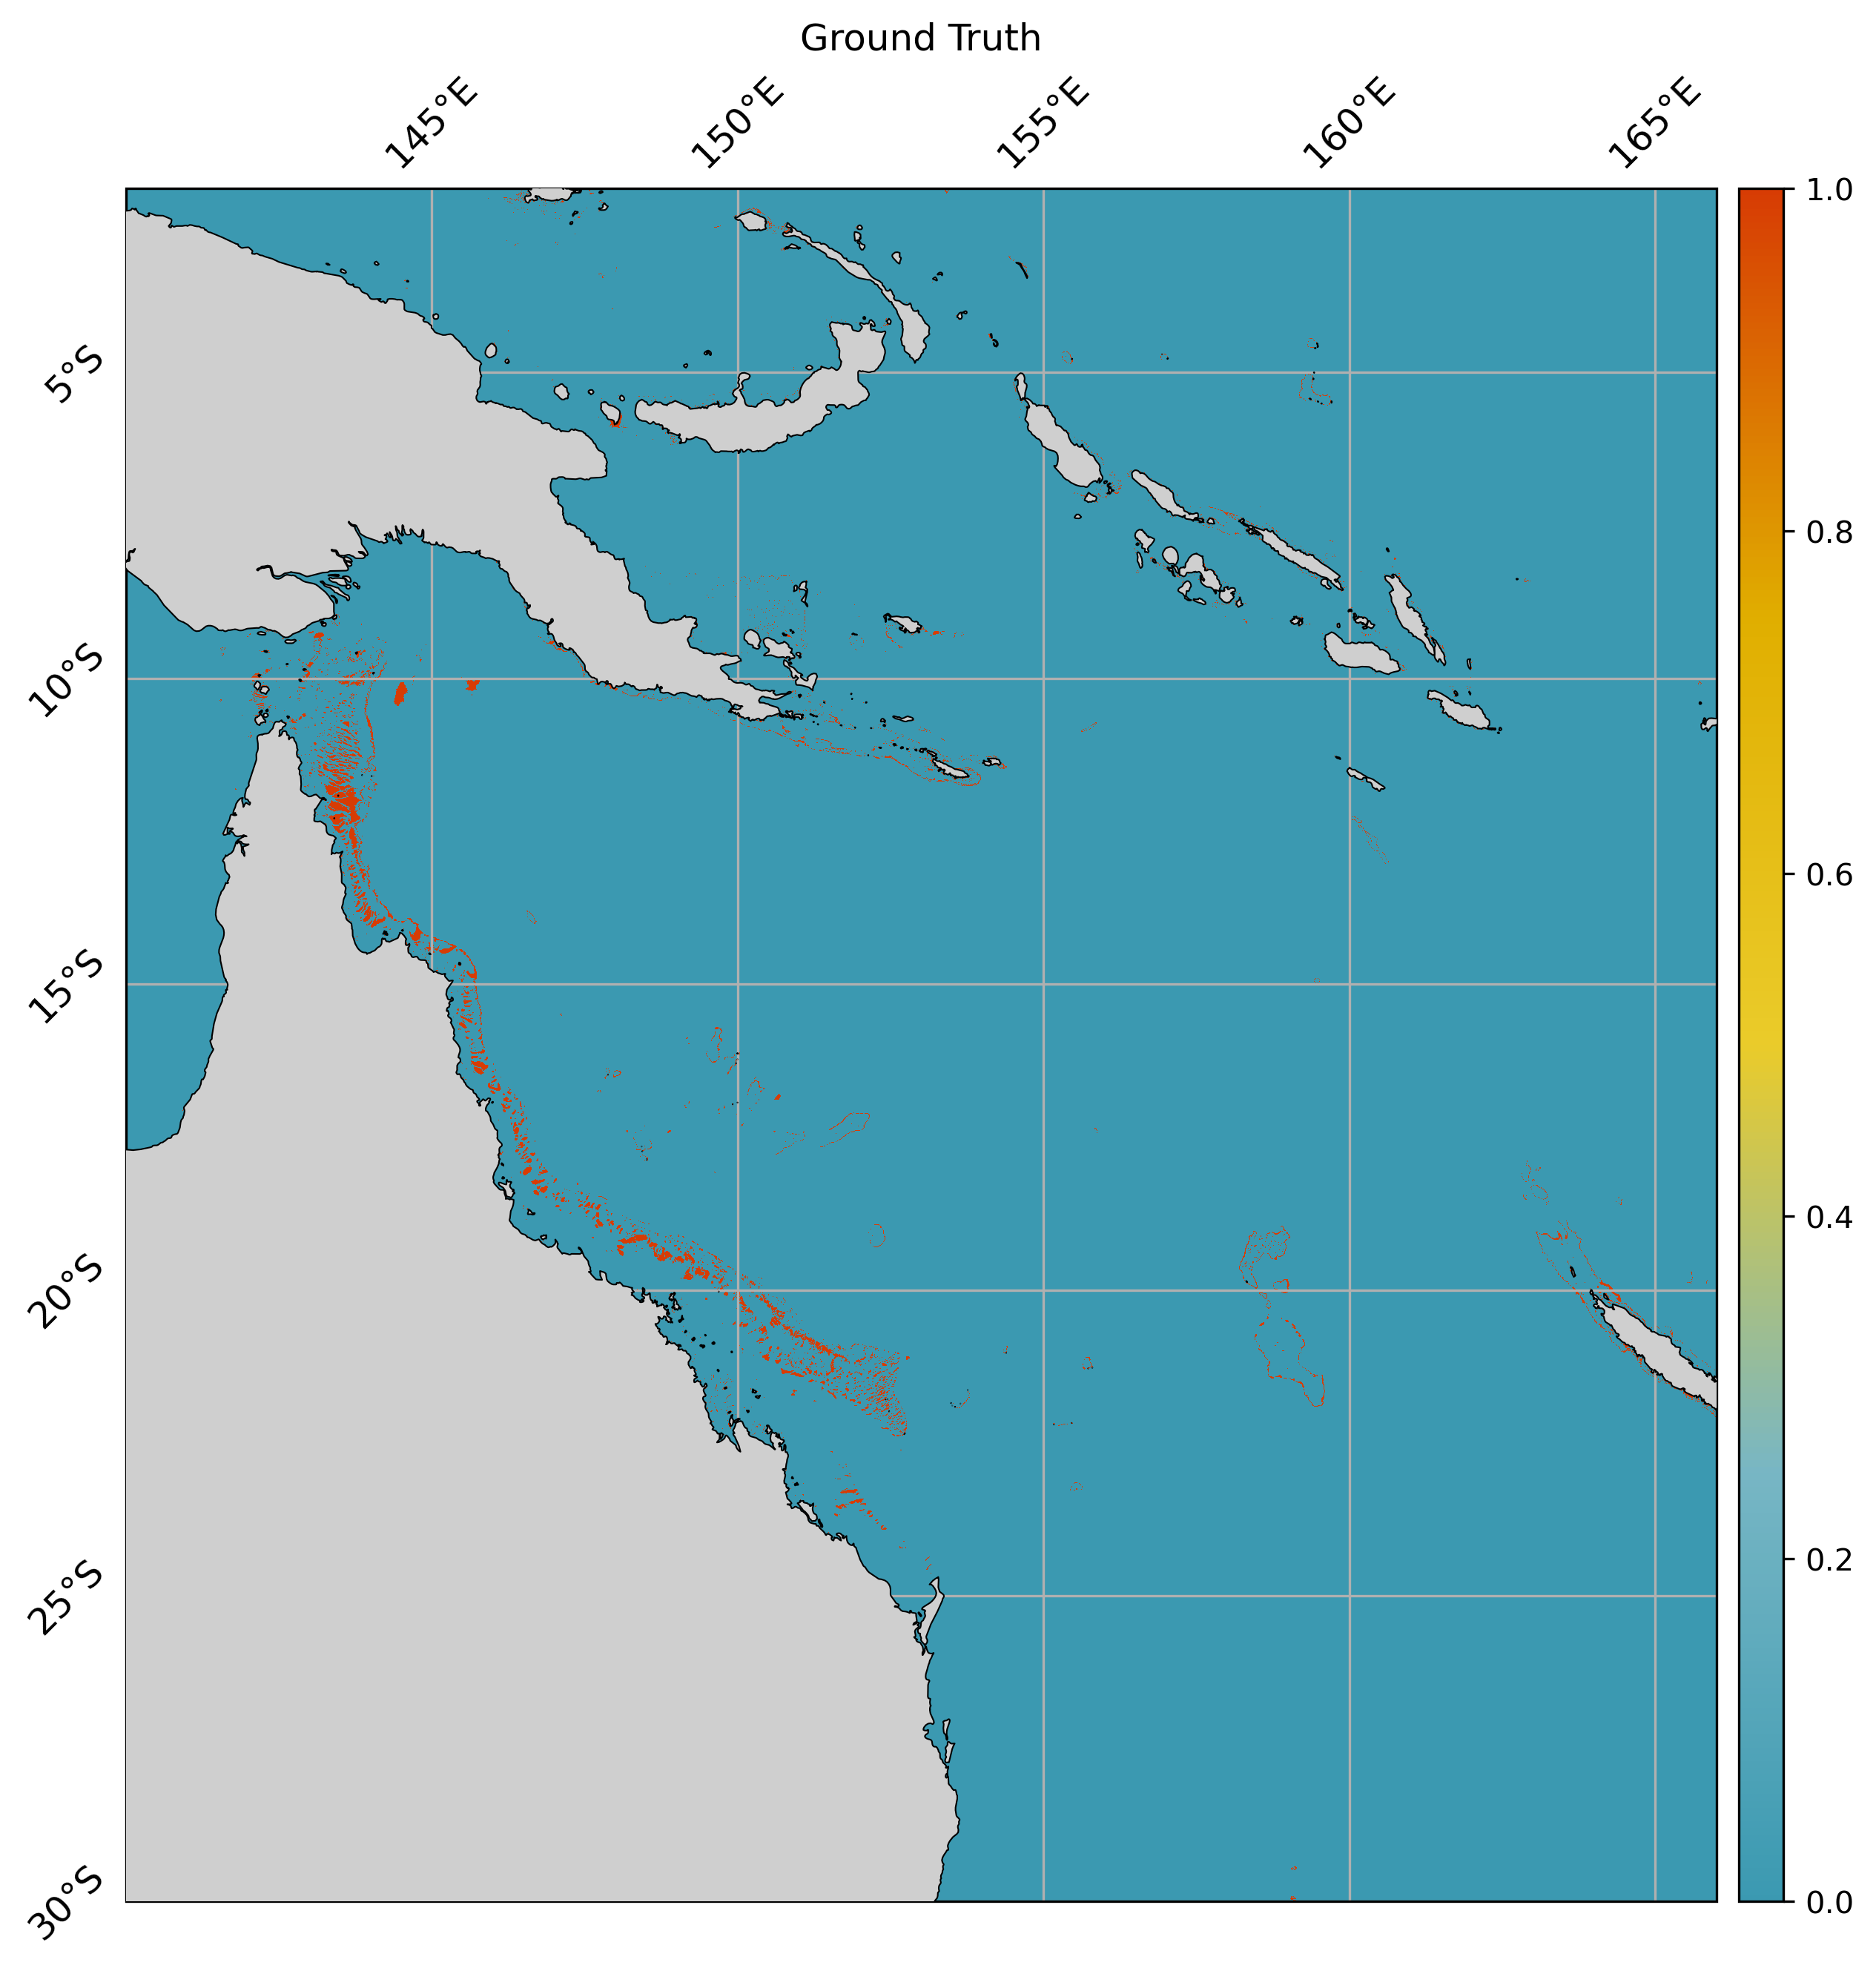

In [39]:
gt = xa.open_dataset("/maps/rt582/coralshift/data/ground_truth/UNEP_GDCR/rasters/unep_0-004_S90-1_N90-1_W180-1_E180-1.nc")["UNEP_GDCR"]
gt_aoi = gt.sel(latitude=slice(config_info["lats"][0], config_info["lats"][1]), longitude=slice(config_info["lons"][0], config_info["lons"][1]))
spatial_plots.plot_spatial(gt_aoi, title="Ground Truth")

(<Figure size 3000x3000 with 2 Axes>,
 <GeoAxes: title={'center': 'unep_coral_presence at 0.0042° (~452 m) resolution'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7f22e29a6a50>)

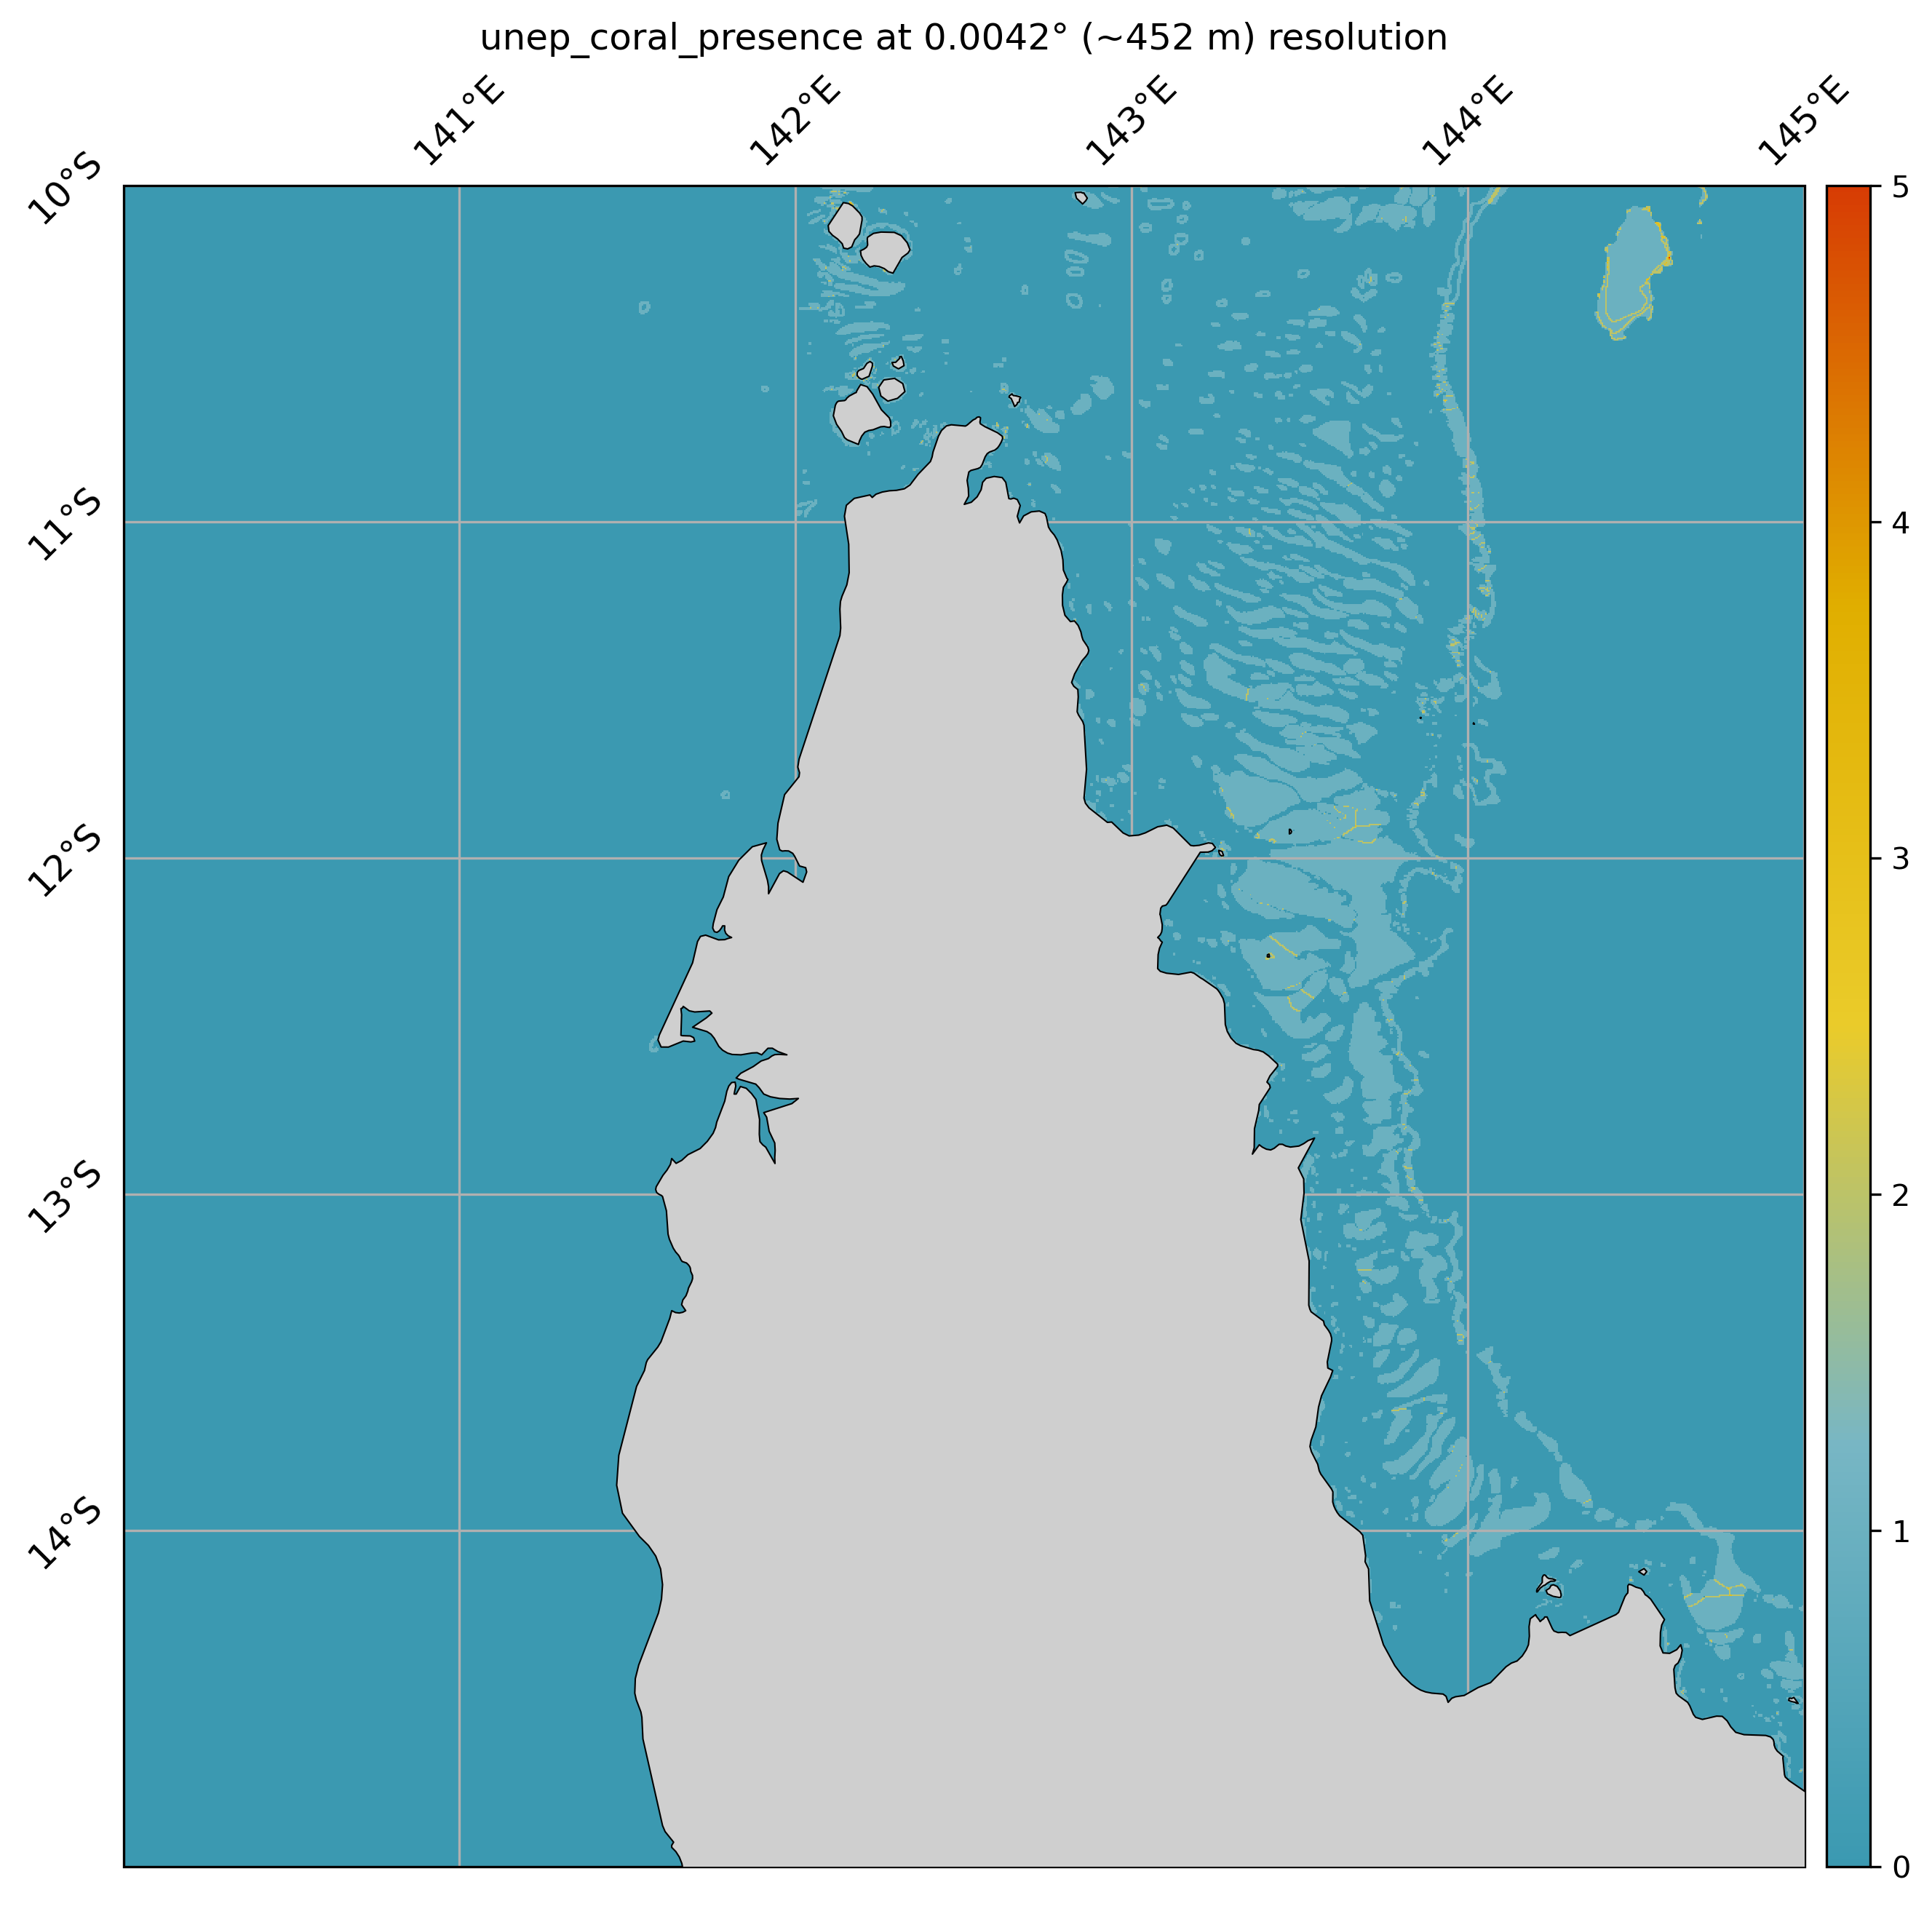

In [27]:
spatial_plots.plot_spatial(gt_aoi.sel(latitude=slice(-15,-10), longitude=slice(140,145)))

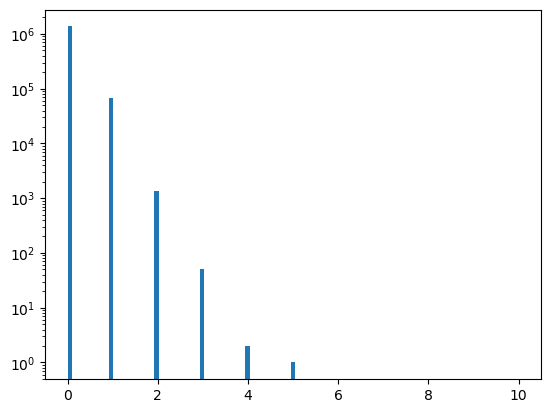

In [32]:
plt.hist(gt_aoi.sel(latitude=slice(-15,-10), longitude=slice(140,145)).values.flatten(), bins=np.linspace(0, 10, 100))
plt.yscale("log")

In [13]:
config_info

{'data_source': 'asdf',
 'regressor_classification_threshold': 0.01,
 'depth_mask': [-1000, 10],
 'ds_type': 'static',
 'predictand': 'UNEP_GDCR',
 'datasets': ['cmip6', 'unep'],
 'env_vars': ['tos'],
 'random_state': 42,
 'resolution': 0.01,
 'resolution_unit': 'd',
 'year_range_to_include': [1950, 2015],
 'upsample_method': 'linear',
 'downsample_method': 'mean',
 'spatial_buffer': 10,
 'save_figs': True,
 'do_train': True,
 'do_save_model': True,
 'do_plot': True,
 'processing': {'do_crop': False},
 'lats': [-30, -2],
 'lons': [140, 166],
 'levs': [0, 20],
 'split_type': 'spatial',
 'test_geom': [-16, -10, 140, 160],
 'train_test_val_frac': [0.8, 0.2, 0],
 'X_scaler': 'standard',
 'y_scaler': 'minmax',
 'hyperparameter_search': {'cv_folds': 5,
  'n_samples': -1,
  'n_iter': 100,
  'type': 'random',
  'do_search': False,
  'n_trials': 5,
  'search_types': ['random'],
  'n_jobs': 8},
 'source_id': 'EC-Earth3P-HR',
 'member_id': 'r1i1p2f1'}

In [14]:
get_data.ReturnRaster(config_info).return_raster()

TypeError: 'NoneType' object is not subscriptable

# XGBoost results from different splitting methods

In [2]:
# make dummy data: checkerboard of 1s and 0s
resolution = 180/1800
data = np.zeros((181, 181))
data[::2, 1::2] = 1
data[1::2, ::2] = 1

# cast data to dataframe (input to get_checkerboard_train_test_data)
# index should be multiindex of "latitude" and "longitude"
lats = np.linspace(-90, 90, 181)
lons = np.linspace(-90, 90, 181)

multiindex = pd.MultiIndex.from_product([lats, lons], names=["latitude", "longitude"])
# column should be "value"
data_df = pd.DataFrame(data.flatten(), index=multiindex, columns=["value"])
data_df.head()

value
latitude longitude       
-90.0    -90.0        0.0
         -89.0        1.0
         -88.0        0.0
         -87.0        1.0
         -86.0        0.0

In [2]:
config_info["resolution"] = 0.01
test_cell_size = 5  # does this matter?
test_train_ratio = config_info["train_test_val_frac"][1]
gt = config_info["predictand"]
# get all processed data
(trains, tests, vals), ds_info = ml_processing.ProcessMLData(config_info=config_info).generate_ml_ready_data()
# recombine trains and tests to get full dataset
all_df = pd.concat(
    [pd.concat([trains[0], trains[1].rename(gt)], axis=1), pd.concat([tests[0], tests[1].rename(gt)], axis=1)])

buffer = ml_processing.calculate_test_cell_buffer(test_cell_size, test_train_ratio)
# calculate necessary shifts to cover ffull
lat_shifts = np.arange(0, 2*test_cell_size, 2*buffer) 
lon_shifts = np.arange(0, test_cell_size, 2*buffer)

# XGboost params
params = {'objective': 'reg:squarederror', 'n_estimators': 945, 'max_depth': 31, 'eval_metric': 'rmse', 'colsample_bytree': 0.29999999999999993}
num_rounds = 1000


predictions = []

for i in lat_shifts:
    for j in lon_shifts:
        # vertical scan
        ctrains, ctests = ml_processing.get_checkerboard_train_test_data(all_df, test_cell_size, test_train_ratio, initialisation=(i,j))
        # TODO: perform ML here
        X_trains = ctrains.drop(columns=[gt])
        y_trains = ctrains[gt]
        X_tests = ctests.drop(columns=[gt])
        y_tests = ctests[gt]

        dtrain = xgb.DMatrix(X_trains, y_trains)
        dtest = xgb.DMatrix(X_tests, y_tests)
        evals = [(dtrain, "train"), (dtest, "validation")]

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_rounds,
            evals=evals,
            verbose_eval=100,
            early_stopping_rounds=50
            )
        preds = pd.Series(model.predict(dtest), ctests.index, name=gt)
        # TODO: overwrite rather than build this up
        predictions.append(preds)
        combined_preds = pd.concat(predictions, axis=1).mean(axis=1).rename(gt)

#         tests_df = pd.concat(all_tests, axis=1).mean(axis=1).rename("value")

Searching for correct CMIP files in: /maps-priv/maps/rt582/coralshift/data/env_vars/cmip6/EC-Earth3P-HR/r1i1p2f1/regridded
	calculating statistics for static ML model(s)...


calculating statistics for variables: 100%|██████████| 9/9 [00:02<00:00,  4.15it/s]


	applying spatial buffering...
360 raster(s) to spatially buffer...


Buffering variables: 100%|██████████| 360/360 [00:27<00:00, 12.92it/s]


	resampling dataset to 0.01 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326
Loading UNEP_GDCR xarray at 0.004 degrees resolution.
	applying spatial buffering...
1 raster(s) to spatially buffer...


Buffering variables: 100%|██████████| 1/1 [00:00<00:00, 12.97it/s]


	resampling dataset to 0.01 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326
Loading gebco elevation xarray across [-31, -1] latitudes & [139, 167] longitudes from /maps-priv/maps/rt582/coralshift/data/bathymetry/gebco/GEBCO_2023_n90-0_s90-0_w180-0_e180-0.nc.
	applying spatial buffering...
1 raster(s) to spatially buffer...


Buffering variables: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]

Transposing filled array to match the original shape.


	resampling dataset to 0.01 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326
Loading gebco elevation xarray across [-31, -1] latitudes & [139, 167] longitudes from /maps-priv/maps/rt582/coralshift/data/bathymetry/gebco/GEBCO_2023_n90-0_s90-0_w180-0_e180-0.nc.
calculating slopes from bathymetry...
	applying spatial buffering...
1 raster(s) to spatially buffer...


Buffering variables: 100%|██████████| 1/1 [00:08<00:00,  8.62s/it]

Transposing filled array to match the original shape.


	resampling dataset to 0.01 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326
	fitting scaler to X data...
	fitting scaler to y data...

	transforming data...


100%|██████████| 24/24 [00:00<00:00, 133.96it/s]
/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:20:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:0.11558	validation-rmse:0.14458
[53]	train-rmse:0.00032	validation-rmse:0.14827


100%|██████████| 24/24 [00:00<00:00, 127.66it/s]
/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:23:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:0.11298	validation-rmse:0.16029
[56]	train-rmse:0.00031	validation-rmse:0.16201


100%|██████████| 28/28 [00:00<00:00, 130.56it/s]
/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:26:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:0.11151	validation-rmse:0.16296
[58]	train-rmse:0.00031	validation-rmse:0.15881


100%|██████████| 28/28 [00:00<00:00, 124.82it/s]
/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:28:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:0.11736	validation-rmse:0.14040
[54]	train-rmse:0.00033	validation-rmse:0.14281


100%|██████████| 28/28 [00:00<00:00, 130.08it/s]
/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:31:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:0.11244	validation-rmse:0.16113
[53]	train-rmse:0.00031	validation-rmse:0.16153


100%|██████████| 28/28 [00:00<00:00, 132.74it/s]
/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:34:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:0.11926	validation-rmse:0.09292
[49]	train-rmse:0.00033	validation-rmse:0.09617


100%|██████████| 31/31 [00:00<00:00, 132.16it/s]
/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:37:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:0.11725	validation-rmse:0.13297
[51]	train-rmse:0.00031	validation-rmse:0.14547


100%|██████████| 31/31 [00:00<00:00, 132.80it/s]
/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:40:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:0.11770	validation-rmse:0.14099
[50]	train-rmse:0.00032	validation-rmse:0.15574


In [9]:
combined_preds.to_frame(name="prediction")

prediction
latitude longitude            
-30.00   153.42       0.000421
         153.43       0.000025
         153.44      -0.000019
         153.45       0.000301
         153.46       0.000288
...                        ...
-2.91    147.71       0.001284
         147.72       0.000320
         147.73       0.000366
         147.74       0.000367
         147.75       0.003087

[997937 rows x 1 columns]

In [14]:
pred_df = combined_preds.to_frame(name="prediction")

pred_df["prediction"].clip(0, 1)

1.0

In [2]:
gt = get_data.ReturnRaster(config_info=config_info).return_raster(dataset="unep")


Loading UNEP_GDCR xarray at 0.004 degrees resolution.
	applying spatial buffering...
1 raster(s) to spatially buffer...


Buffering variables: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s]


	resampling dataset to 0.01 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326


In [17]:
pred_df = combined_preds.to_frame(name="prediction")
# threshold predictions to 0 and 1
pred_df["prediction"] = pred_df["prediction"].clip(0, 1)
pred_ds = spatial_data.spatially_reform_data(pred_df, resolution=0.1)

gt = get_data.ReturnRaster(config_info=config_info).return_raster(dataset="unep")

interped_pred = pred_ds.interp_like(gt).rename({"UNEP_GDCR": "predictions"})
combined_preds_gt = xa.merge([interped_pred, gt])
# save to parquet
pred_df.to_parquet("/maps/rt582/coralshift/data/test_data/combined_ccheckerboard_test_predictions.parquet")

In [20]:
# in combined_preds_gt, make gt values nan where interped_pred is nan
combined_preds_gt["UNEP_GDCR"] = combined_preds_gt["UNEP_GDCR"].where(~np.isnan(combined_preds_gt["predictions"]))

(<Figure size 2000x1000 with 4 Axes>,
 <GeoAxes: title={'center': 'Predicted reef density'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7fe734e776b0>)

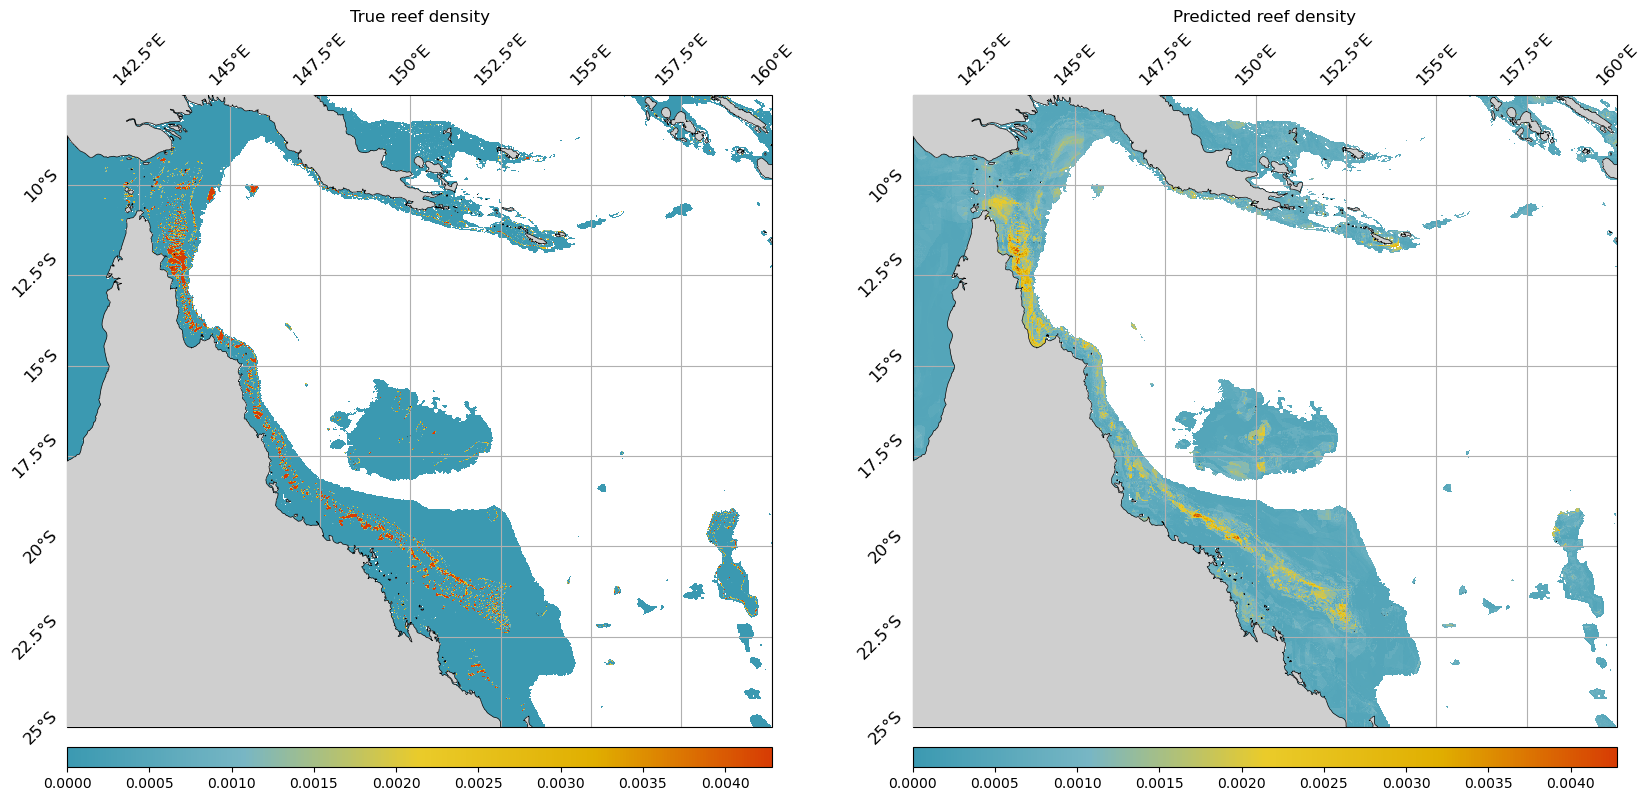

In [21]:
lats = [-25,-7.5]
lons = [140.5,160]

# plot comparison
fig, ax = plt.subplots(ncols=2, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=[20,10])
# scale "predictions" between minimum and maximum of "UNEP_GDCR"
min_gt, max_gt = combined_preds_gt["UNEP_GDCR"].min(), combined_preds_gt["UNEP_GDCR"].max()
min_pred, max_pred = combined_preds_gt["predictions"].min(), combined_preds_gt["predictions"].max()
scaled_pred = (combined_preds_gt["predictions"] - min_pred) / (max_pred - min_pred) * (max_gt - min_gt) + min_gt

spatial_plots.plot_spatial(combined_preds_gt["UNEP_GDCR"].sel(latitude=slice(min(lats), max(lats)), longitude=slice(min(lons), max(lons))), fax=(fig, ax[0]), cbar_dict={"orientation": "horizontal"}, presentation_format=False,
                           title="True reef density")
spatial_plots.plot_spatial(scaled_pred.sel(latitude=slice(min(lats), max(lats)), longitude=slice(min(lons), max(lons))), fax=(fig, ax[1]), cbar_dict={"orientation": "horizontal"}, presentation_format=False,
                           title="Predicted reef density")

In [27]:
gt_df = gt["UNEP_GDCR"].to_dataframe()["UNEP_GDCR"]
# combine gt_df and pred_df, dropping indices not in pred_df
combined_df = pd.concat([gt_df, pred_df], axis=1).dropna()

In [32]:
# scale "predictions" between minimum and maximum of "UNEP_GDCR"
min_gt, max_gt = combined_df["UNEP_GDCR"].min(), combined_df["UNEP_GDCR"].max()
min_pred, max_pred = combined_df["prediction"].min(), combined_df["prediction"].max()
scaled_pred = (combined_df["prediction"] - min_pred) / (max_pred - min_pred) * (max_gt - min_gt) + min_gt


In [34]:
combined_df["UNEP_GDCR"]

latitude  longitude
-30.0     153.21       0.000000
          153.22       0.000000
          153.23       0.000000
          153.24       0.000000
          153.25       0.000000
                         ...   
-2.0      153.52       0.004284
          153.55       0.002249
          153.56       0.000000
          153.57       0.000000
          153.58       0.000000
Name: UNEP_GDCR, Length: 997937, dtype: float64

/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


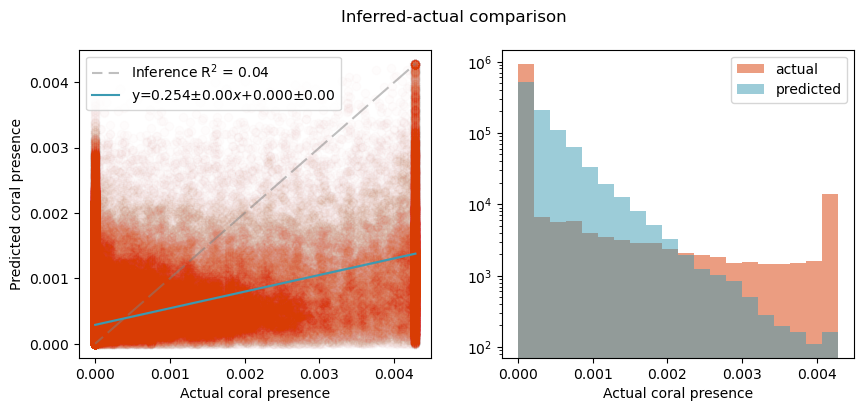

In [36]:
# plot scatter
visualise_results.plot_regression_histograms(combined_df["UNEP_GDCR"], scaled_pred)

# Spatial splitting

In [2]:
config_info["datasets"] = ["cmip6", "unep"]
config_info

{'data_source': 'asdf',
 'regressor_classification_threshold': 0.01,
 'depth_mask': [-1000, 10],
 'ds_type': 'static',
 'predictand': 'UNEP_GDCR',
 'datasets': ['cmip6', 'unep'],
 'env_vars': ['tos',
  'mlotst',
  'rsdo',
  'so',
  'thetao',
  'uo',
  'vo',
  'hfds',
  'wfo'],
 'random_state': 42,
 'resolution': 0.01,
 'resolution_unit': 'd',
 'year_range_to_include': [1950, 2015],
 'upsample_method': 'linear',
 'downsample_method': 'mean',
 'spatial_buffer': 10,
 'save_figs': True,
 'do_train': True,
 'do_save_model': True,
 'do_plot': True,
 'processing': {'do_crop': False},
 'lats': [-30, -2],
 'lons': [140, 166],
 'levs': [0, 20],
 'split_type': 'spatial',
 'test_geom': [-16, -10, 140, 160],
 'train_test_val_frac': [0.8, 0.2, 0],
 'X_scaler': 'standard',
 'y_scaler': 'minmax',
 'hyperparameter_search': {'cv_folds': 5,
  'n_samples': -1,
  'n_iter': 100,
  'type': 'random',
  'do_search': False,
  'n_trials': 5,
  'search_types': ['random'],
  'n_jobs': 8},
 'source_id': 'EC-Earth3P

In [3]:
# minimise complexity of example data
config_info["env_vars"] = ["tos"]
config_info["datasets"] = ["cmip6", "unep"]
config_info["resolution"] = 0.1
# get example merged
ds = ml_processing.ProcessMLData(config_info).get_merged_datasets()[["tos_overall_mean", "UNEP_GDCR", "elevation"]]

Searching for correct CMIP files in: /maps-priv/maps/rt582/coralshift/data/env_vars/cmip6/EC-Earth3P-HR/r1i1p2f1/regridded
	calculating statistics for static ML model(s)...


calculating statistics for variables: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


	applying spatial buffering...
40 raster(s) to spatially buffer...


Buffering variables: 100%|██████████| 40/40 [00:02<00:00, 16.99it/s]


	resampling dataset to 0.1 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326
Loading UNEP_GDCR xarray at 0.004 degrees resolution.
	applying spatial buffering...
1 raster(s) to spatially buffer...


Buffering variables: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


	resampling dataset to 0.1 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326


KeyboardInterrupt: 

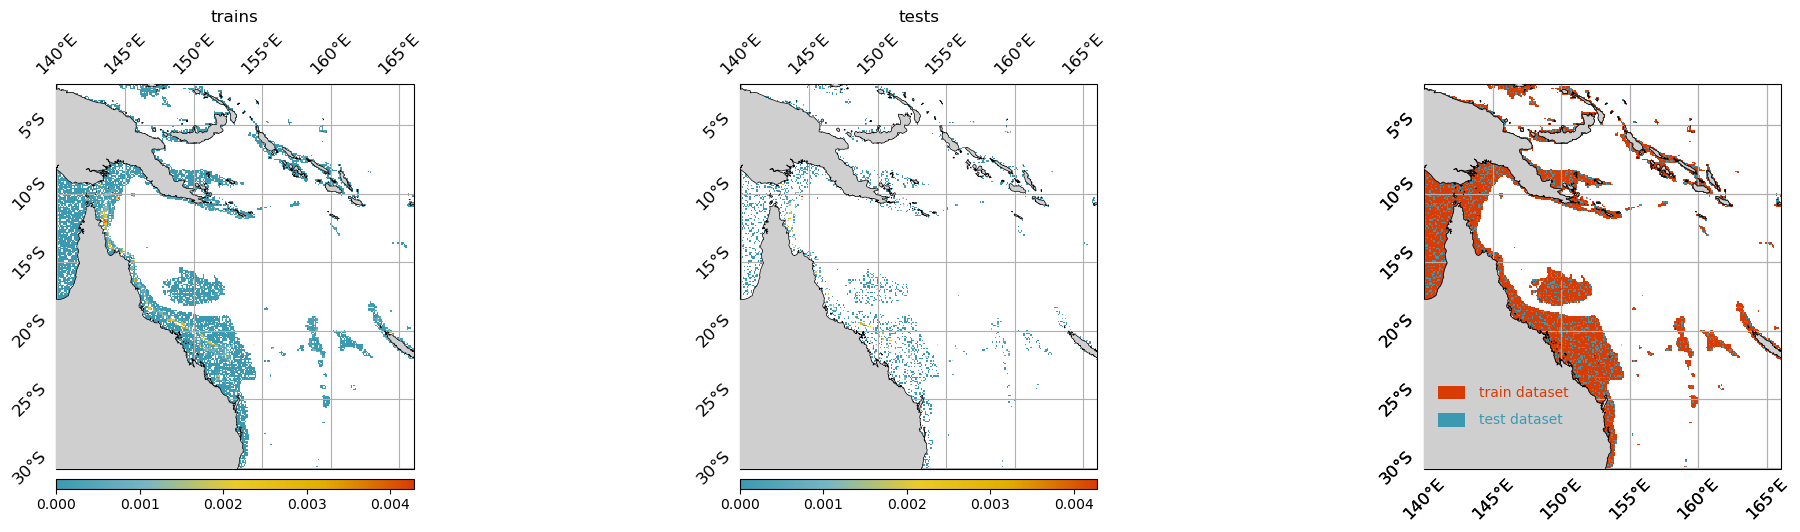

In [ ]:
# pixelwise
config_info["split_type"] = "pixelwise"
trains, tests, _ = ml_processing.ProcessMLData(config_info).split_dataset(ds)
# reform spatially
pixel_trains = spatial_data.spatially_reform_data(trains[1], resolution=config_info["resolution"])
pixel_tests = spatial_data.spatially_reform_data(tests[1], resolution=config_info["resolution"])
# plot
f, axes = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(25, 5))
spatial_plots.plot_spatial(pixel_trains["UNEP_GDCR"], title="trains", fax=(f, axes[0]), cbar_dict={"orientation": "horizontal"})
spatial_plots.plot_spatial(pixel_tests["UNEP_GDCR"], title="tests", fax=(f, axes[1]), cbar_dict={"orientation": "horizontal"})
spatial_plots.plot_train_test_datasets(pixel_trains["UNEP_GDCR"], pixel_tests["UNEP_GDCR"], fax=(f, axes[2]))

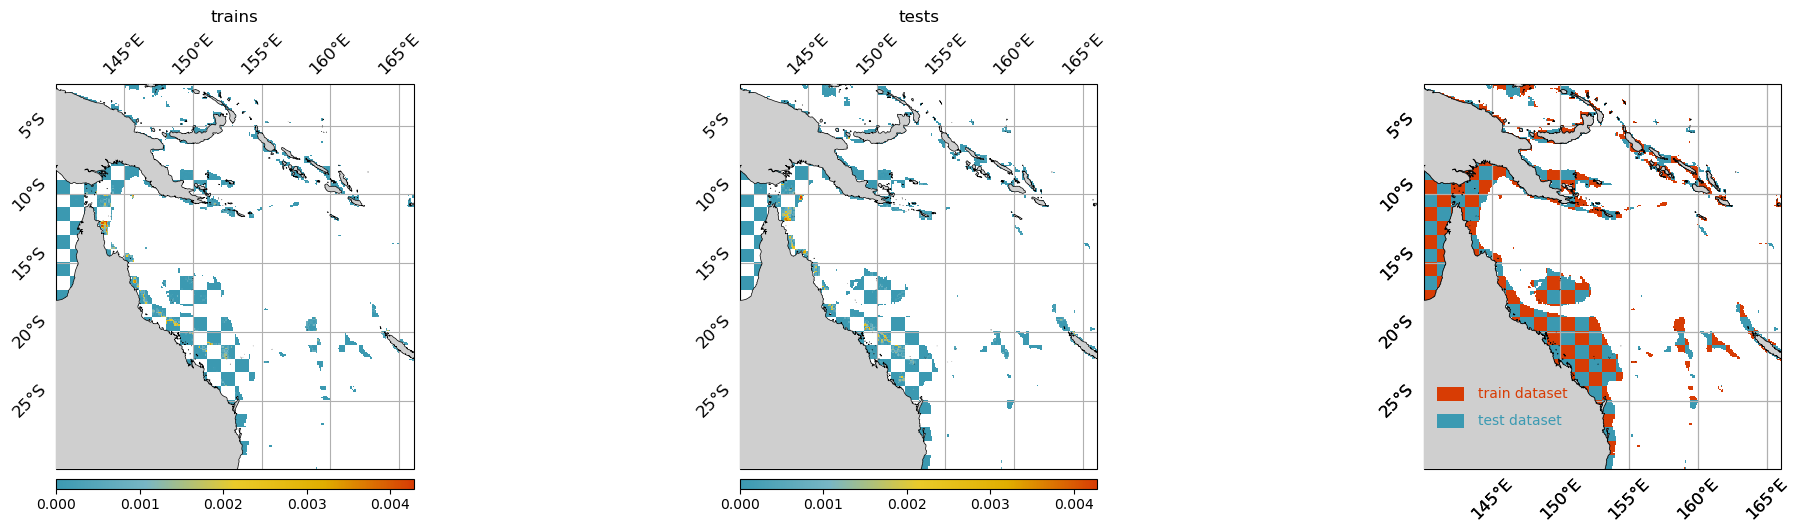

In [ ]:
# checkerboard
config_info["split_type"] = "checkerboard"
trains, tests, _ = ml_processing.ProcessMLData(config_info).split_dataset(ds)
# reform spatially
checkerboard_trains = spatial_data.spatially_reform_data(trains[1], resolution=config_info["resolution"])
checkerboard_tests = spatial_data.spatially_reform_data(tests[1], resolution=config_info["resolution"])
# plot
f, axes = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(25, 5))
spatial_plots.plot_spatial(checkerboard_trains["UNEP_GDCR"], title="trains", fax=(f, axes[0]), cbar_dict={"orientation": "horizontal"})
spatial_plots.plot_spatial(checkerboard_tests["UNEP_GDCR"], title="tests", fax=(f, axes[1]), cbar_dict={"orientation": "horizontal"})
spatial_plots.plot_train_test_datasets(checkerboard_trains["UNEP_GDCR"], checkerboard_tests["UNEP_GDCR"], fax=(f, axes[2]))

100%|██████████| 364/364 [00:00<00:00, 3102.37it/s]


Final ratio test fraction: 0.1658857541620975


100%|██████████| 364/364 [00:00<00:00, 3483.38it/s]


Final ratio test fraction: 0.1658857541620975


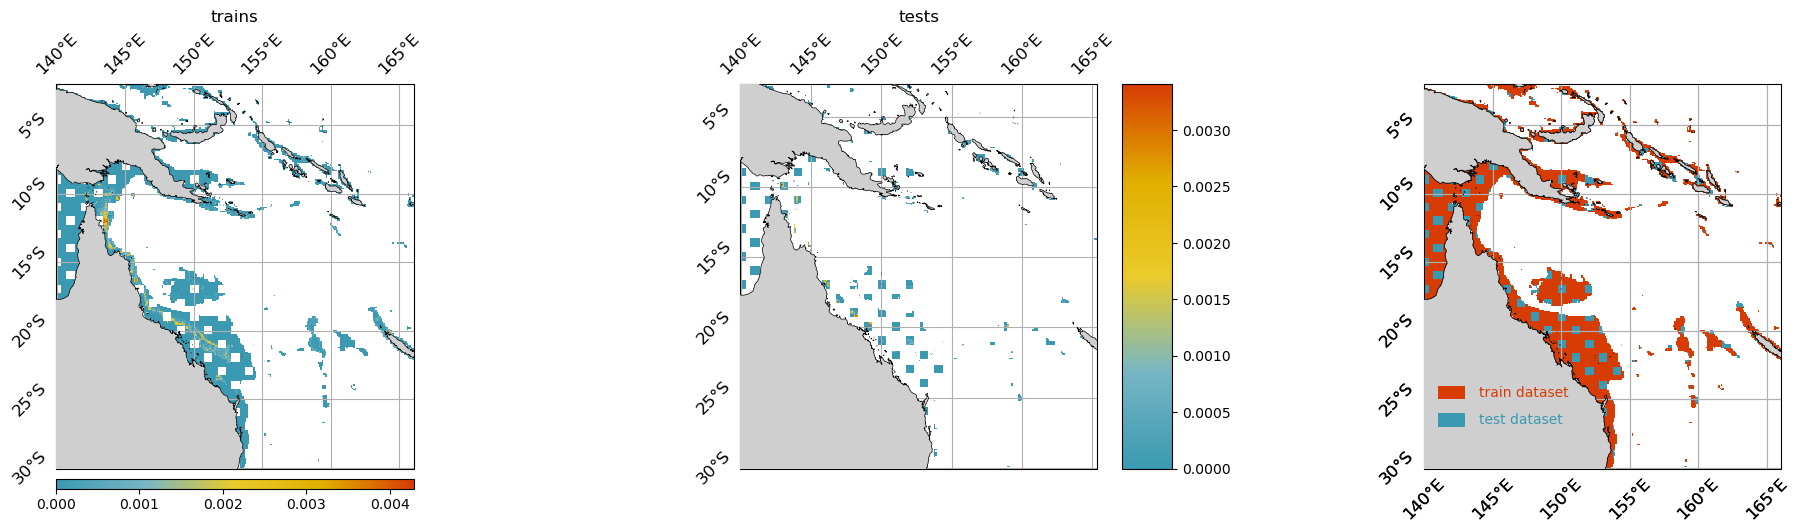

In [ ]:
# custom checkerboard
config_info["split_type"] = "custom_checkerboard"
trains, tests, _ = ml_processing.ProcessMLData(config_info).split_dataset(ds)
# reform spatially
ccheckerboard_trains = spatial_data.spatially_reform_data(trains[1], resolution=config_info["resolution"])
ccheckerboard_tests = spatial_data.spatially_reform_data(tests[1], resolution=config_info["resolution"])
# plot
f, axes = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(25, 5))
spatial_plots.plot_spatial(ccheckerboard_trains["UNEP_GDCR"], title="trains", fax=(f, axes[0]), cbar_dict={"orientation": "horizontal"})
spatial_plots.plot_spatial(ccheckerboard_tests["UNEP_GDCR"], title="tests", fax=(f, axes[1]), cbar_dict={"orientation": "vertical"})
spatial_plots.plot_train_test_datasets(ccheckerboard_trains["UNEP_GDCR"], ccheckerboard_tests["UNEP_GDCR"], fax=(f, axes[2]))

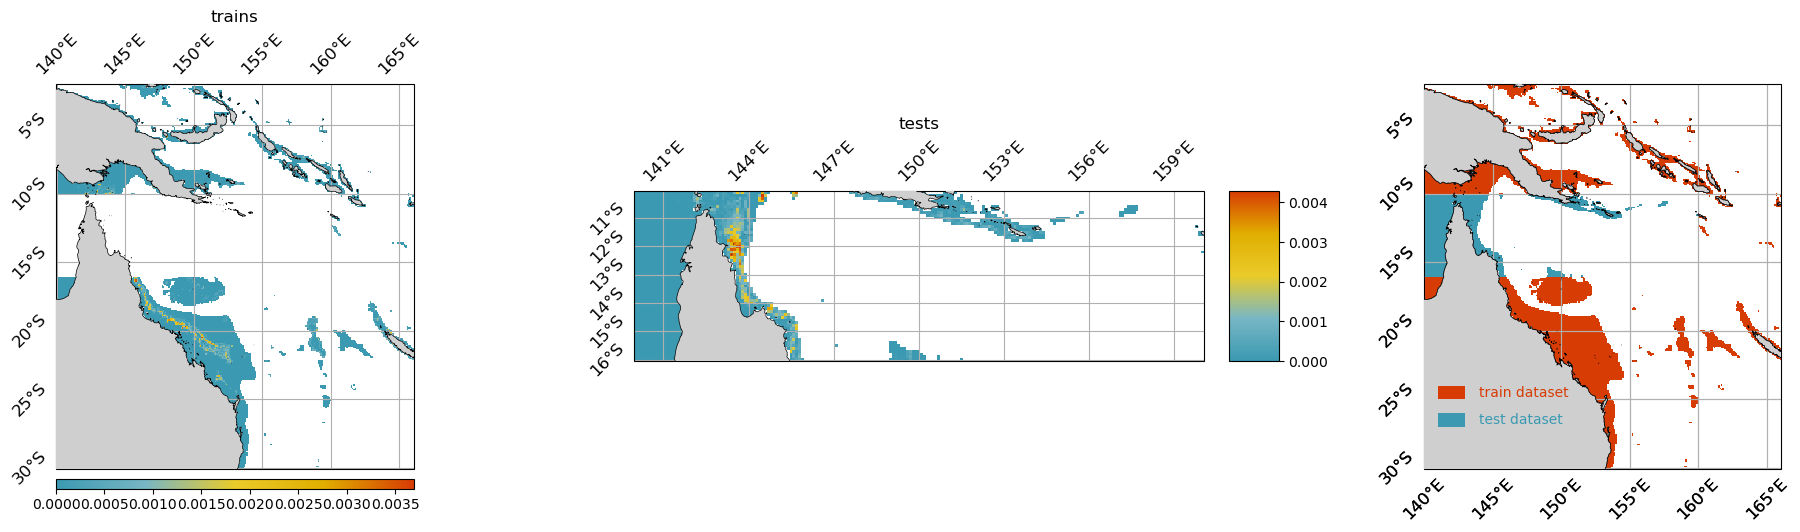

In [ ]:
config_info["split_type"] = "spatial"
trains, tests, _ = ml_processing.ProcessMLData(config_info).split_dataset(ds)
# reform spatially
trains_spatial = spatial_data.spatially_reform_data(trains[1], resolution=config_info["resolution"])
tests_spatial = spatial_data.spatially_reform_data(tests[1], resolution=config_info["resolution"])
# plot
f, axes = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(25, 5))
spatial_plots.plot_spatial(trains_spatial["UNEP_GDCR"], title="trains", fax=(f, axes[0]), cbar_dict={"orientation": "horizontal"})
spatial_plots.plot_spatial(tests_spatial["UNEP_GDCR"], title="tests", fax=(f, axes[1]), cbar_dict={"orientation": "vertical"})
spatial_plots.plot_train_test_datasets(trains_spatial["UNEP_GDCR"], tests_spatial["UNEP_GDCR"], fax=(f, axes[2]))

## Marking train/test

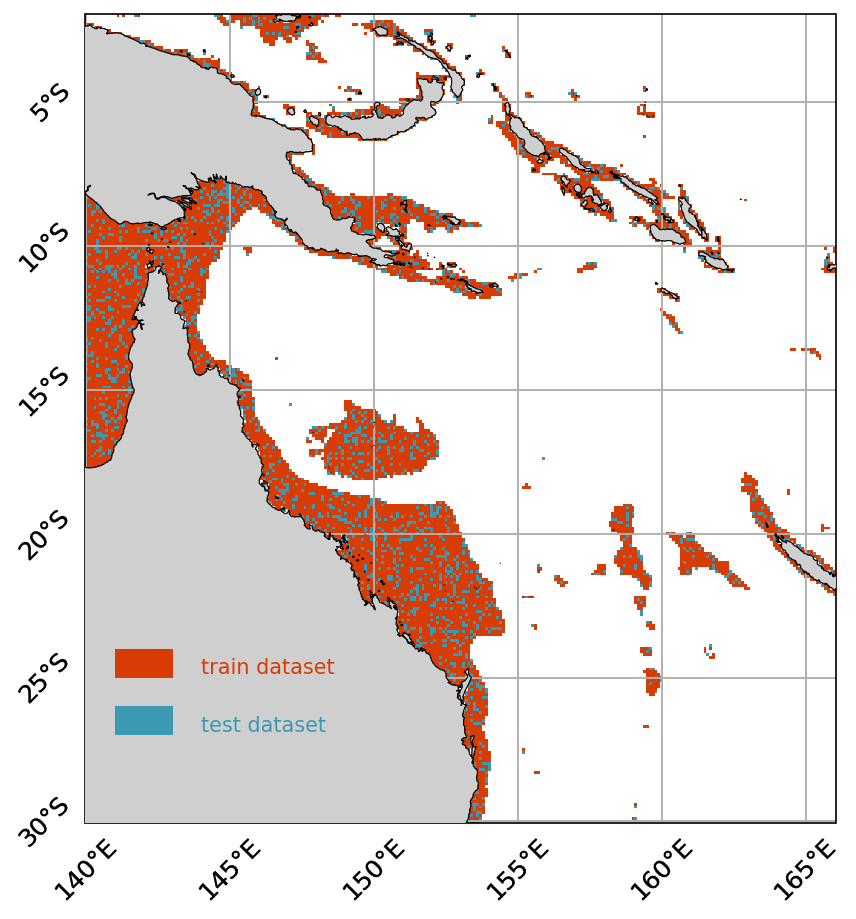

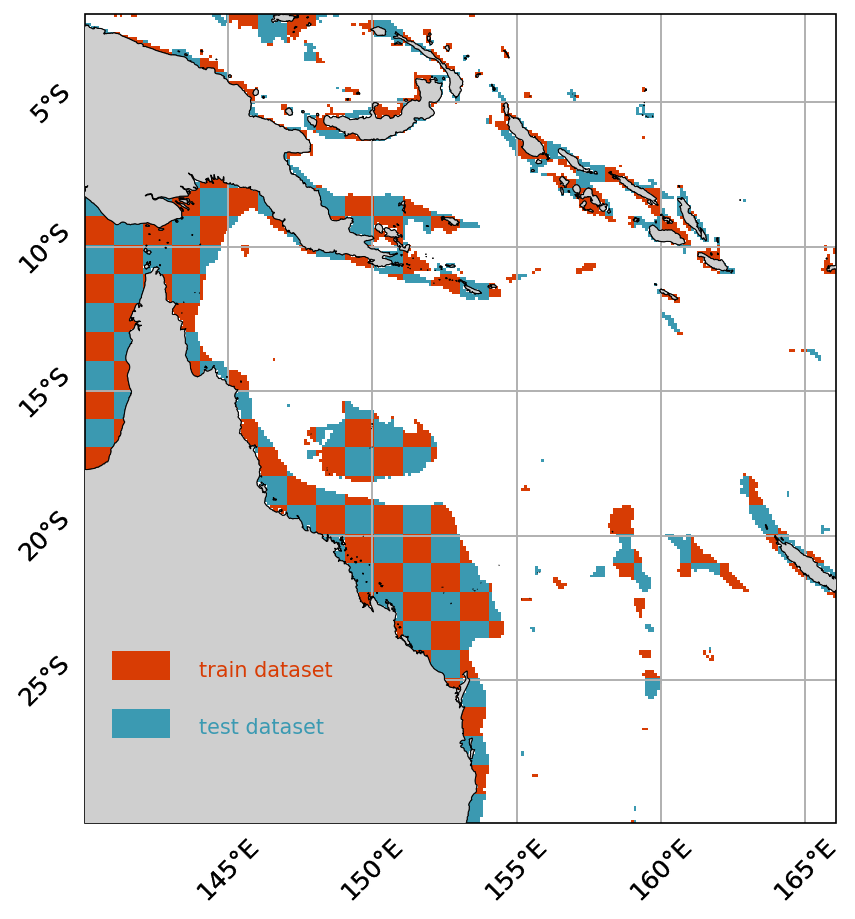

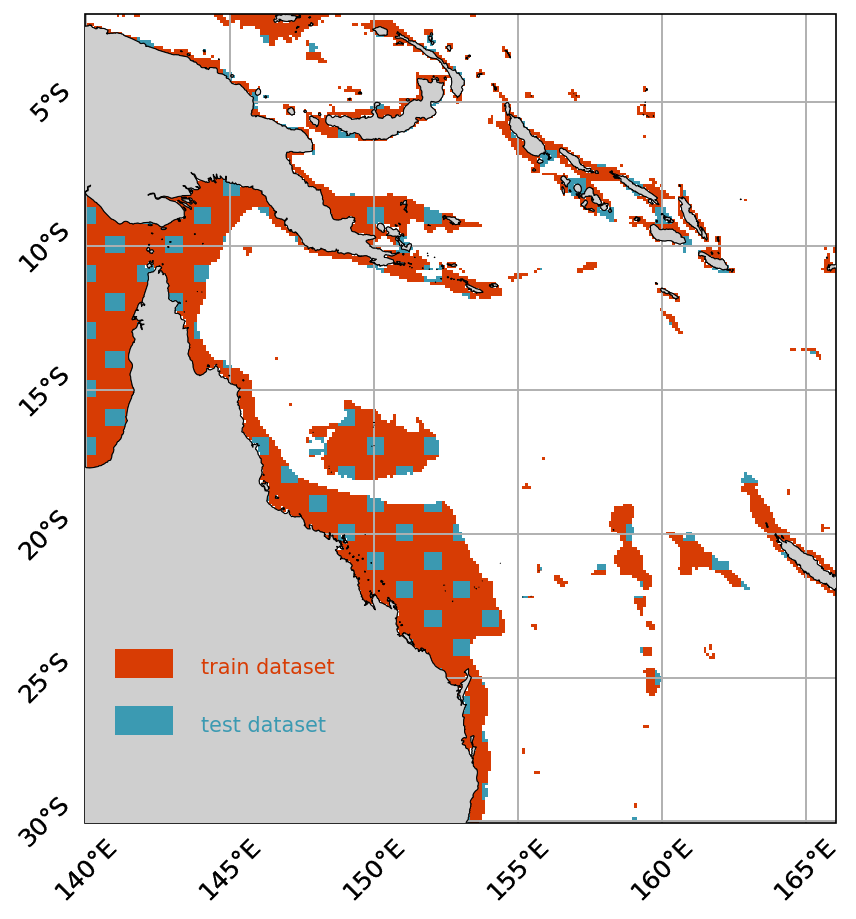

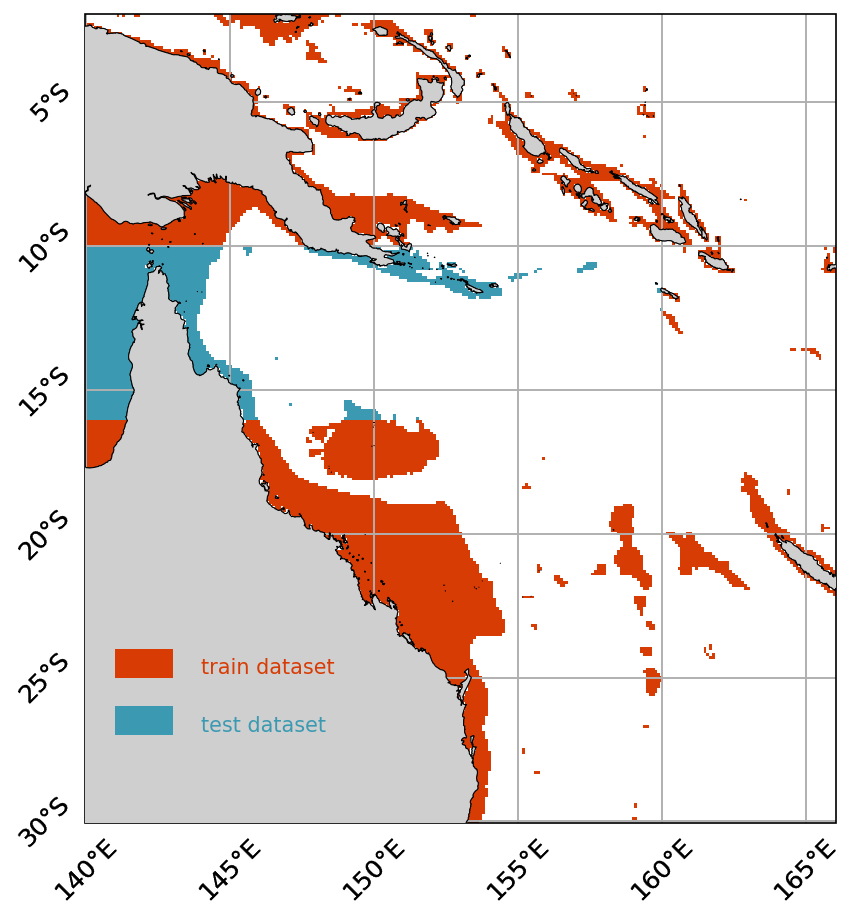

In [ ]:
for split_type, train, test in [("pixelwise", pixel_trains, pixel_tests), ("checkerboard", checkerboard_trains, checkerboard_tests), ("custom_checkerboard", ccheckerboard_trains, ccheckerboard_tests), ("spatial", trains_spatial, tests_spatial)]:
    spatial_plots.plot_train_test_datasets(train["UNEP_GDCR"], test["UNEP_GDCR"], figsize=(7,7))
    # save figures
    fig_dir = Path("/maps/rt582/coralshift/runs/figures")
    plt.savefig(f"{fig_dir}/train_test_datasets_{split_type}.png")

# Training/inferring

In [4]:
# ALREADY DONE
# # get merged dataset
# ds = ml_processing.ProcessMLData(config_info=config_info).get_merged_datasets()
# # save 0.01 degree resolution data as one large netcdf file
# ds.to_netcdf("/maps/rt582/coralshift/data/ml_ready/all_vars_0-01.nc")
# open dataset
ds = xa.open_dataset("/maps/rt582/coralshift/data/ml_ready/all_vars_0-01.nc")

### Spatial

In [5]:
# # ALREADY DONE FOR -16_-10_140_160
# # generate train, test data
# (trains, tests, vals), ds_info = ml_processing.ProcessMLData(config_info=config_info).generate_ml_ready_data(ds = ds)

# # save processed dfs to parquet files
# X_trains = trains[0]
# y_trains = pd.DataFrame(trains[1])
# X_tests = tests[0]
# y_tests = pd.DataFrame(tests[1])

# # save to parquet
# X_trains.to_parquet(f"/maps/rt582/coralshift/data/ml_ready/spatial_-16_-10_140_160/X_trains.parquet")
# y_trains.to_parquet(f"/maps/rt582/coralshift/data/ml_ready/spatial_-16_-10_140_160/y_trains.parquet")
# X_tests.to_parquet(f"/maps/rt582/coralshift/data/ml_ready/spatial_-16_-10_140_160/X_tests.parquet")
# y_tests.to_parquet(f"/maps/rt582/coralshift/data/ml_ready/spatial_-16_-10_140_160/y_tests.parquet")

In [6]:
# open parquet files
X_trains = pd.read_parquet(f"/maps/rt582/coralshift/data/ml_ready/spatial_-16_-10_140_160/X_trains.parquet")
y_trains = pd.read_parquet(f"/maps/rt582/coralshift/data/ml_ready/spatial_-16_-10_140_160/y_trains.parquet")
X_tests = pd.read_parquet(f"/maps/rt582/coralshift/data/ml_ready/spatial_-16_-10_140_160/X_tests.parquet")
y_tests = pd.read_parquet(f"/maps/rt582/coralshift/data/ml_ready/spatial_-16_-10_140_160/y_tests.parquet")

(<Figure size 3000x3000 with 2 Axes>,
 <GeoAxes: title={'center': 'tests'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7f3f8b0fb9e0>)

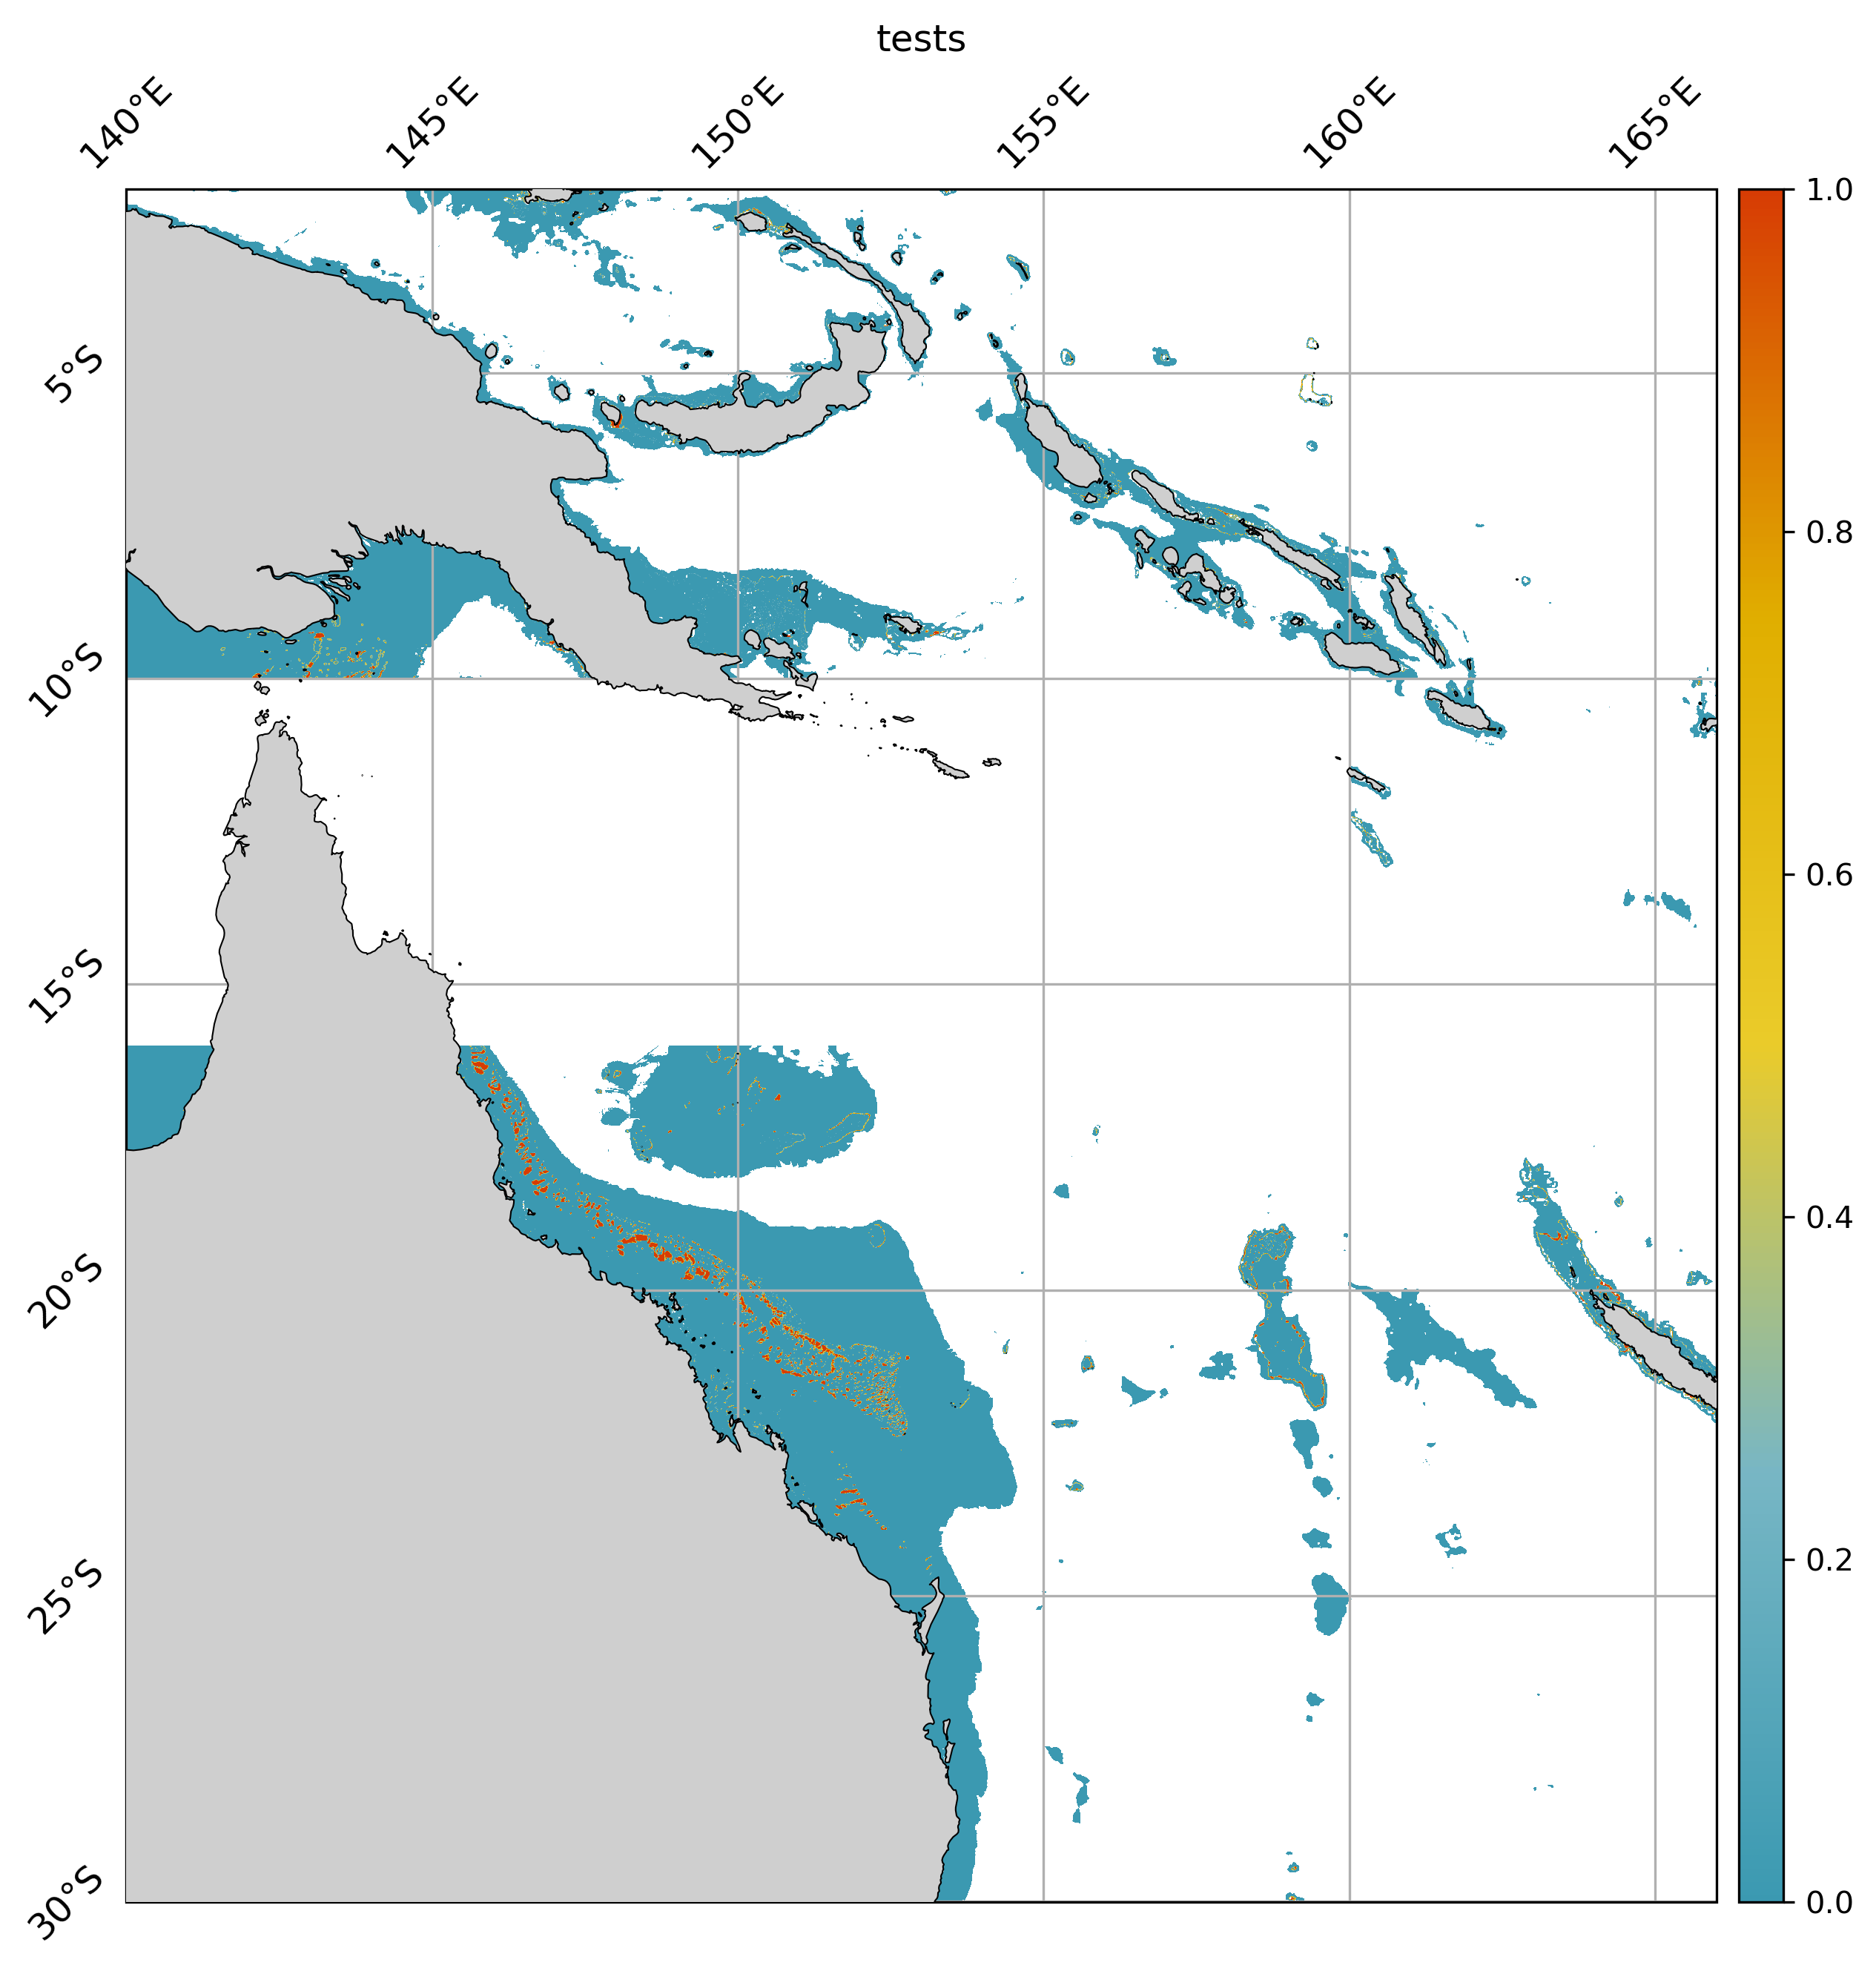

In [7]:
# reform spatially to check
trains_spatial = spatial_data.spatially_reform_data(y_trains, resolution=config_info["resolution"])
spatial_plots.plot_spatial(trains_spatial[0], title="tests", cbar_dict={"orientation": "vertical"})

In [8]:
dtrain = xgb.DMatrix(X_trains, y_trains)
dtest = xgb.DMatrix(X_tests, y_tests)
evals = [(dtrain, "train"), (dtest, "validation")]

# use best-performing parameters from parameter sweep. N.B. different split types may require different parameters
params = {'objective': 'reg:squarederror', 'n_estimators': 945, 'max_depth': 31, 'eval_metric': 'rmse', 'colsample_bytree': 0.29999999999999993}
num_rounds = 1000

# train model
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_rounds,
    evals=evals,
    verbose_eval=100,
    early_stopping_rounds=50
    )

/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [01:50:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:0.10040	validation-rmse:0.20426
[49]	train-rmse:0.00030	validation-rmse:0.21118


In [9]:
# make predictions
preds = model.predict(dtest)
# reform spatially
preds_spatial = spatial_data.spatially_reform_data(preds, resolution=config_info["resolution"])
y_tests_spatial = spatial_data.spatially_reform_data(y_tests, resolution=config_info["resolution"])

fig, ax = plt.subplots(2, 1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20, 7), dpi=300)
spatial_plots.plot_spatial(preds_spatial[0], title="tests", cbar_dict={"orientation": "vertical"}, fax=(fig, ax[0]))
spatial_plots.plot_spatial(y_tests_spatial[0], title="tests", cbar_dict={"orientation": "vertical"}, fax=(fig, ax[1]))

AttributeError: 'numpy.ndarray' object has no attribute 'index'

### Custom checkerboard

In [3]:
# ALREADY DONE
# # get merged dataset
# ds = ml_processing.ProcessMLData(config_info=config_info).get_merged_datasets()
# # save 0.01 degree resolution data as one large netcdf file
# ds.to_netcdf("/maps/rt582/coralshift/data/ml_ready/all_vars_0-01.nc")
# open dataset
ds = xa.open_dataset("/maps/rt582/coralshift/data/ml_ready/all_vars_0-01.nc")
# generate train, test data
config_info = file_ops.read_yaml(config_fp)
config_info["split_type"] = "custom_checkerboard"
# (trains, tests, _), ds_info = ml_processing.ProcessMLData(config_info=config_info).generate_ml_ready_data(ds = ds)

# # save processed dfs to parquet files
# X_trains = trains[0]
# y_trains = pd.DataFrame(trains[1])
# X_tests = tests[0]
# y_tests = pd.DataFrame(tests[1])

# # save to parquet
# X_trains.to_parquet(f"/maps/rt582/coralshift/data/ml_ready/ccheckerboard/X_trains.parquet")
# y_trains.to_parquet(f"/maps/rt582/coralshift/data/ml_ready/ccheckerboard/y_trains.parquet")
# X_tests.to_parquet(f"/maps/rt582/coralshift/data/ml_ready/ccheckerboard/X_tests.parquet")
# y_tests.to_parquet(f"/maps/rt582/coralshift/data/ml_ready/ccheckerboard/y_tests.parquet")

X_trains = pd.read_parquet(f"/maps/rt582/coralshift/data/ml_ready/ccheckerboard/X_trains.parquet")
y_trains = pd.read_parquet(f"/maps/rt582/coralshift/data/ml_ready/ccheckerboard/y_trains.parquet")
X_tests = pd.read_parquet(f"/maps/rt582/coralshift/data/ml_ready/ccheckerboard/X_tests.parquet")
y_tests = pd.read_parquet(f"/maps/rt582/coralshift/data/ml_ready/ccheckerboard/y_tests.parquet")

(<Figure size 750x750 with 2 Axes>,
 <GeoAxes: title={'center': 'tests'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7fe83f0005f0>)

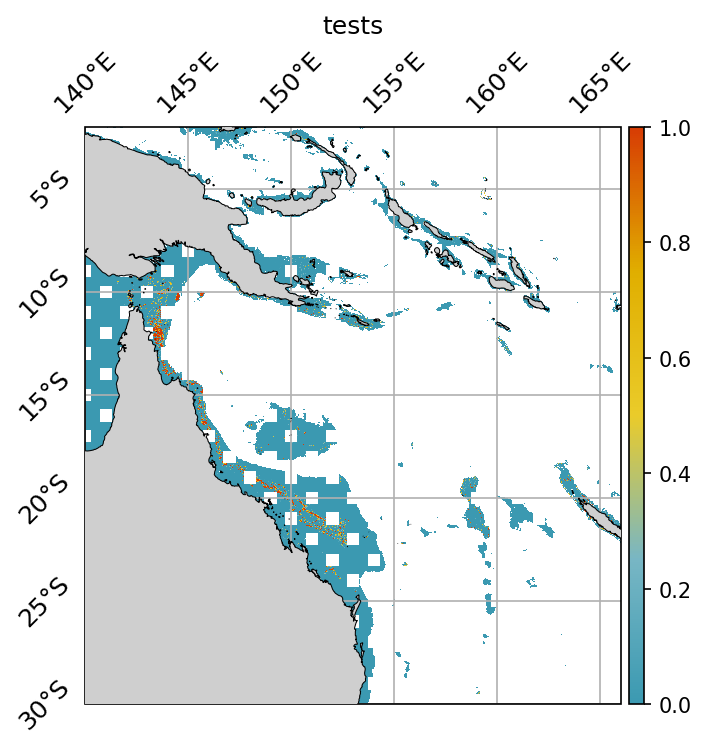

In [4]:
# reform spatially to check
trains_ccheckerboard = spatial_data.spatially_reform_data(y_trains, resolution=config_info["resolution"])
spatial_plots.plot_spatial(trains_ccheckerboard[0], title="tests", cbar_dict={"orientation": "vertical"}, dpi=150, figsize=(5, 5))

In [5]:
dtrain = xgb.DMatrix(X_trains, y_trains)
dtest = xgb.DMatrix(X_tests, y_tests)
evals = [(dtrain, "train"), (dtest, "validation")]

# use best-performing parameters from parameter sweep. N.B. different split types may require different parameters
params = {'objective': 'reg:squarederror', 'n_estimators': 945, 'max_depth': 31, 'eval_metric': 'rmse', 'colsample_bytree': 0.29999999999999993}
num_rounds = 1000

# train model
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_rounds,
    evals=evals,
    verbose_eval=100,
    early_stopping_rounds=50
    )

/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [13:21:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:0.11611	validation-rmse:0.13348
[57]	train-rmse:0.00032	validation-rmse:0.11654


(<Figure size 6000x3000 with 4 Axes>,
 <GeoAxes: title={'center': 'tests'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7fe7e6d2ef60>)

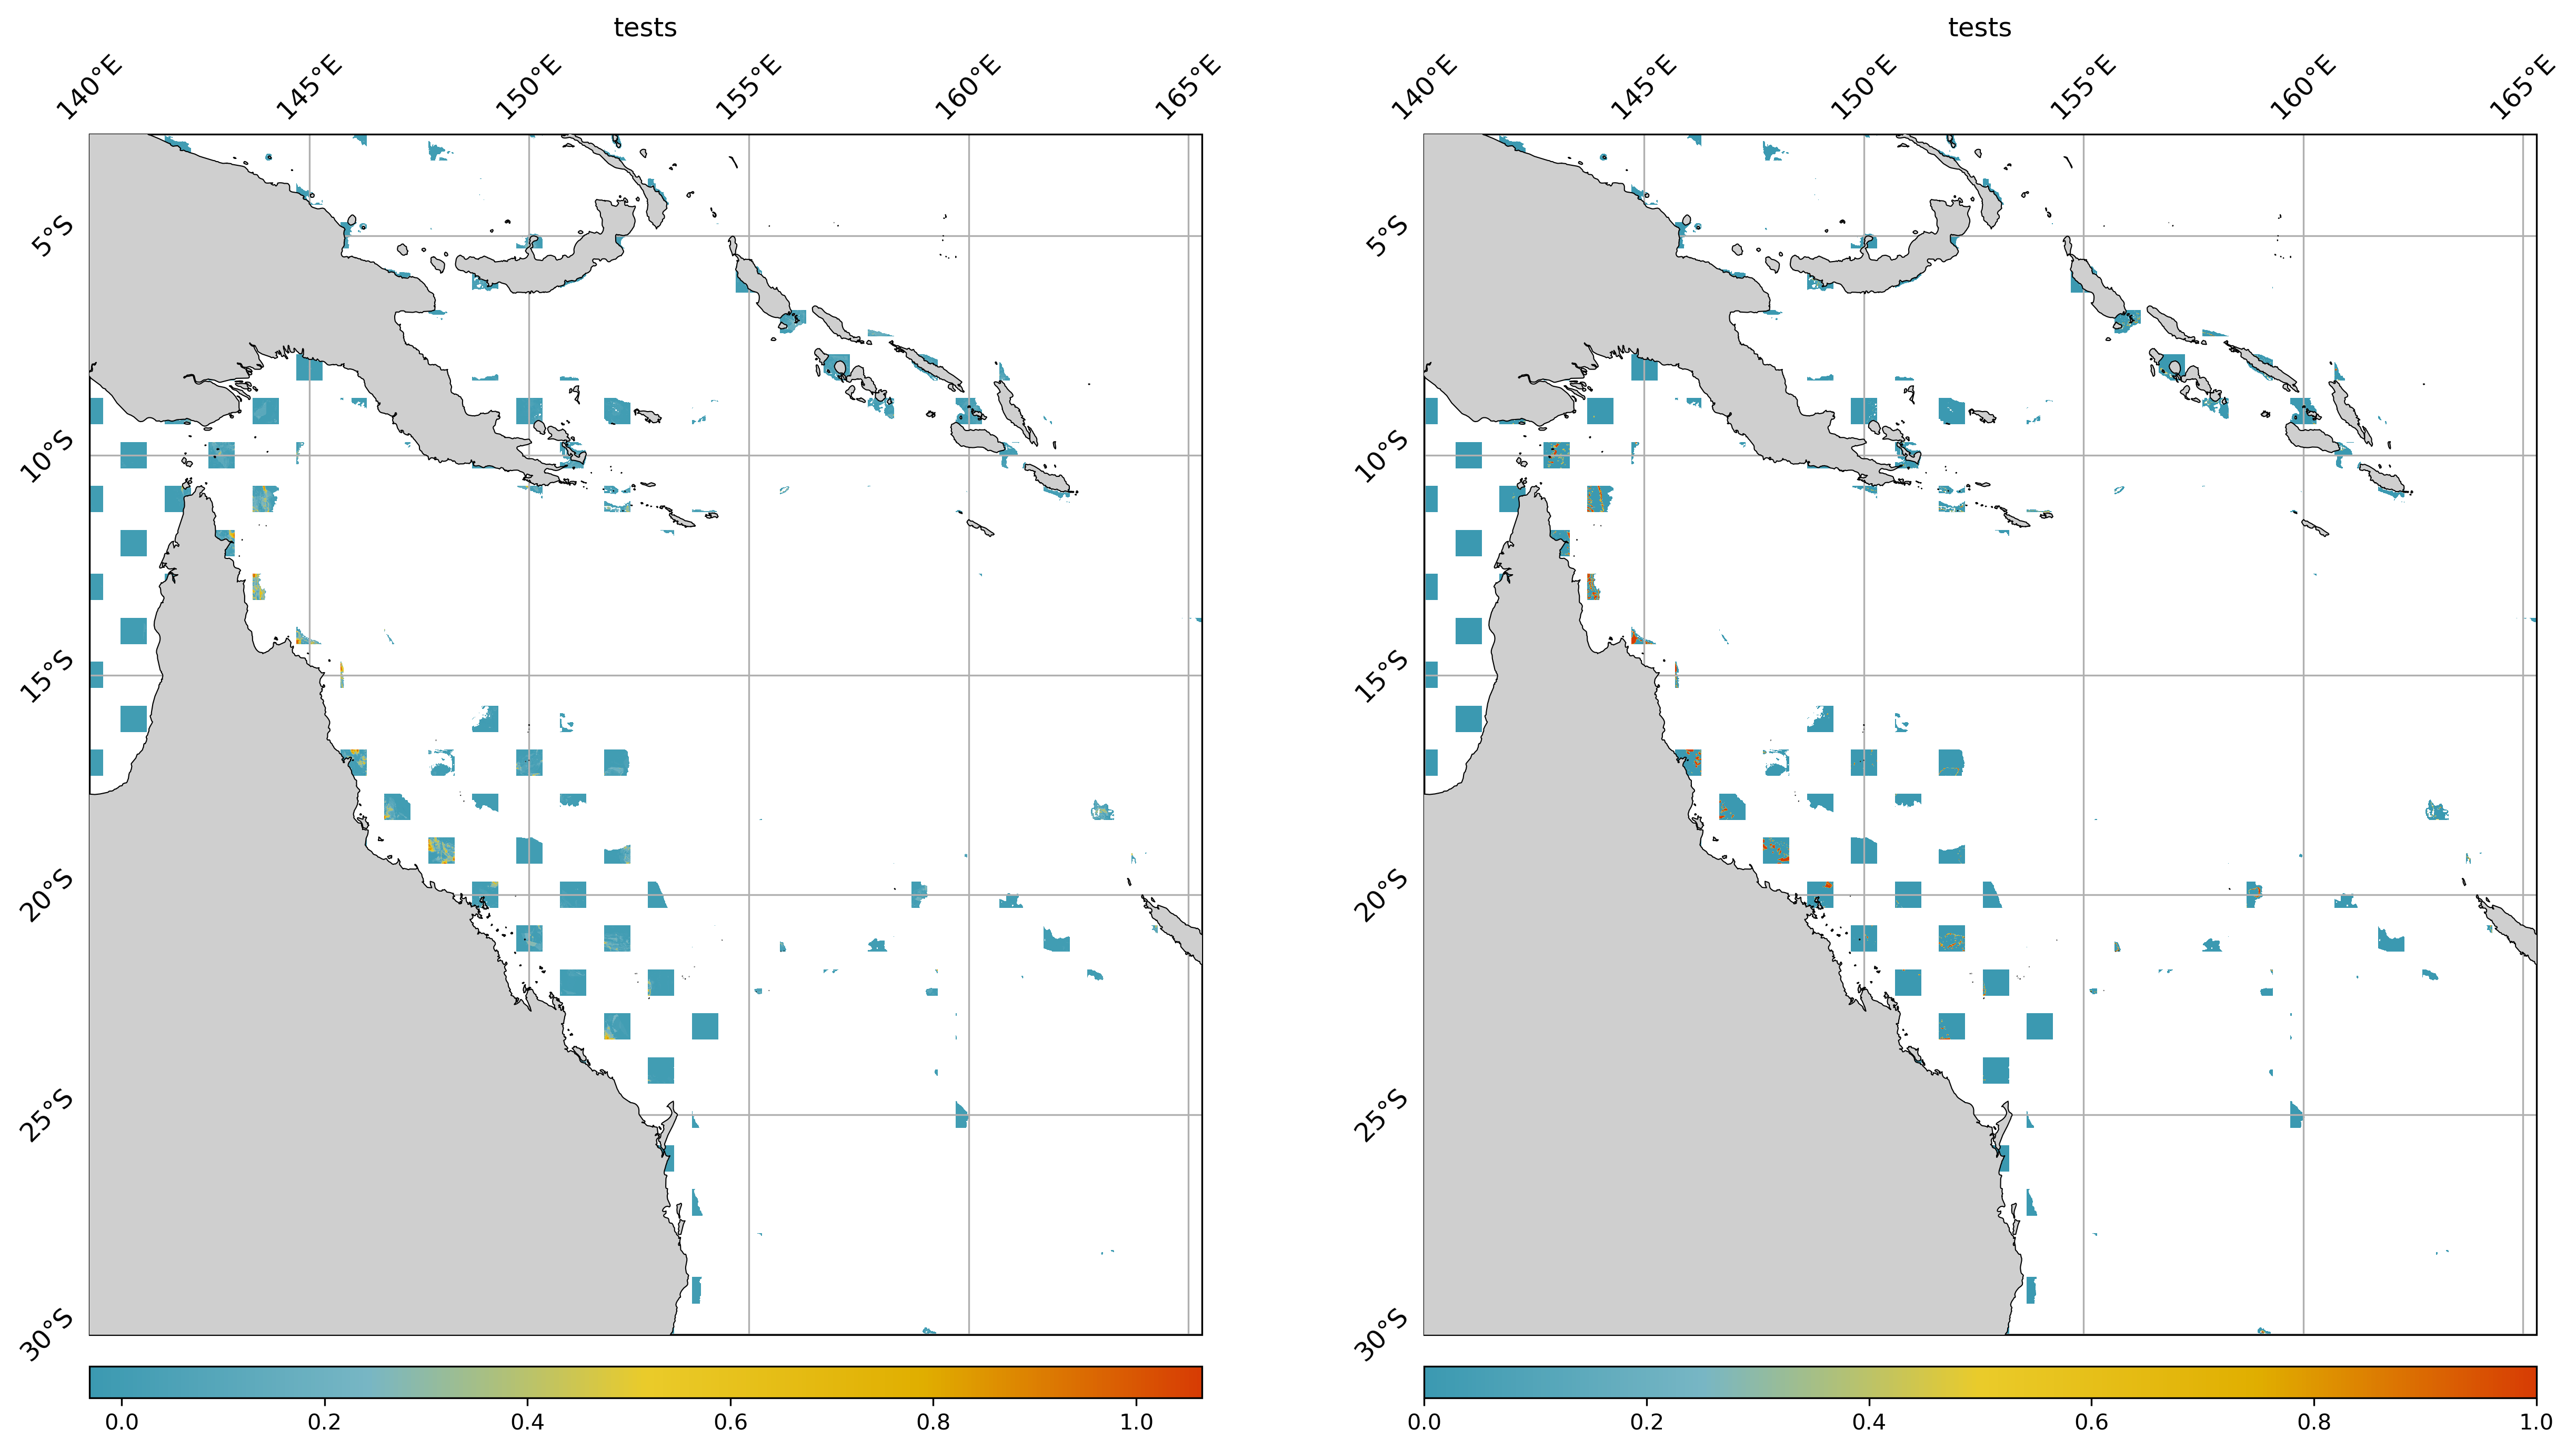

In [6]:
# make predictions
preds = pd.Series(model.predict(dtest), y_tests.index)
# reform spatially
preds_ccheckerboard = spatial_data.spatially_reform_data(preds, resolution=config_info["resolution"])
y_tests_ccheckerboard = spatial_data.spatially_reform_data(y_tests, resolution=config_info["resolution"])

fig, ax = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20, 10), dpi=300)
spatial_plots.plot_spatial(preds_ccheckerboard[0], title="tests", cbar_dict={"orientation": "horizontal"}, fax=(fig, ax[0]))
spatial_plots.plot_spatial(y_tests_ccheckerboard[0], title="tests", cbar_dict={"orientation": "horizontal"}, fax=(fig, ax[1]))

(<Figure size 6000x3000 with 4 Axes>,
 <GeoAxes: title={'center': 'ground truth'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7fe7e74d1d00>)

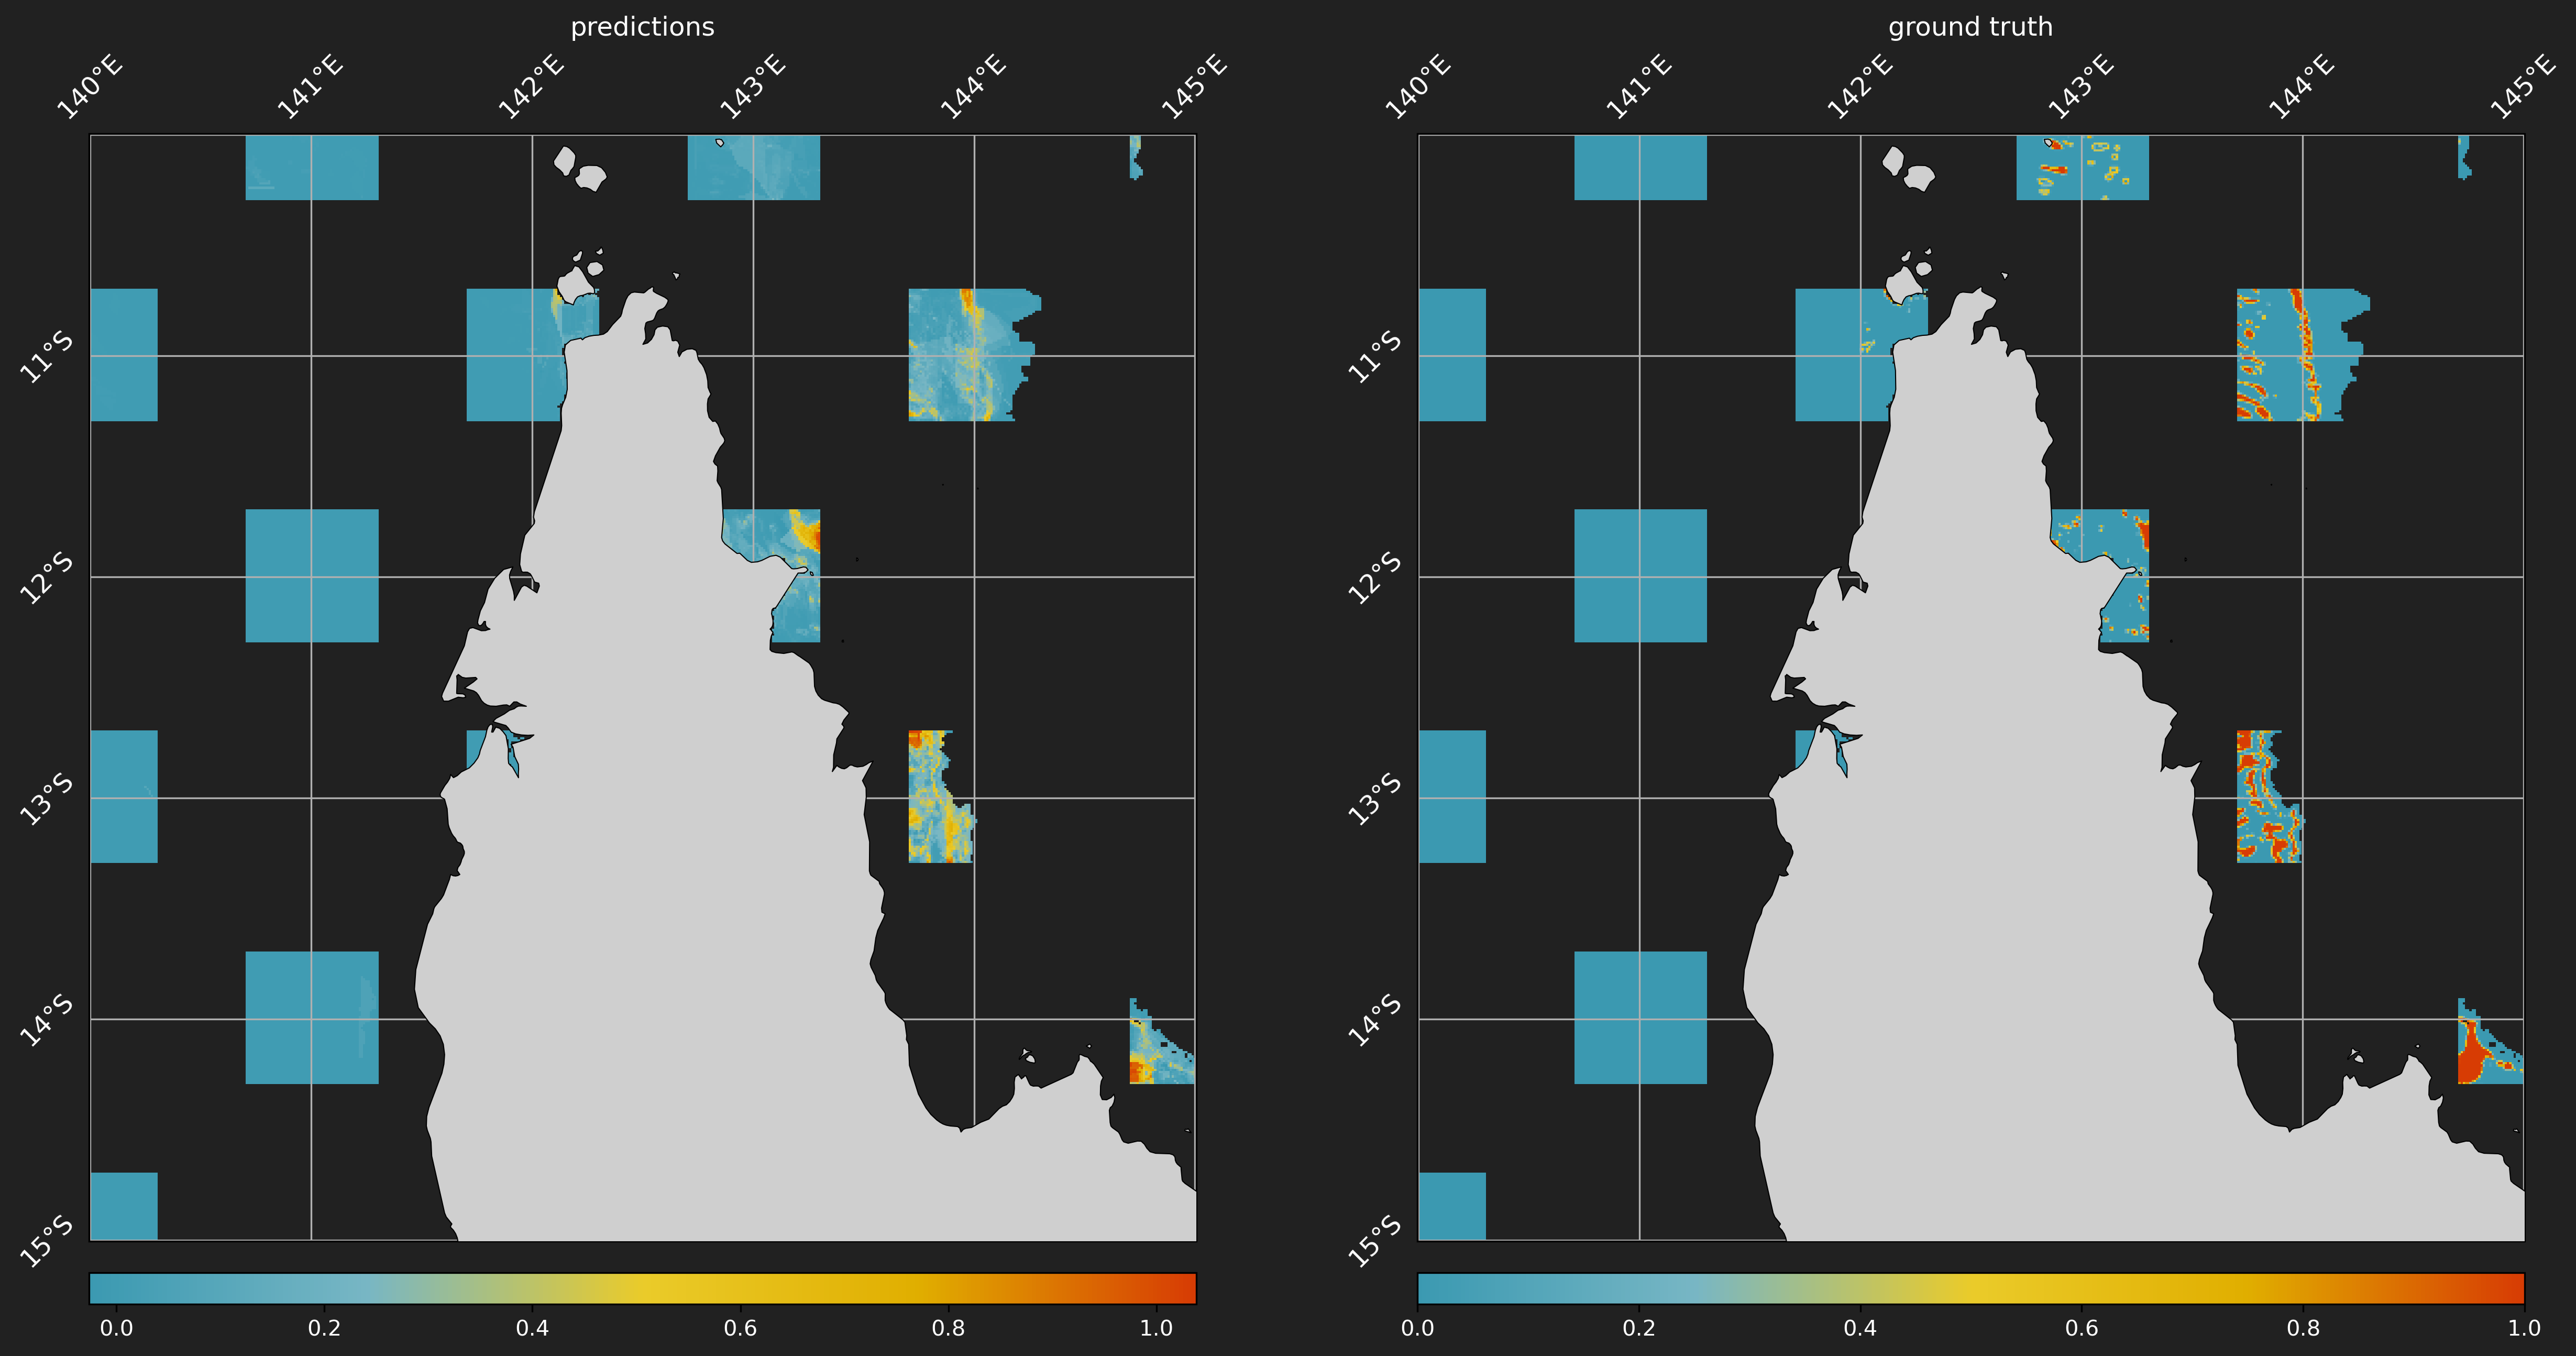

In [8]:
aoi_lats = [-15, -10]
aoi_lons = [140, 145]

# zoom into area
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20, 10), dpi=300)
spatial_plots.plot_spatial(preds_ccheckerboard[0].sel(latitude=slice(min(aoi_lats), max(aoi_lats)), longitude=slice(min(aoi_lons), max(aoi_lons))),
    title="predictions", cbar_dict={"orientation": "horizontal"}, fax=(fig, ax[0]), presentation_format=True)
spatial_plots.plot_spatial(y_tests_ccheckerboard[0].sel(latitude=slice(min(aoi_lats), max(aoi_lats)), longitude=slice(min(aoi_lons), max(aoi_lons))),
    title="ground truth", cbar_dict={"orientation": "horizontal"}, fax=(fig, ax[1]), presentation_format=True)

(<Figure size 6000x3000 with 4 Axes>,
 <GeoAxes: xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7fe7e7774050>)

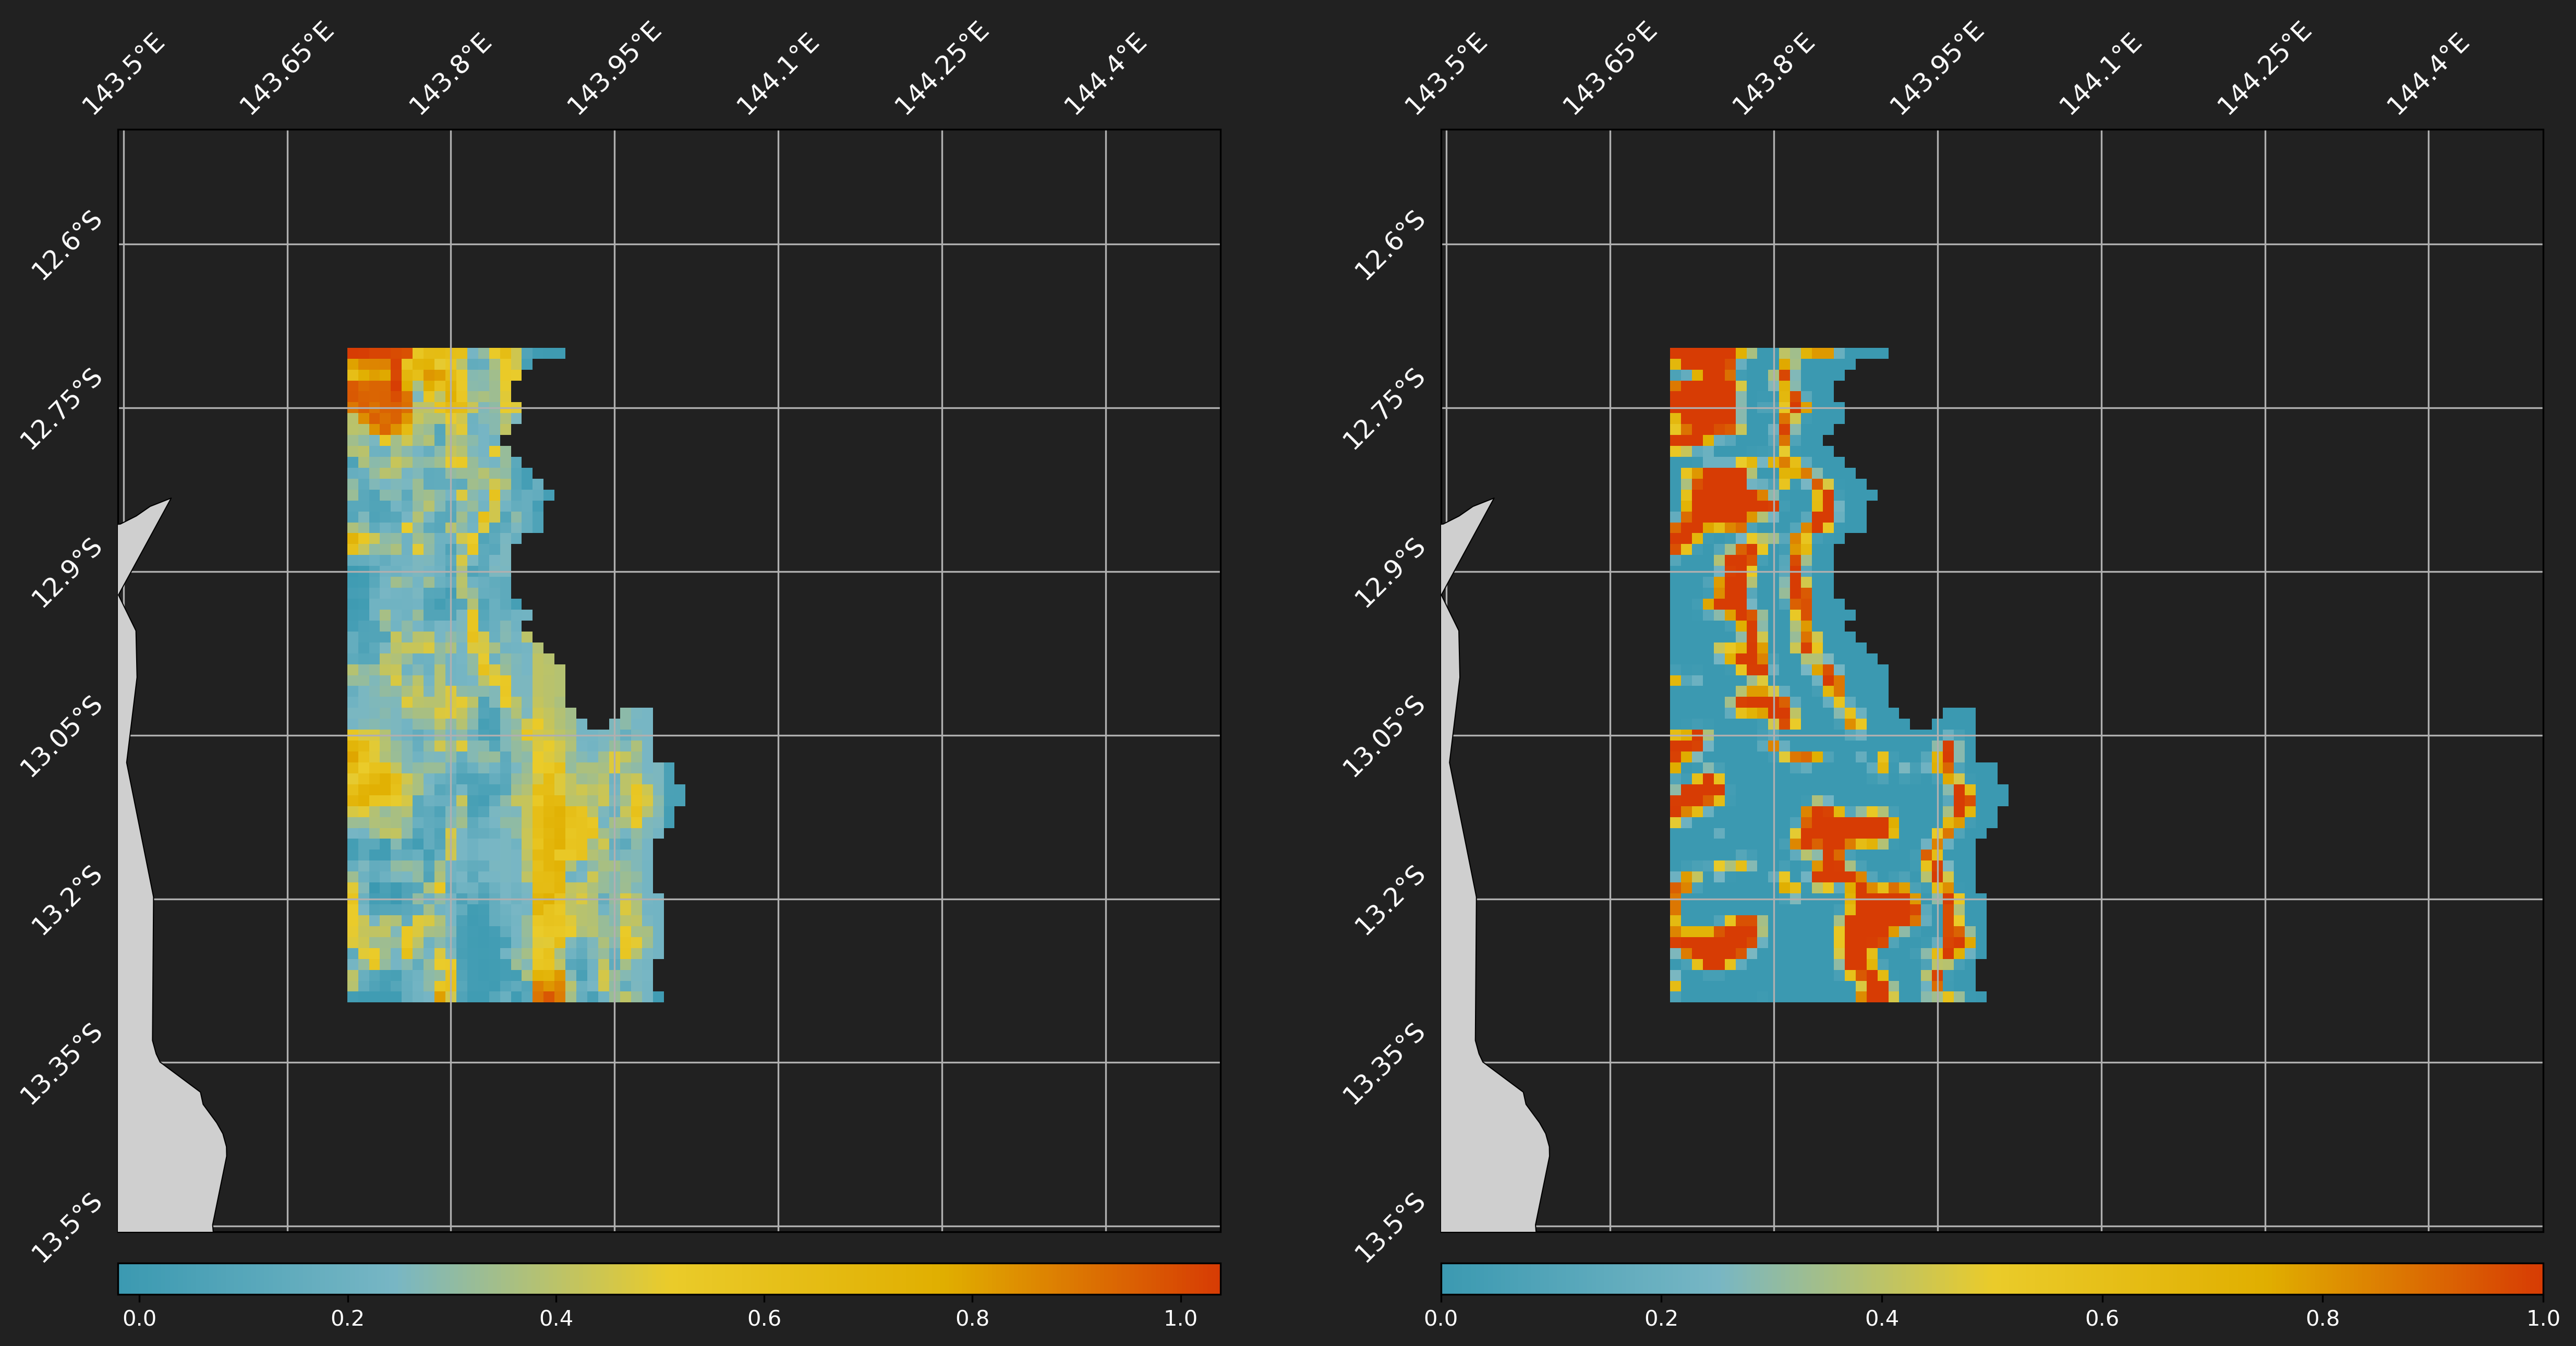

In [16]:
aoi_lats = [-13.5, -12.5]
aoi_lons = [143.5, 144.5]

# zoom into area
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20, 10), dpi=300)
spatial_plots.plot_spatial(preds_ccheckerboard[0].sel(latitude=slice(min(aoi_lats), max(aoi_lats)), longitude=slice(min(aoi_lons), max(aoi_lons))),
    title=None, cbar_dict={"orientation": "horizontal"}, fax=(fig, ax[0]), presentation_format=True)
spatial_plots.plot_spatial(y_tests_ccheckerboard[0].sel(latitude=slice(min(aoi_lats), max(aoi_lats)), longitude=slice(min(aoi_lons), max(aoi_lons))),
    title=None, cbar_dict={"orientation": "horizontal"}, fax=(fig, ax[1]), presentation_format=True)

## Hyperparameter tuning

In [7]:
import joblib
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

rs_params = static_models.xgb_search_grid(n_trials=5)

# data = xgb.DMatrix(data=X, label=y)
xgb_reg = xgb.XGBRegressor(n_jobs=64, seed=42)
grid_mse = RandomizedSearchCV(
    estimator=xgb_reg, param_distributions=rs_params, scoring="r2", cv=3, verbose=10, n_jobs=1, n_iter=100)
grid_mse.fit(X_trains, y_trains)

print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

# Save the trained model
joblib.dump(grid_mse, config.models_dir / 'trained_model.joblib')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3; 1/100] START colsample_bytree=0.5196152422706632, eval_metric=rmse, max_depth=1000, n_estimators=211, objective=reg:squarederror


KeyboardInterrupt: 

In [ ]:
grid_mse.best_params_

{'objective': 'reg:squarederror',
 'n_estimators': 100,
 'max_depth': 1,
 'eval_metric': 'rmse',
 'colsample_bytree': 0.1}

In [8]:
dtrain = xgb.DMatrix(X_trains, y_trains)
dtest = xgb.DMatrix(X_tests, y_tests)
evals = [(dtrain, "train"), (dtest, "validation")]

# use best-performing parameters from parameter sweep. New split params
params = {'objective': 'reg:squarederror', 'max_depth': 500, 'eval_metric': 'rmse', 'colsample_bytree': 0.5}
num_rounds = 1000

# train model
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_rounds,
    evals=evals,
    verbose_eval=100,
    early_stopping_rounds=50
    )

/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [14:19:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:0.11543	validation-rmse:0.13229
[61]	train-rmse:0.00025	validation-rmse:0.10571


(<Figure size 6000x3000 with 4 Axes>,
 <GeoAxes: title={'center': 'tests'}, xlabel='longitude', ylabel='latitude'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7fe2fd7c1010>)

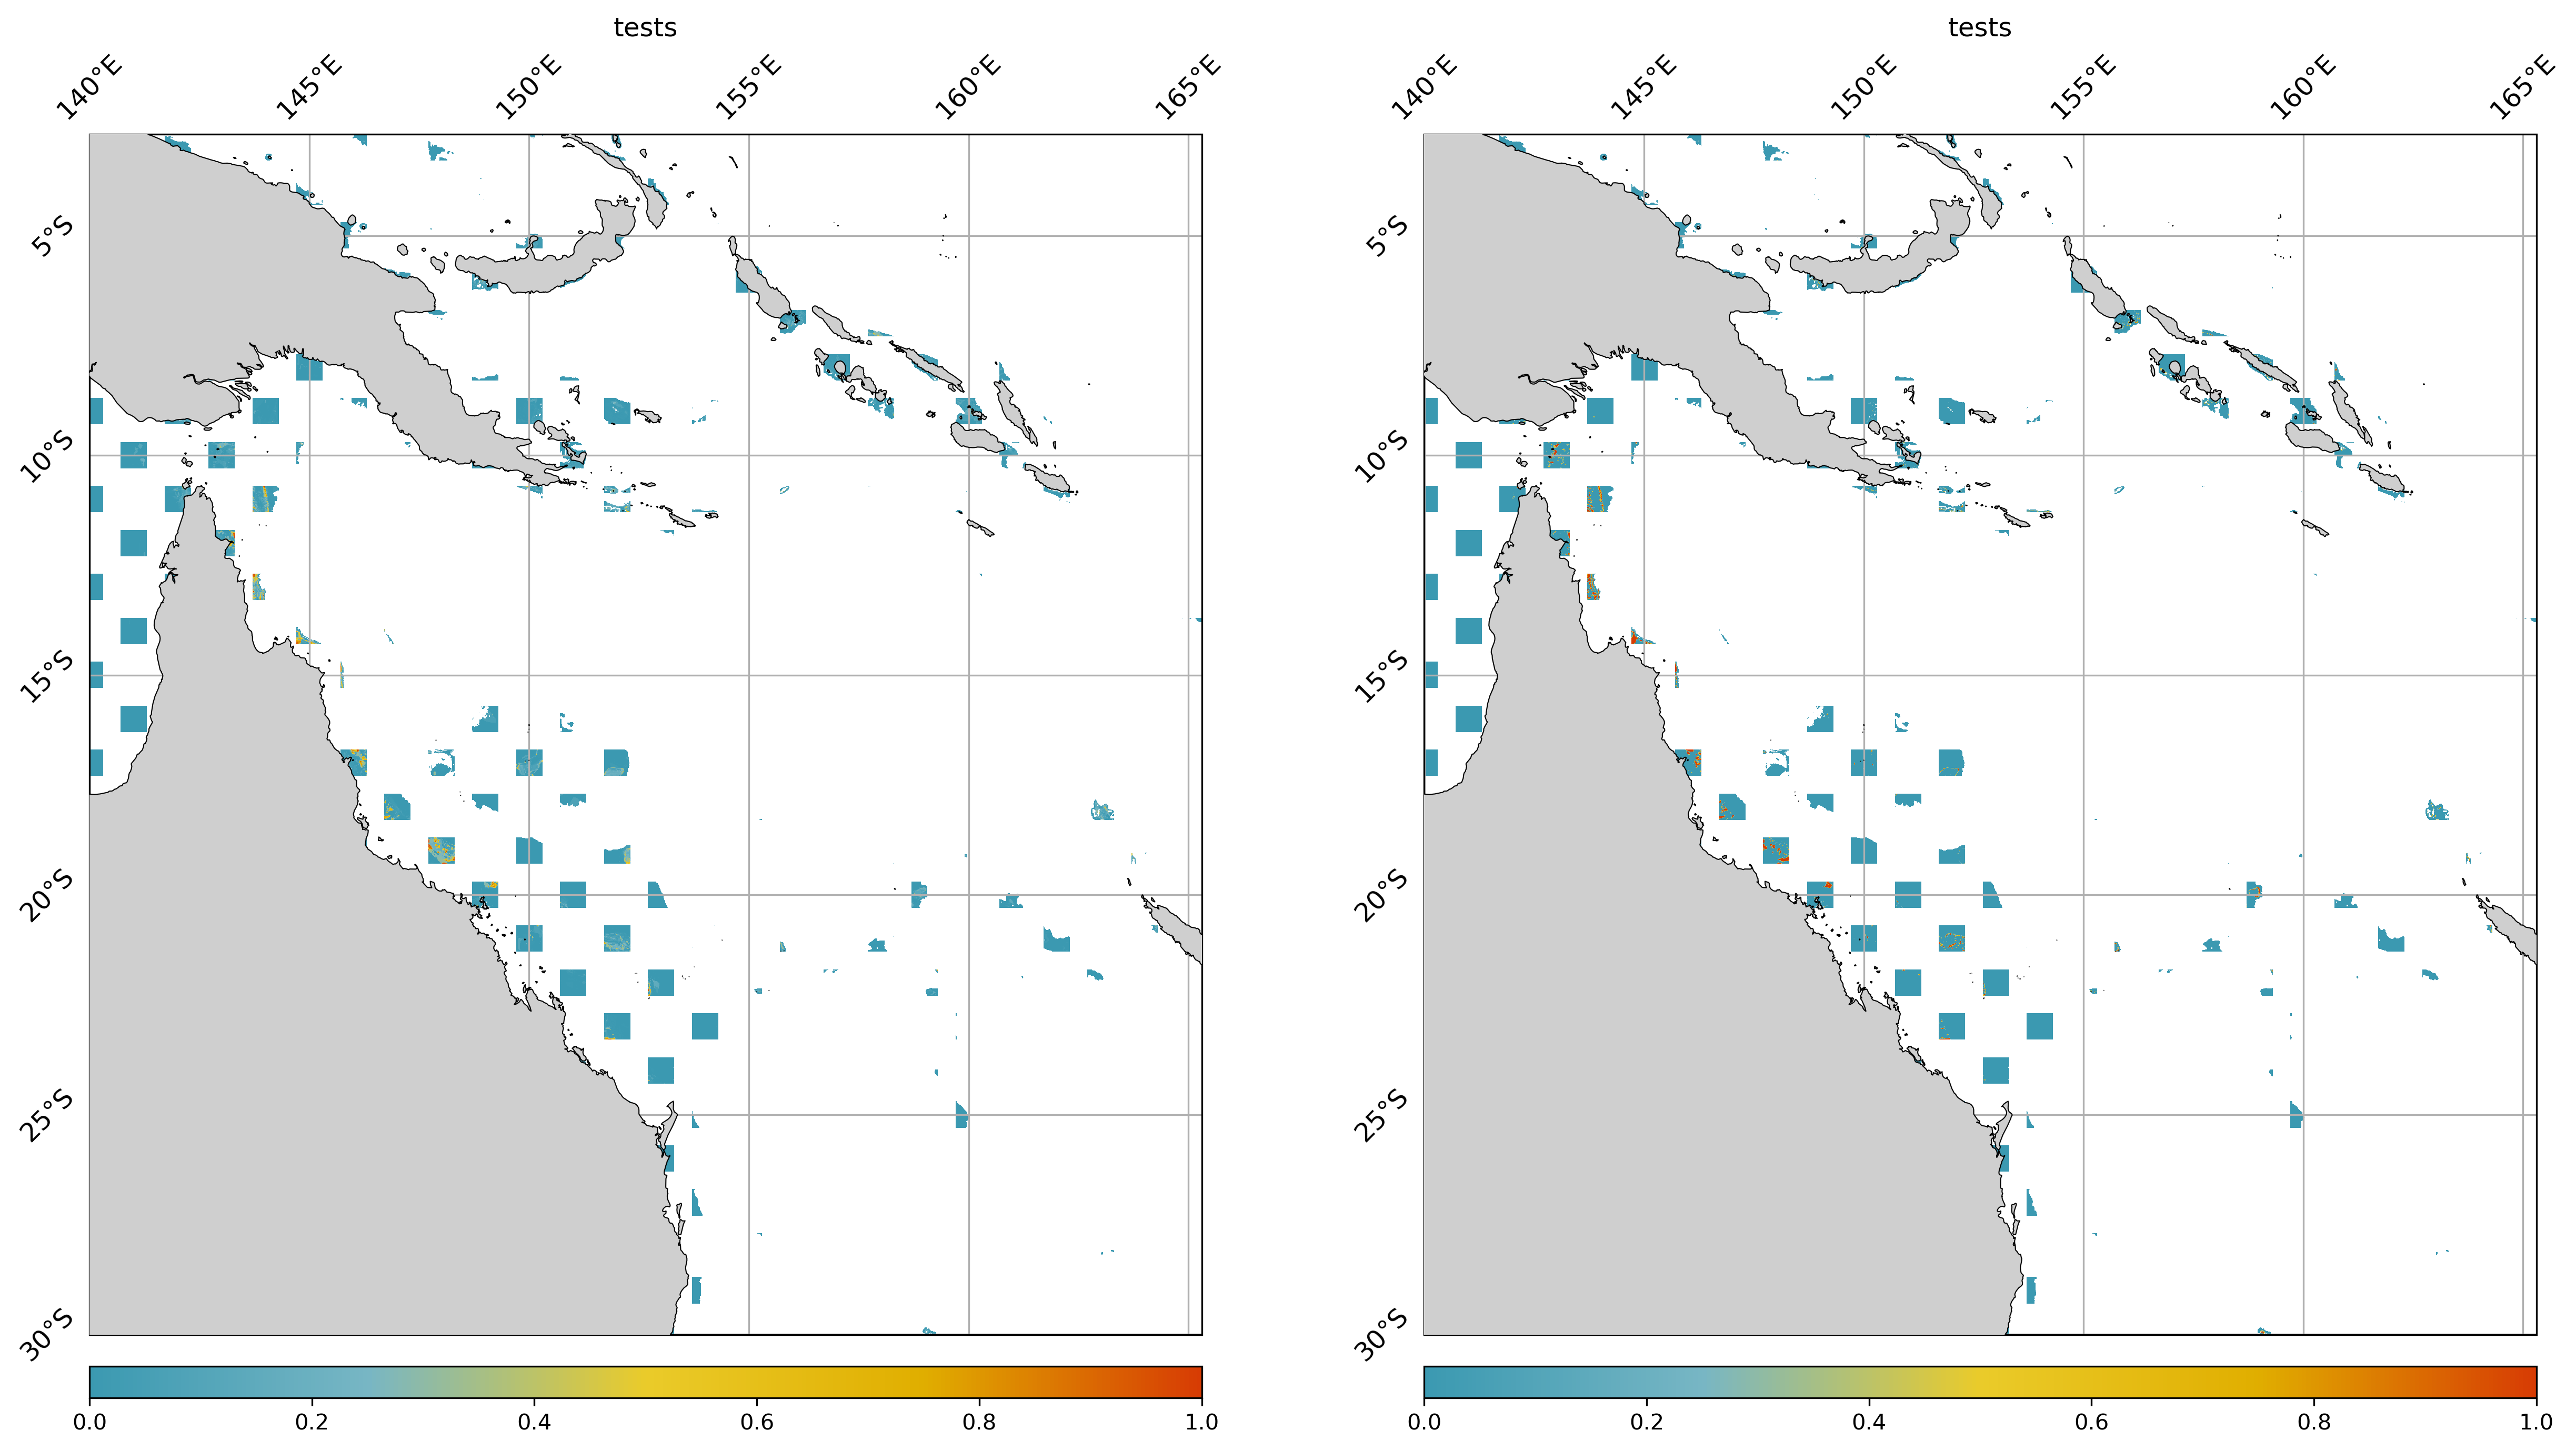

In [23]:
# make predictions
preds = pd.Series(model.predict(dtest), y_tests.index)
# constrain preds
preds.clip(0, 1, inplace=True)
# reform spatially
preds_ccheckerboard = spatial_data.spatially_reform_data(preds, resolution=config_info["resolution"])
y_tests_ccheckerboard = spatial_data.spatially_reform_data(y_tests, resolution=config_info["resolution"])

fig, ax = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20, 10), dpi=300)
spatial_plots.plot_spatial(preds_ccheckerboard[0], title="tests", cbar_dict={"orientation": "horizontal"}, fax=(fig, ax[0]))
spatial_plots.plot_spatial(y_tests_ccheckerboard[0], title="tests", cbar_dict={"orientation": "horizontal"}, fax=(fig, ax[1]))

In [1]:
aoi_lats = [-15, -10]
aoi_lons = [140, 145]

# zoom into area
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20, 10), dpi=300)
spatial_plots.plot_spatial(preds_ccheckerboard[0].sel(latitude=slice(min(aoi_lats), max(aoi_lats)), longitude=slice(min(aoi_lons), max(aoi_lons))),
    title="tests", cbar_dict={"orientation": "horizontal"}, fax=(fig, ax[0]))
spatial_plots.plot_spatial(y_tests_ccheckerboard[0].sel(latitude=slice(min(aoi_lats), max(aoi_lats)), longitude=slice(min(aoi_lons), max(aoi_lons))),
    title="tests", cbar_dict={"orientation": "horizontal"}, fax=(fig, ax[1]))

NameError: name 'plt' is not defined

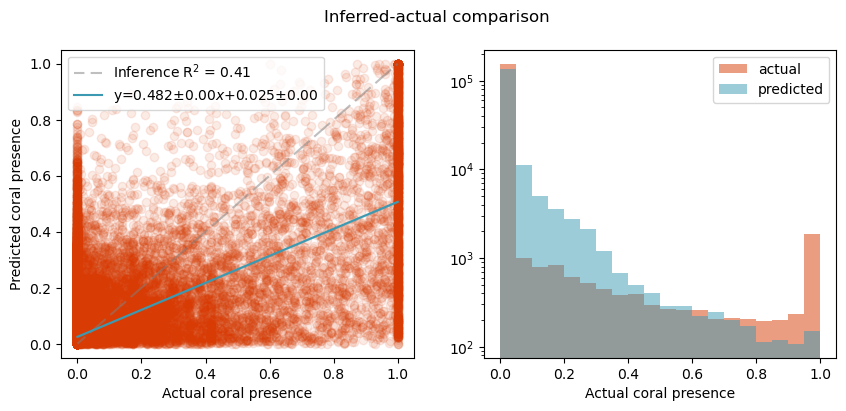

In [28]:
visualise_results.plot_regression_histograms(y_tests[0], preds)

In [30]:
y_tests_ccheckerboard[0]

<xarray.DataArray 0 (latitude: 2731, longitude: 2531)> Size: 55MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * latitude   (latitude) float64 22kB -30.0 -29.99 -29.98 ... -2.72 -2.71 -2.7
  * longitude  (longitude) float64 20kB 140.0 140.0 140.0 ... 165.3 165.3 165.3

(<Figure size 1600x1400 with 2 Axes>,
 <GeoAxes: title={'center': 'residuals at 0.0100° (~1085 m) resolution'}, xlabel='longitude', ylabel='latitude'>)

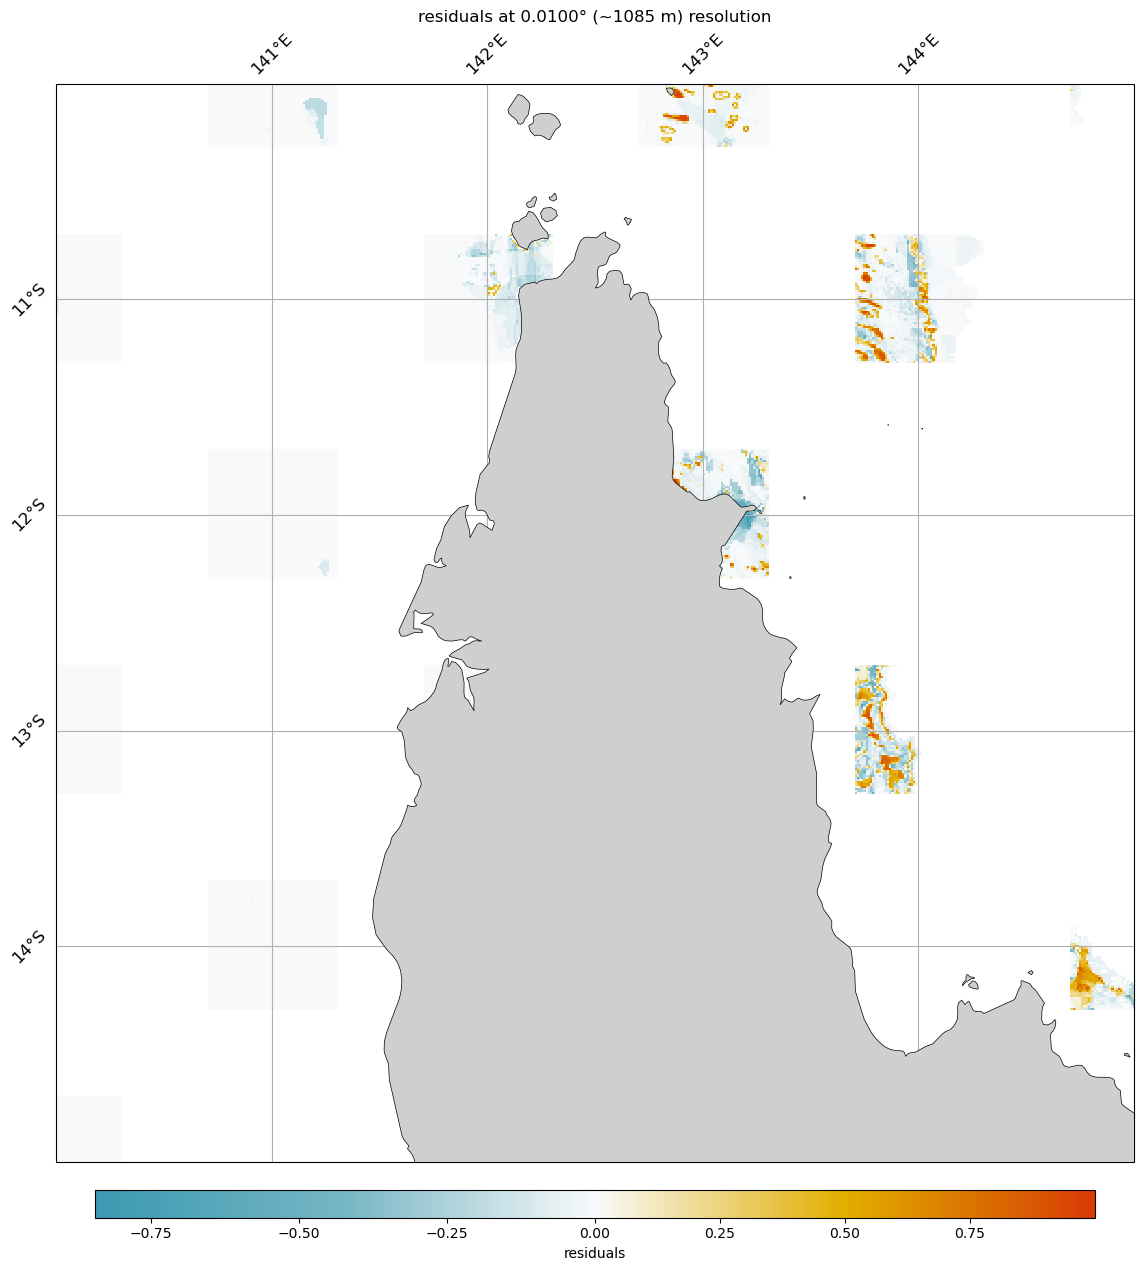

In [36]:
visualise_results.plot_spatial_residuals(y_tests[0], preds, extent=[min(aoi_lons), max(aoi_lons), min(aoi_lats), max(aoi_lats)])


In [40]:
# get models most important features
importances = model.get_score(importance_type="weight")
# plot feature importances from dictionary of names and values

In [56]:
importances

{'tos_january_mean': 32979.0,
 'tos_february_mean': 19189.0,
 'tos_march_mean': 17814.0,
 'tos_april_mean': 25943.0,
 'tos_may_mean': 27120.0,
 'tos_june_mean': 15884.0,
 'tos_july_mean': 13591.0,
 'tos_august_mean': 5752.0,
 'tos_september_mean': 8454.0,
 'tos_october_mean': 5824.0,
 'tos_november_mean': 9058.0,
 'tos_december_mean': 8290.0,
 'tos_january_max': 13978.0,
 'tos_january_min': 14048.0,
 'tos_february_max': 11950.0,
 'tos_february_min': 12555.0,
 'tos_march_max': 8948.0,
 'tos_march_min': 4349.0,
 'tos_april_max': 6120.0,
 'tos_april_min': 6262.0,
 'tos_may_max': 3747.0,
 'tos_may_min': 3497.0,
 'tos_june_max': 4218.0,
 'tos_june_min': 4265.0,
 'tos_july_max': 3641.0,
 'tos_july_min': 3582.0,
 'tos_august_max': 3174.0,
 'tos_august_min': 3488.0,
 'tos_september_max': 3515.0,
 'tos_september_min': 2743.0,
 'tos_october_max': 3342.0,
 'tos_october_min': 2213.0,
 'tos_november_max': 3517.0,
 'tos_november_min': 2752.0,
 'tos_december_max': 3693.0,
 'tos_december_min': 2661.0,

In [54]:
sorted_importances = list({k: v for k, v in sorted(importances.items(), key=lambda item: item[1])}.values())
sorted_labels = list({k: v for k, v in sorted(importances.items(), key=lambda item: item[1])}.keys())

In [60]:
sorted_labels

['wfo_march_max',
 'rsdo_july_max',
 'rsdo_july_min',
 'rsdo_october_min',
 'rsdo_december_mean',
 'rsdo_april_max',
 'thetao_october_mean',
 'wfo_november_max',
 'thetao_may_mean',
 'rsdo_august_max',
 'thetao_august_mean',
 'rsdo_june_min',
 'wfo_june_mean',
 'thetao_september_mean',
 'rsdo_december_max',
 'thetao_july_max',
 'thetao_june_max',
 'rsdo_overall_mean',
 'rsdo_december_min',
 'thetao_overall_mean',
 'hfds_june_mean',
 'hfds_january_mean',
 'wfo_overall_mean',
 'hfds_time_std',
 'thetao_september_min',
 'wfo_december_max',
 'thetao_june_mean',
 'wfo_october_mean',
 'rsdo_november_max',
 'wfo_august_min',
 'wfo_april_mean',
 'wfo_december_mean',
 'thetao_april_mean',
 'rsdo_time_std',
 'wfo_time_std',
 'thetao_june_min',
 'wfo_january_max',
 'hfds_overall_mean',
 'rsdo_november_min',
 'thetao_september_max',
 'wfo_jul_std',
 'thetao_july_mean',
 'vo_overall_mean',
 'rsdo_november_mean',
 'rsdo_may_max',
 'wfo_july_max',
 'thetao_december_mean',
 'hfds_april_mean',
 'thetao

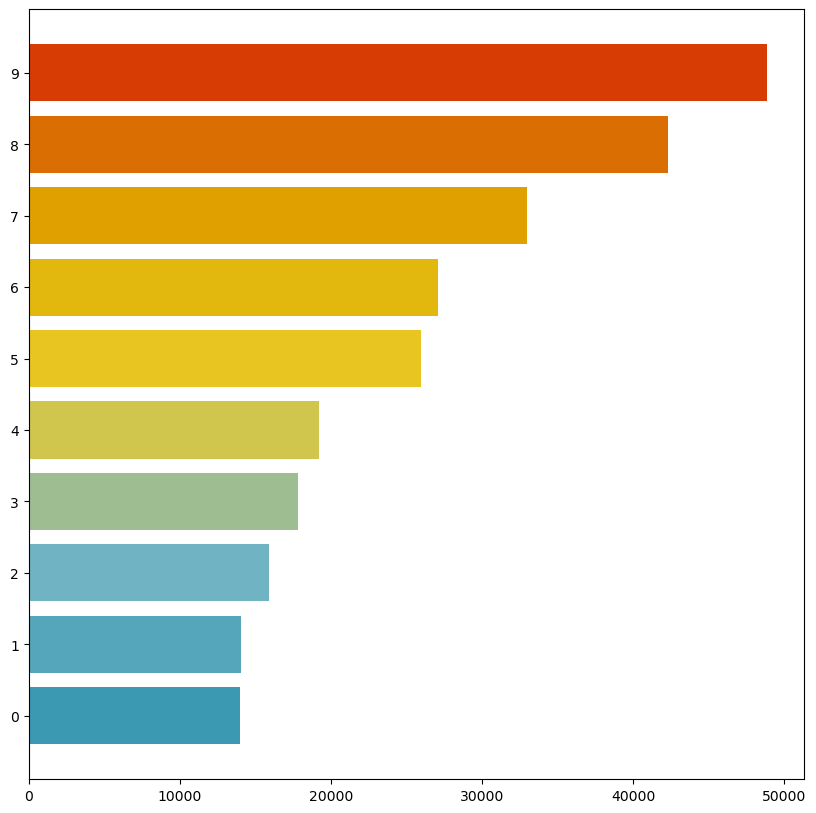

In [59]:
figsize=(10,10)
n_samples = 10
# adjust figsize based on number of samples, if not provided
if not figsize:
    figsize = (10, n_samples * 0.25)

fig, ax = plt.subplots(figsize=figsize)

cmap = spatial_plots.ColourMapGenerator().get_cmap("seq")(
    np.linspace(0, 1, n_samples)
)

ax.barh(
    range(len(sorted_importances[-n_samples:])),
    sorted_importances[-n_samples:],
    color=cmap,
)

# formatting
ax.set_yticks(range(n_samples))
# _ = ax.set_yticklabels(sorted_labels[-n_samples:])
# plt.xlabel("Importance")
# plt.ylabel("Feature")
# plt.grid(axis="x", linestyle="-", alpha=0.6)
# # plot minor gridlines
# plt.minorticks_on()
# plt.grid(axis="x", which="minor", linestyle="-0", alpha=0.2)